# P4: Construisez un modèle de scoring
<img src="img/oc.png" width="300" height="300"/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import scipy.stats as st

# File system manangement
import os
import gc
import time

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from lightgbm import LGBMClassifier

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import model_selection

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


from functions import *
from utils import *

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"


In [2]:
def plt_barsstats(df, col):
    plt.figure(figsize=(15,8))
    ax = sns.barplot(y=df[col].value_counts(normalize=True), x=df[col].value_counts(normalize=True).index, data=df);
    show_values(ax, space=0.01)
    plt.title('Counting contracts for each {0}'.format(col), fontsize=20);
    plt.ylabel('% of contracts', fontsize=15);
    plt.xlabel('{0}'.format(col), fontsize=15);
    plt.show();

    plt.figure(figsize=(15,8))
    ax = sns.barplot( x=col, y ='TARGET', data=df)#, order=df[col]);
    show_values(ax, space=0.1)
    plt.title('Percent of not repayed contracts', fontsize=20);
    plt.ylabel('Percent of TARGET with value = 1', fontsize=15);
    plt.xlabel('{0}'.format(col), fontsize=15);
    plt.show();

# Importation des données
## Data description

There are 7 different sources of data:

 - application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
 - bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
 - bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
 - previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
 - POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
 - credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
 - installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.
 
 A breaf explanation of the data and it's organization in different files can be seen in the following image:
 
 <img src="img/home_credit.png" width="1000" height="800"/>
 
 
`SK_ID_CURR` is connecting the dataframes application_train and application_test with bureau, previous_application, POS_CASH_BALANCE. installments_payment and credit_card_balance. `SK_ID_PREV` connects dataframe previous_application with POS_CASH_balance, installments_payment and credit_card_balance. `SK_ID_BUREAU` connects dataframe bureau with dataframe bureau_balance.

In [3]:
# List files available
for file in os.listdir("data/"):
    if file!='.DS_Store':
        print(file)

application_test.csv
HomeCredit_columns_description.csv
POS_CASH_balance.csv
preprocess
credit_card_balance.csv
installments_payments.csv
application_train.csv
bureau.csv
previous_application.csv
bureau_balance.csv
sample_submission.csv


### Columns description for all files

In [4]:
df_col_description = pd.read_csv('data/HomeCredit_columns_description.csv', sep=',', encoding='utf-8', encoding_errors='ignore')
#df = data.copy()
df_col_description.head(5)
df_col_description[~df_col_description.Special.isna()]
del df_col_description

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

Unnamed: 0                         Table                         Row  \
16           19  application_{train|test}.csv  REGION_POPULATION_RELATIVE   
17           20  application_{train|test}.csv                  DAYS_BIRTH   
18           21  application_{train|test}.csv               DAYS_EMPLOYED   
19           22  application_{train|test}.csv           DAYS_REGISTRATION   
20           23  application_{train|test}.csv             DAYS_ID_PUBLISH   
..          ...                           ...                         ...   
209         212      previous_application.csv            DAYS_TERMINATION   
211         214     installments_payments.csv                 SK_ID_PREV    
212         215     installments_payments.csv                  SK_ID_CURR   
215         218     installments_payments.csv             DAYS_INSTALMENT   
216         219     installments_payments.csv          DAYS_ENTRY_PAYMENT   

                                           Description  \
16   Normalized population of region where client l...   
17     Client's age in days at the time of application   
18   How many days before the application the perso...   
19   How many days before the application did clien...   
20   How many days before the application did clien...   
..                                                 ...   
209  Relative to application date of current applic...   
211  ID of previous credit in Home credit related t...   
212                           ID of loan in our sample   
215  When the installment of previous credit was su...   
216  When was the installments of previous credit p...   

                                   Special  
16                             normalized   
17   time only relative to the application  
18   time only relative to the application  
19   time only relative to the application  
20   time only relative to the application  
..                                     ...  
209  time only relative to the application  
211                                 hashed  
212                                 hashed  
215  time only relative to the application  
216  time only relative to the application  

[86 rows x 5 columns]

### Application train : `df_train`

In [3]:
with timer("load df_train"):
    df_train = pd.read_csv('data/application_train.csv')
    #df = data.copy()
    df_train.head(5)
    # quantité des données
    print('Les quantité des données')
    df_train.shape

    # regarder les type des variable
    print('Les type observé pour chaque variable')
    df_train.dtypes

    print('Conté les type des variables')
    df_train.dtypes.value_counts()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

Les quantité des données


(307511, 122)

Les type observé pour chaque variable


SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

Conté les type des variables


float64    65
int64      41
object     16
dtype: int64

load df_train - done in 2s


In [6]:
# afficher les valeurs unique pour chaque variable
df_train.nunique()

SK_ID_CURR                    307511
TARGET                             2
NAME_CONTRACT_TYPE                 2
CODE_GENDER                        3
FLAG_OWN_CAR                       2
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY          9
AMT_REQ_CREDIT_BUREAU_WEEK         9
AMT_REQ_CREDIT_BUREAU_MON         24
AMT_REQ_CREDIT_BUREAU_QRT         11
AMT_REQ_CREDIT_BUREAU_YEAR        25
Length: 122, dtype: int64

In [7]:
df_train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables!

In [8]:
df_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

### Application test : `df_test`

In [5]:
with timer("load df_test"):
    df_test = pd.read_csv('data/application_test.csv')
    #df = data.copy()
    df_test.head(5)
    # quantité des données
    print('Les quantité des données')
    df_test.shape

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

Les quantité des données


(48744, 121)

load df_test - done in 0s


### Bureau balance : `df_bureau_balance`

In [10]:
with timer("load df_bureau_balance"):
    df_bureau_balance = pd.read_csv('data/bureau_balance.csv')
    df_bureau_balance.head()
    # quantité des données
    print('Les quantité des données')
    df_bureau_balance.shape

    # regarder les type des variable
    print('Les type observé pour chaque variable')
    df_bureau_balance.dtypes

    print('Conté les type des variables')
    df_bureau_balance.dtypes.value_counts()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

Les quantité des données


(27299925, 3)

Les type observé pour chaque variable


SK_ID_BUREAU       int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

Conté les type des variables


int64     2
object    1
dtype: int64

load df_bureau_balance - done in 4s


### Bureau : `df_bureau`

In [4]:
with timer("load df_bureau"):
    df_bureau = pd.read_csv('data/bureau.csv')
    df_bureau.head()
    # quantité des données
    print('Les quantité des données')
    df_bureau.shape

    # regarder les type des variable
    print('Les type observé pour chaque variable')
    df_bureau.dtypes

    print('Conté les type des variables')
    df_bureau.dtypes.value_counts()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

Les quantité des données


(1716428, 17)

Les type observé pour chaque variable


SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

Conté les type des variables


float64    8
int64      6
object     3
dtype: int64

load df_bureau - done in 1s


### Credit card balance : `df_credit_card_balance`

In [12]:
with timer("load df_credit_card_balance"):
    df_credit_card_balance = pd.read_csv('data/credit_card_balance.csv')
    df_credit_card_balance.head()
    # quantité des données
    print('Les quantité des données')
    df_credit_card_balance.shape

    # regarder les type des variable
    print('Les type observé pour chaque variable')
    df_credit_card_balance.dtypes

    print('Conté les type des variables')
    df_credit_card_balance.dtypes.value_counts()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

Les quantité des données


(3840312, 23)

Les type observé pour chaque variable


SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
dtype: object

Conté les type des variables


float64    15
int64       7
object      1
dtype: int64

load df_credit_card_balance - done in 5s


### Installments payments : `df_installments_payments`

In [13]:
with timer("load df_installments_payments"):
    df_installments_payments = pd.read_csv('data/installments_payments.csv')
    df_installments_payments.head()
    # quantité des données
    print('Les quantité des données')
    df_installments_payments.shape

    # regarder les type des variable
    print('Les type observé pour chaque variable')
    df_installments_payments.dtypes

    print('Conté les type des variables')
    df_installments_payments.dtypes.value_counts()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

Les quantité des données


(13605401, 8)

Les type observé pour chaque variable


SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object

Conté les type des variables


float64    5
int64      3
dtype: int64

load df_installments_payments - done in 7s


### POS CASH balance : `df_POS_CASH_balance`

In [14]:
with timer("load df_POS_CASH_balance"):
    df_POS_CASH_balance = pd.read_csv('data/POS_CASH_balance.csv')
    df_POS_CASH_balance.head()
    # quantité des données
    print('Les quantité des données')
    df_POS_CASH_balance.shape

    # regarder les type des variable
    print('Les type observé pour chaque variable')
    df_POS_CASH_balance.dtypes

    print('Conté les type des variables')
    df_POS_CASH_balance.dtypes.value_counts()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

Les quantité des données


(10001358, 8)

Les type observé pour chaque variable


SK_ID_PREV                 int64
SK_ID_CURR                 int64
MONTHS_BALANCE             int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS      object
SK_DPD                     int64
SK_DPD_DEF                 int64
dtype: object

Conté les type des variables


int64      5
float64    2
object     1
dtype: int64

load df_POS_CASH_balance - done in 4s


### Previous application : `df_previous_application`

In [5]:
with timer("load df_previous_application"):
    df_previous_application = pd.read_csv('data/previous_application.csv')
    df_previous_application.head()
    # quantité des données
    print('Les quantité des données')
    df_previous_application.shape

    # regarder les type des variable
    print('Les type observé pour chaque variable')
    df_previous_application.dtypes

    print('Conté les type des variables')
    df_previous_application.dtypes.value_counts()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

Les quantité des données


(1670214, 37)

Les type observé pour chaque variable


SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_DOWN_PAYMENT               float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
RATE_DOWN_PAYMENT              float64
RATE_INTEREST_PRIMARY          float64
RATE_INTEREST_PRIVILEGED       float64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE                 object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE             

Conté les type des variables


object     16
float64    15
int64       6
dtype: int64

load df_previous_application - done in 4s


# Exploratory Data Analysis

## Examine missing values
### Application train

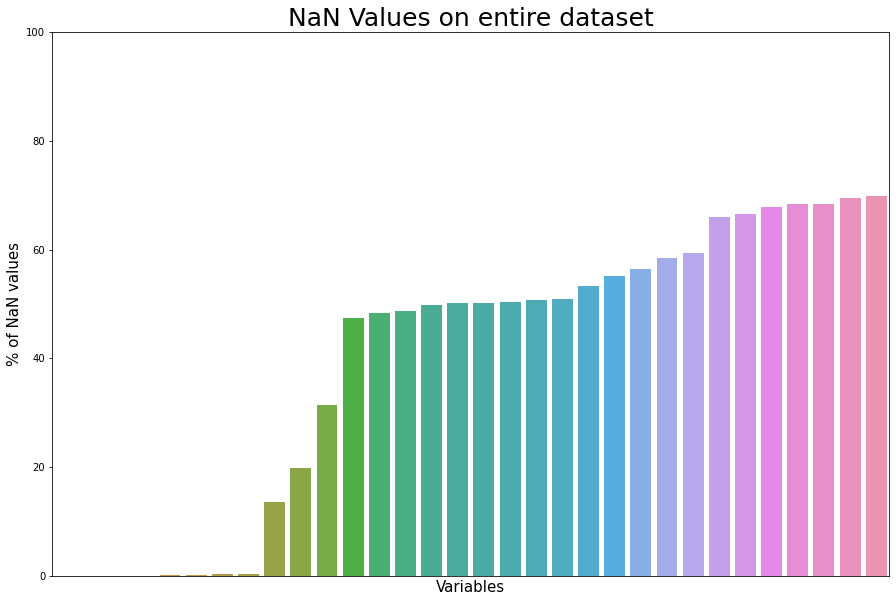

In [16]:
plot_nan_in_pourcent_from_data(df_train)

In [17]:
# Missing values statistics
missing_values = missing_values_table(df_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

### Application test

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

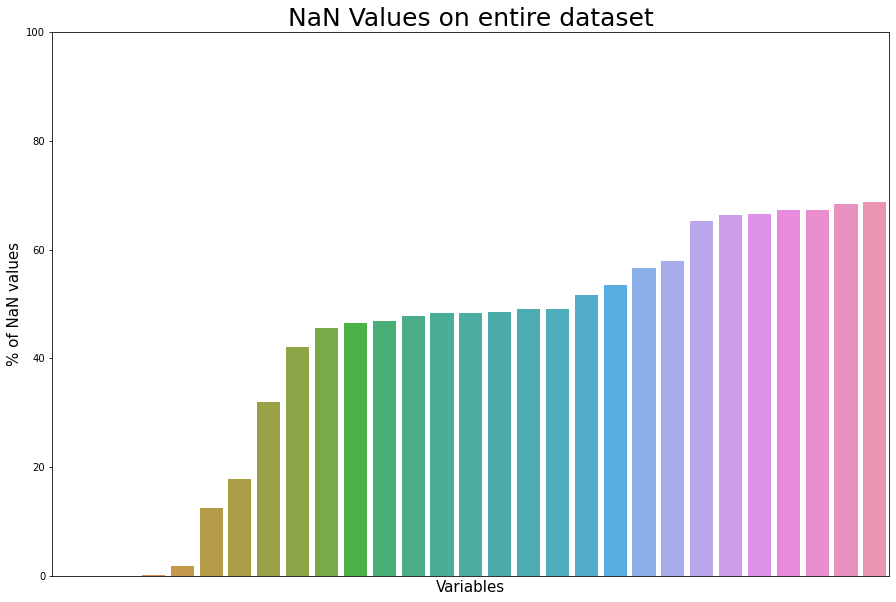

In [18]:
plot_nan_in_pourcent_from_data(df_test)
# Missing values statistics
missing_values = missing_values_table(df_train)
missing_values.head(20)

### Bureau balance 

In [19]:
# Missing values statistics
missing_values = missing_values_table(df_bureau_balance)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


### Bureau

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.


Missing Values  % of Total Values
AMT_ANNUITY                    1226791               71.5
AMT_CREDIT_MAX_OVERDUE         1124488               65.5
DAYS_ENDDATE_FACT               633653               36.9
AMT_CREDIT_SUM_LIMIT            591780               34.5
AMT_CREDIT_SUM_DEBT             257669               15.0
DAYS_CREDIT_ENDDATE             105553                6.1
AMT_CREDIT_SUM                      13                0.0

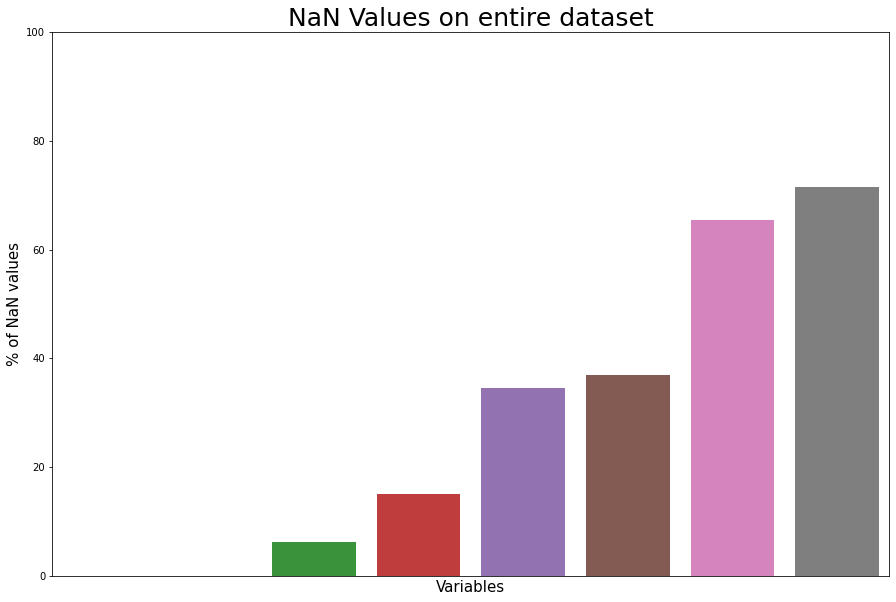

In [20]:
plot_nan_in_pourcent_from_data(df_bureau)
# Missing values statistics
missing_values = missing_values_table(df_bureau)
missing_values

### Creadit card balance

Your selected dataframe has 23 columns.
There are 9 columns that have missing values.


Missing Values  % of Total Values
AMT_PAYMENT_CURRENT                 767988               20.0
AMT_DRAWINGS_ATM_CURRENT            749816               19.5
AMT_DRAWINGS_OTHER_CURRENT          749816               19.5
AMT_DRAWINGS_POS_CURRENT            749816               19.5
CNT_DRAWINGS_ATM_CURRENT            749816               19.5
CNT_DRAWINGS_OTHER_CURRENT          749816               19.5
CNT_DRAWINGS_POS_CURRENT            749816               19.5
AMT_INST_MIN_REGULARITY             305236                7.9
CNT_INSTALMENT_MATURE_CUM           305236                7.9

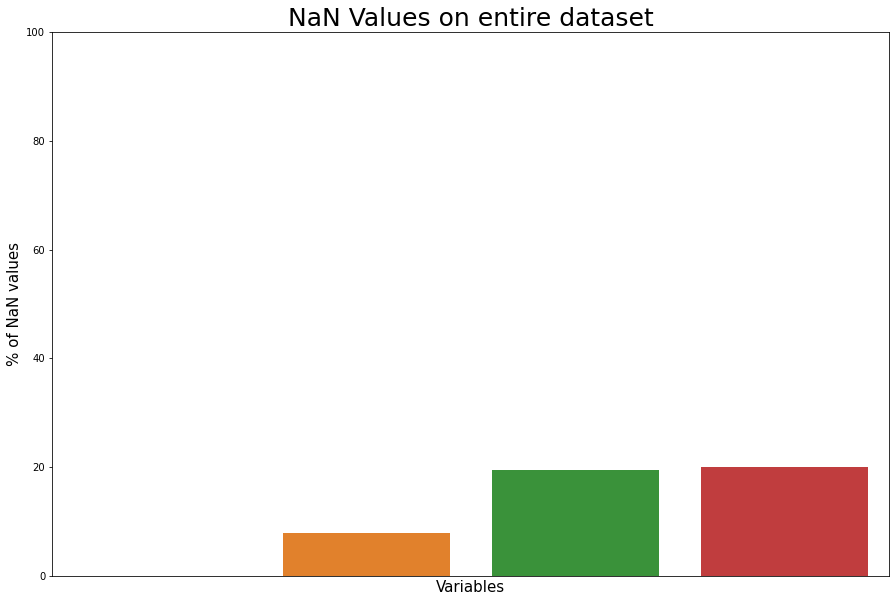

In [21]:
plot_nan_in_pourcent_from_data(df_credit_card_balance)
# Missing values statistics
missing_values = missing_values_table(df_credit_card_balance)
missing_values

### Installments payments

In [22]:
# Missing values statistics
missing_values = missing_values_table(df_installments_payments)
missing_values

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


Missing Values  % of Total Values
DAYS_ENTRY_PAYMENT            2905                0.0
AMT_PAYMENT                   2905                0.0

### POS Cash balance

In [23]:
# Missing values statistics
missing_values = missing_values_table(df_POS_CASH_balance)
missing_values

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


Missing Values  % of Total Values
CNT_INSTALMENT_FUTURE           26087                0.3
CNT_INSTALMENT                  26071                0.3

### Previous application

Your selected dataframe has 37 columns.
There are 16 columns that have missing values.


Missing Values  % of Total Values
RATE_INTEREST_PRIMARY             1664263               99.6
RATE_INTEREST_PRIVILEGED          1664263               99.6
AMT_DOWN_PAYMENT                   895844               53.6
RATE_DOWN_PAYMENT                  895844               53.6
NAME_TYPE_SUITE                    820405               49.1
DAYS_FIRST_DRAWING                 673065               40.3
DAYS_FIRST_DUE                     673065               40.3
DAYS_LAST_DUE_1ST_VERSION          673065               40.3
DAYS_LAST_DUE                      673065               40.3
DAYS_TERMINATION                   673065               40.3
NFLAG_INSURED_ON_APPROVAL          673065               40.3
AMT_GOODS_PRICE                    385515               23.1
AMT_ANNUITY                        372235               22.3
CNT_PAYMENT                        372230               22.3
PRODUCT_COMBINATION                   346                0.0
AMT_CREDIT                              1                0.0

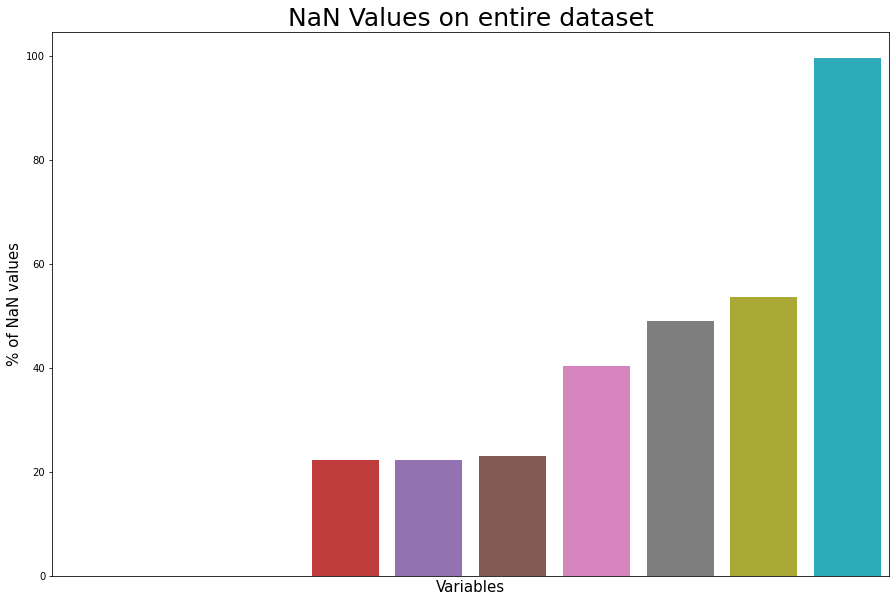

In [24]:
plot_nan_in_pourcent_from_data(df_previous_application)
# Missing values statistics
missing_values = missing_values_table(df_previous_application)
missing_values.head(20)


## Examine the variables in Application train dataset regarding to `TARGET`
### Unbalanced data : `TARGET` column

First we need to understand the target variable.
 - 0 means loan is repayed
 - 1 means loan is not repayed

In [25]:
df_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

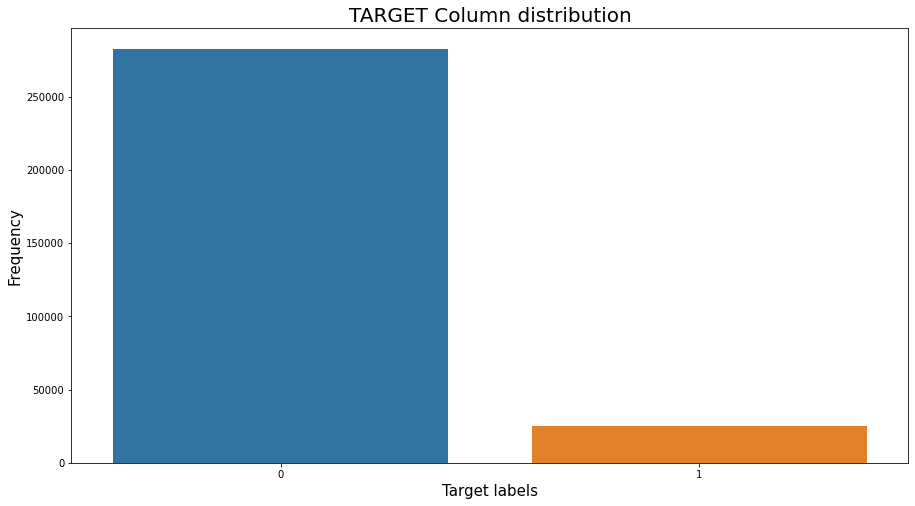

In [26]:
plt.figure(figsize=(15,8))
sns.barplot(x = df_train.TARGET.value_counts().index, y = df_train.TARGET.value_counts(), data = df_train)
plt.title('TARGET Column distribution', fontsize=20);
plt.xlabel('Target labels', fontsize=15);
plt.ylabel('Frequency', fontsize=15);
plt.show();

### Contract types

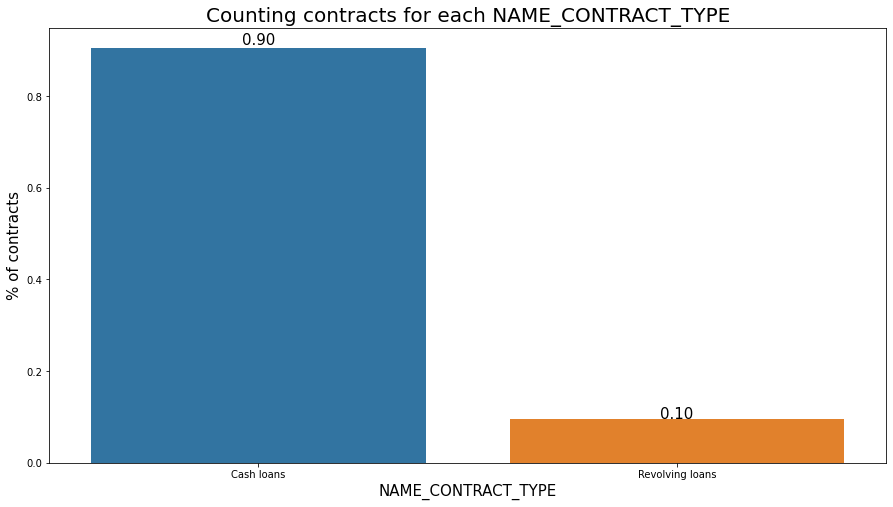

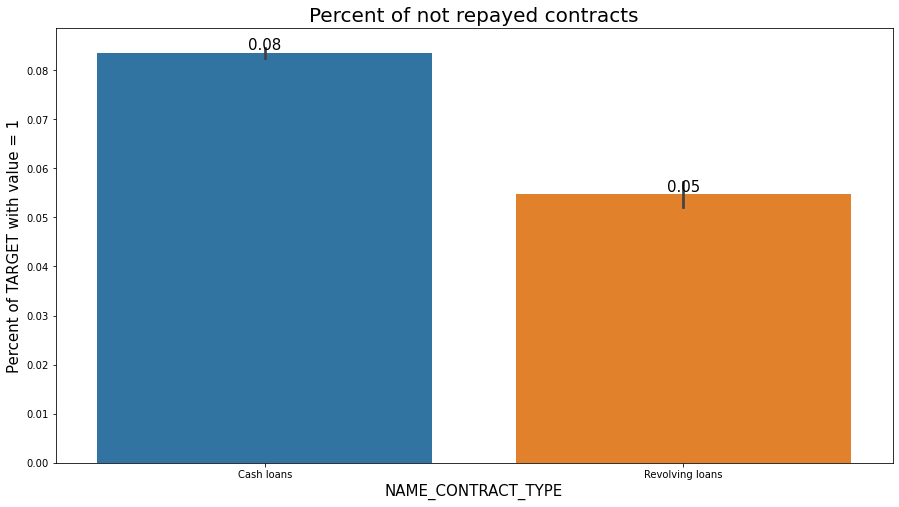

In [27]:
plt_barsstats(df_train, 'NAME_CONTRACT_TYPE')

Now we easly can say that the we have 2 types of contract. First the cash lioans with about 90% and second the Revolving loans with about 10% of contracts. So we naturally ask ourselfs ***how much of them are not repayed?*** Observe that cash loans are about 8% not repayed comparing to 5% not repaued revolving loans contracts.

### Stats on clients description over the contracts and loan nonpayed
***What can we say about the client gender stats on contracts?***

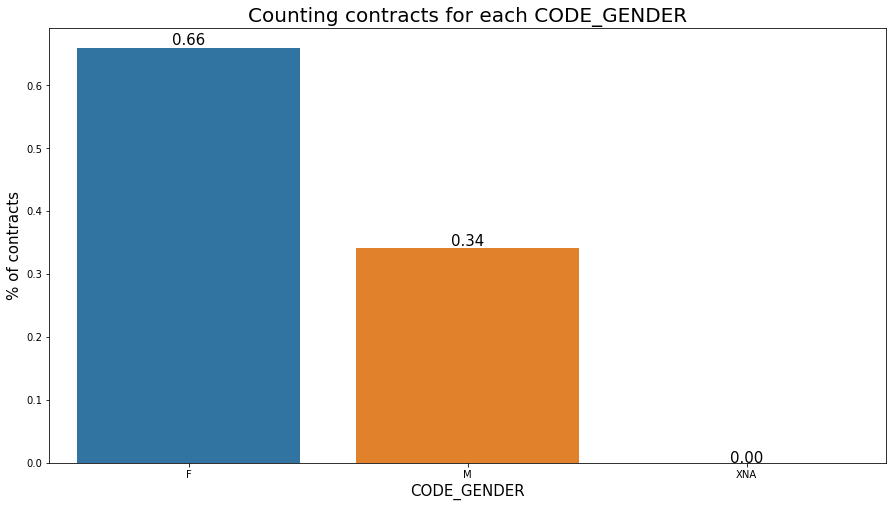

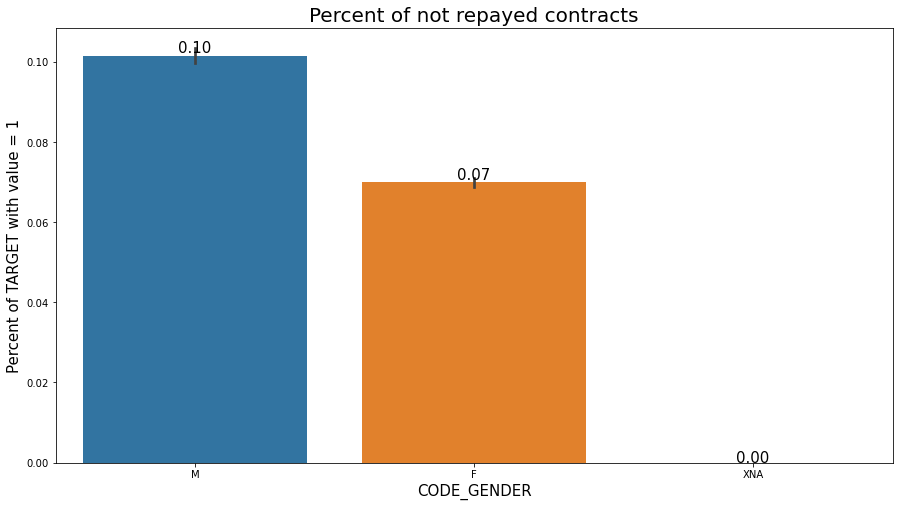

In [28]:
plt_barsstats(df_train, 'CODE_GENDER')

Observe about 66% of contracts are made by women ad 34% are made by men. ***But how much of contracts are repayed for each gender?*** We can affirm that unpayed contracts are about 10% for men and 7% for women.

***What can we say about the client income type stats on contracts?***

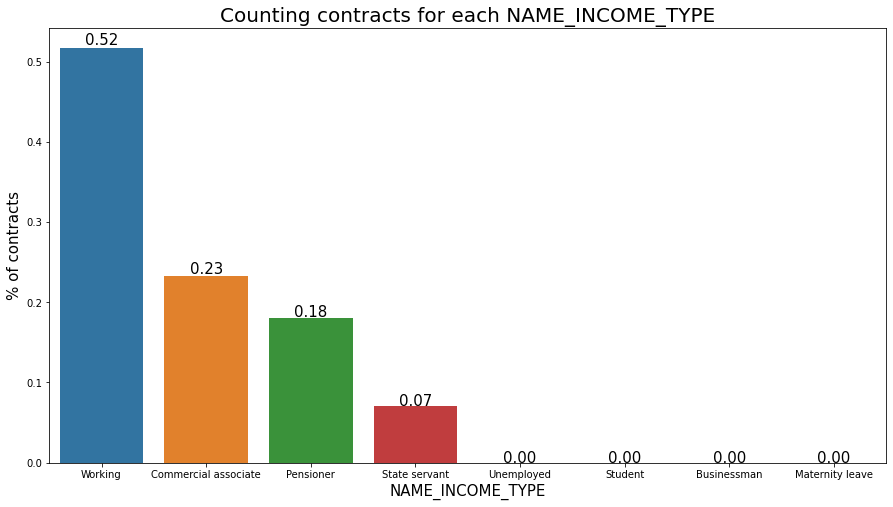

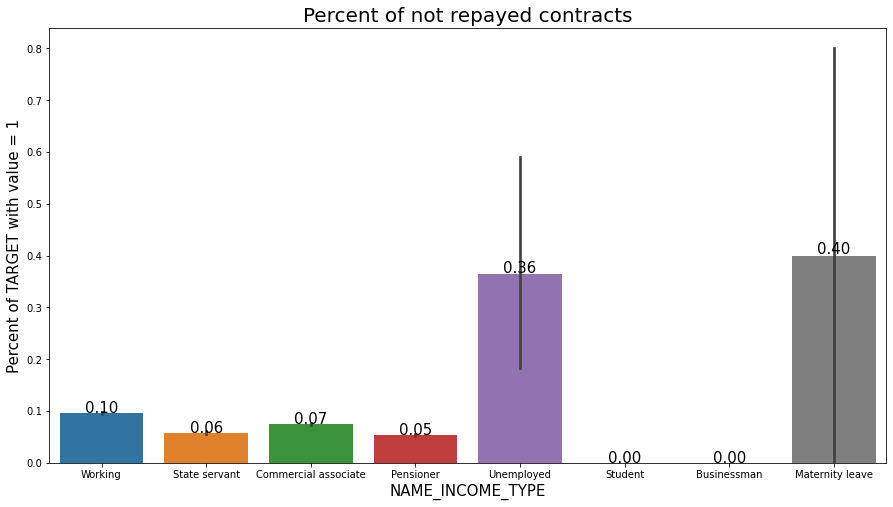

In [29]:
plt_barsstats(df_train, 'NAME_INCOME_TYPE')

The most loans have the working clients 50%. Theese have 10% of loans not repayed.
Also observe commercial assistance, pensioners, and state servant with 23%, 18% and 7% loans respectively.
Unemployed and Maternity leave has 36% and 40% of not repayed loans.

***What can we say about the clients education type stats on contracts?***

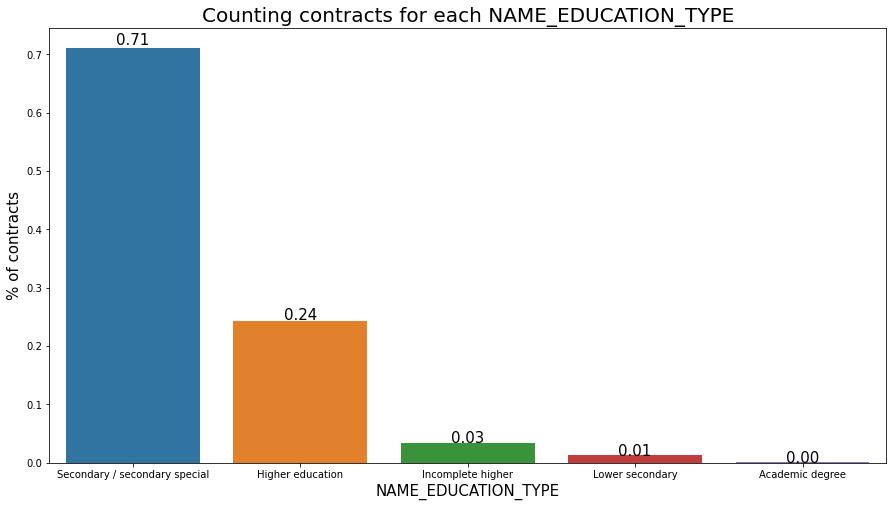

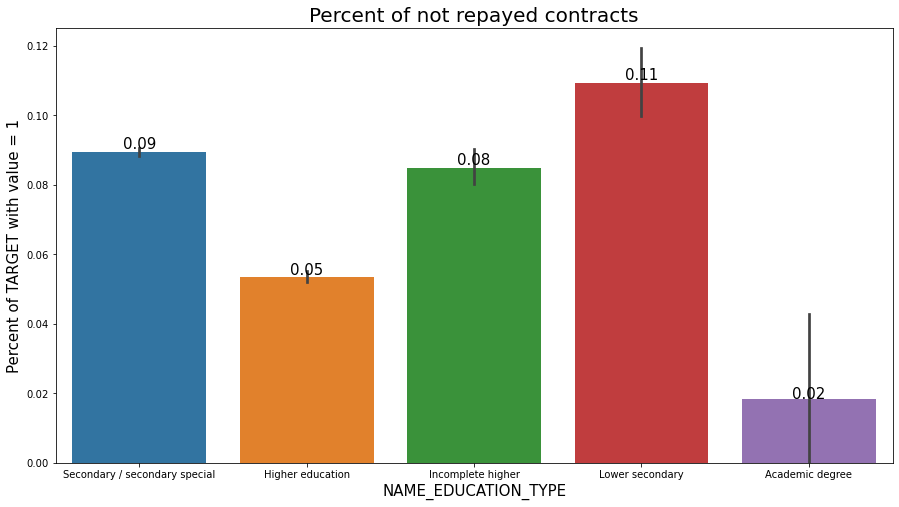

In [30]:
plt_barsstats(df_train, 'NAME_EDUCATION_TYPE')

Secondary/secondary specias clients education types have 71% of loans, despite the higher education clients with 24% of loans. 

***Show the most used categories of organization types***

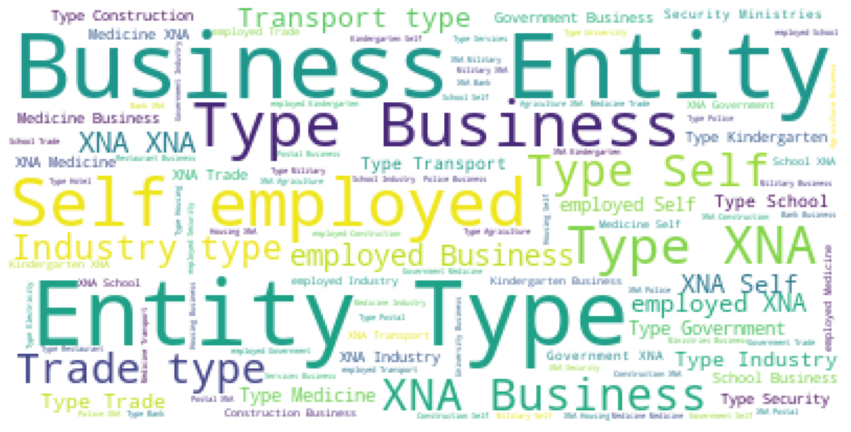

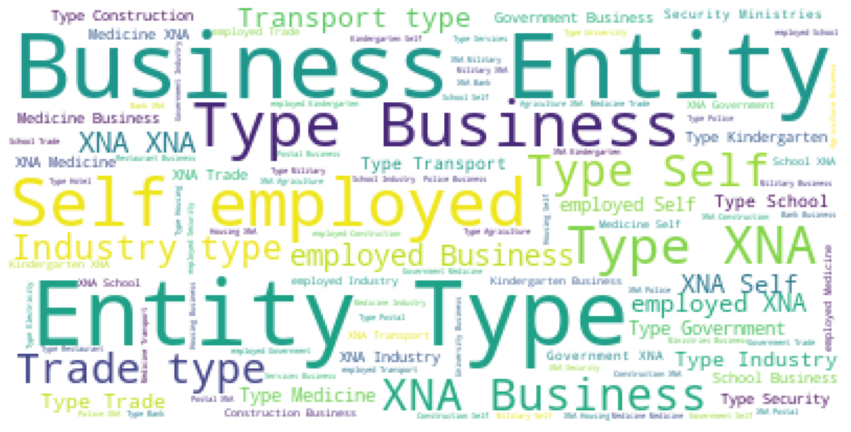

In [31]:
plot_words(df_train, 'ORGANIZATION_TYPE')

### Patrimoine
***What about owning a car?***

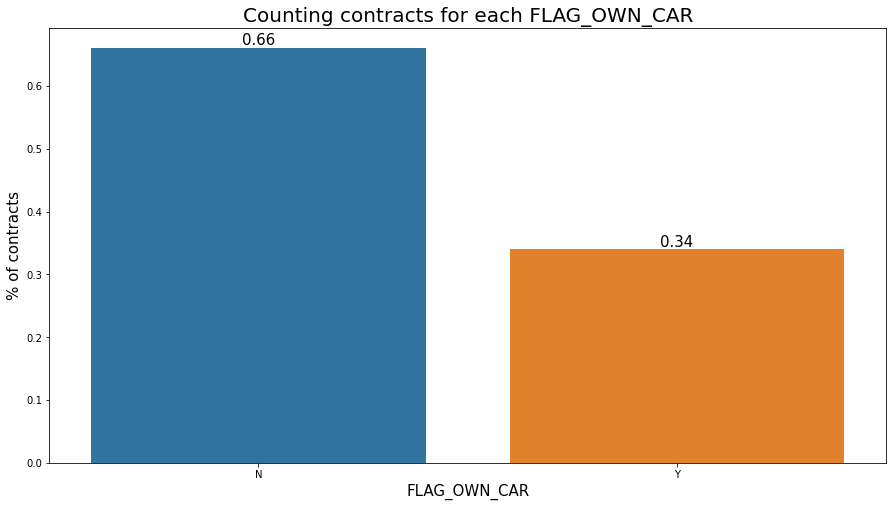

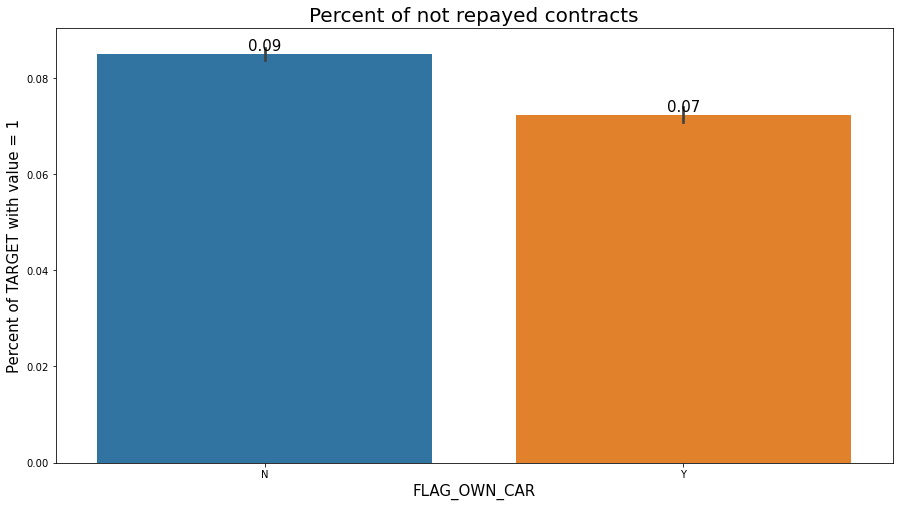

In [32]:
plt_barsstats(df_train, 'FLAG_OWN_CAR')

We can observe that about 35% of owned car persons has contracts comparing to 66% of persons not owning car. Despite this 7% of persons owning cars are with unpayed loans and 9% of persons not owning cars are with unpayed loans.

***What about owning a real estate?***

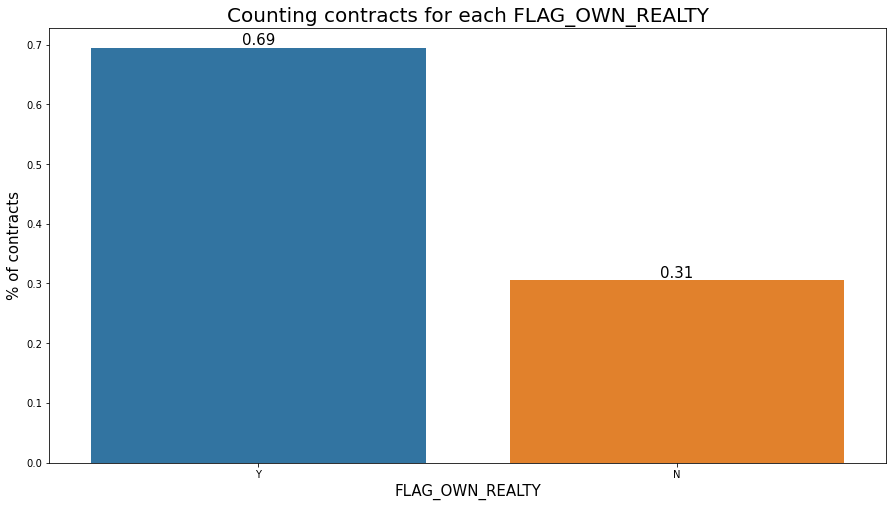

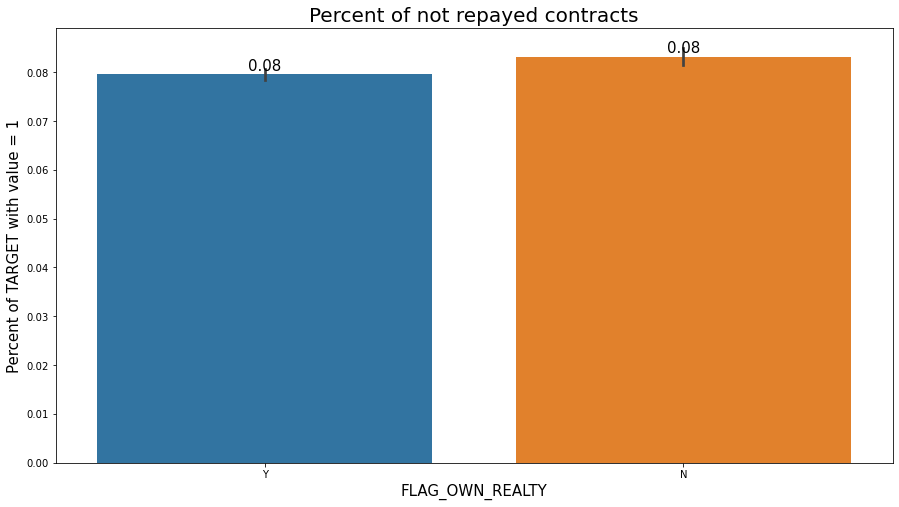

In [33]:
plt_barsstats(df_train, 'FLAG_OWN_REALTY')

***And what about owning the house type?***

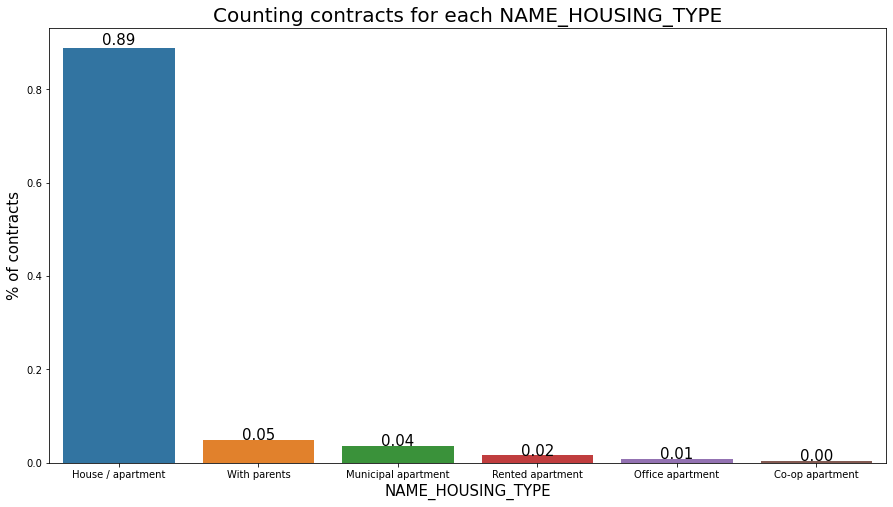

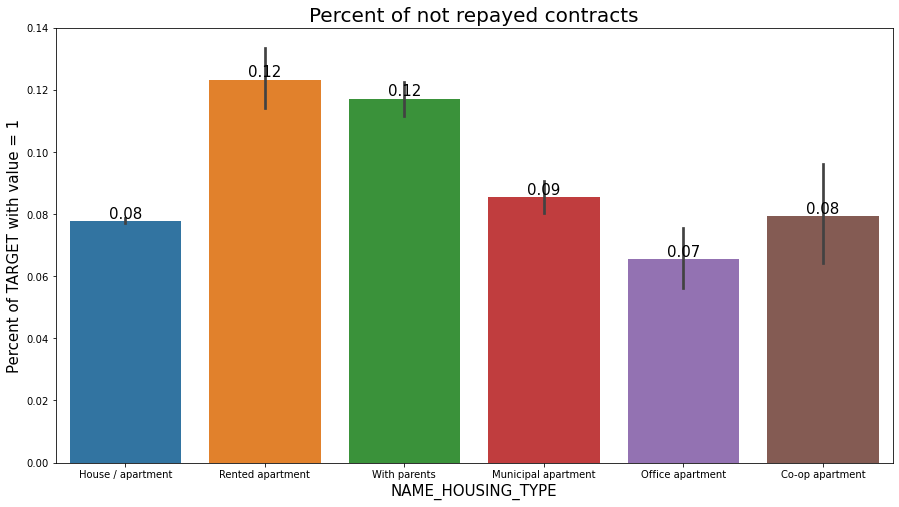

In [34]:
plt_barsstats(df_train, 'NAME_HOUSING_TYPE')

We can observe that the most of the persons which is 89% owning a house/appartment has loan contracts. 
8% of loan contracts with persons that own a house/appartment are not repayed.

### Family status & number of childrens

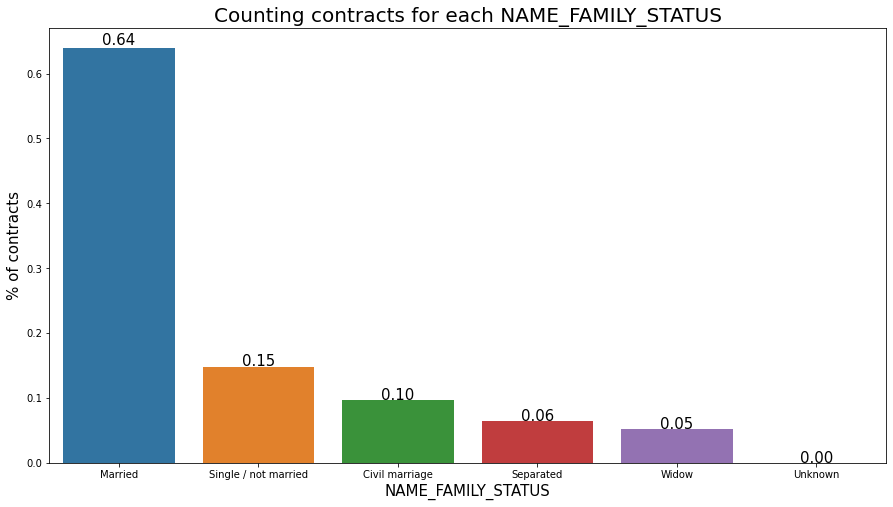

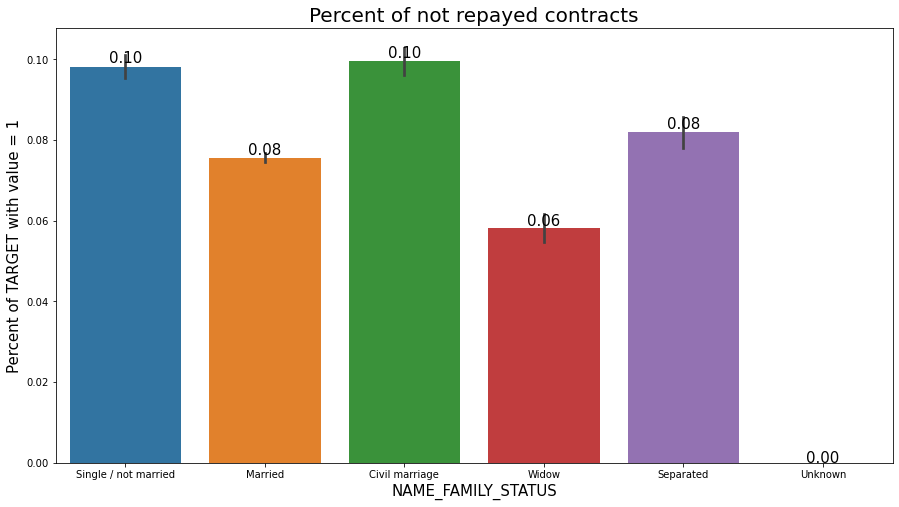

In [35]:
plt_barsstats(df_train, 'NAME_FAMILY_STATUS')

We can see that the most contracts are made by the clients with married status with about 64%, followed by the single and civil marriage with about 15% and 10% respectivelly. Also we say that the single and the civil marriage are more contracts that not repayment with 10% than thoose with married status.

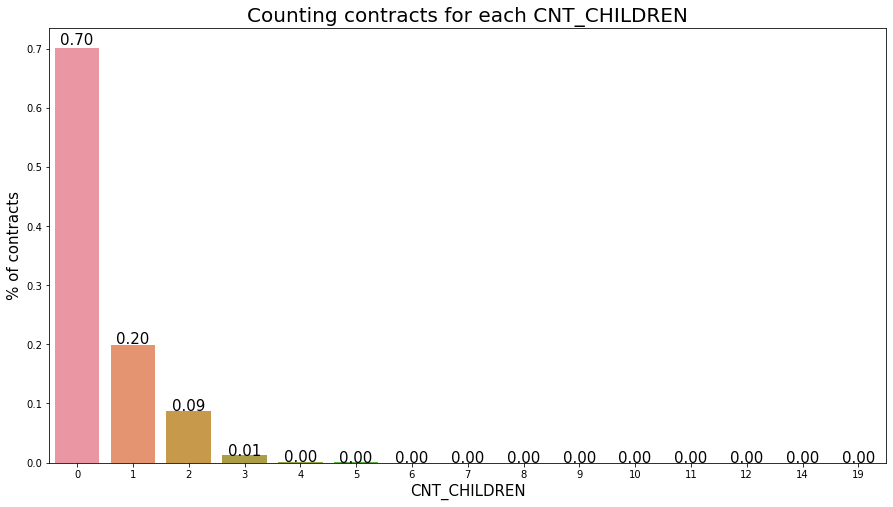

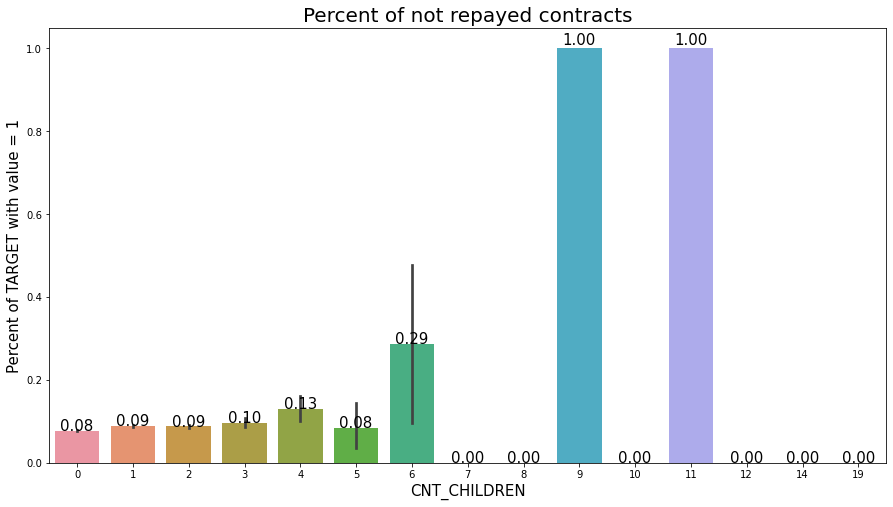

In [36]:
plt_barsstats(df_train, 'CNT_CHILDREN')

Most clients with loan contracts have no children. Theese are 70% of contracts. Thoose that are with 1, 2 and 3 childrens are with 20%, 9% and 1% respectivelly.

One can observe that families with 9 and 11 childers have loans not repayed, despite the families with 0, 1, 2, 3 and 5 childrens that have 10% of not repayed loans. Families with 6 childrens have 28% of loan contracts not repayed.

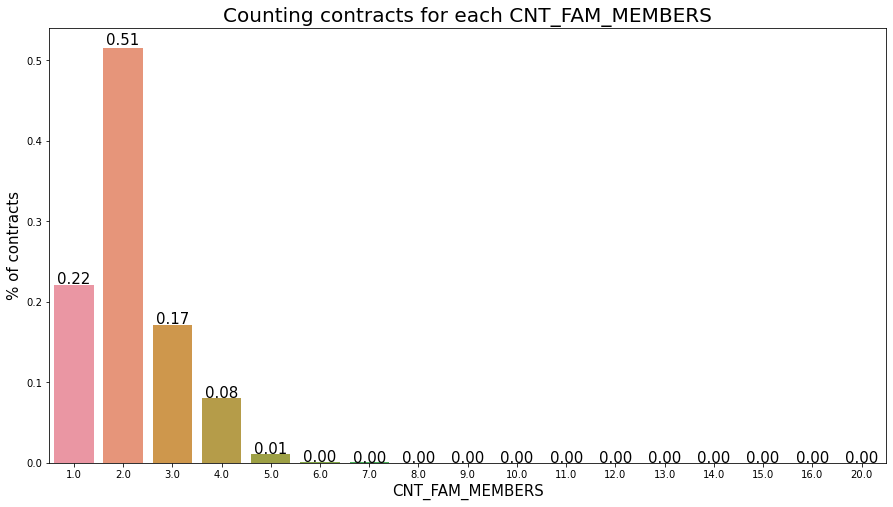

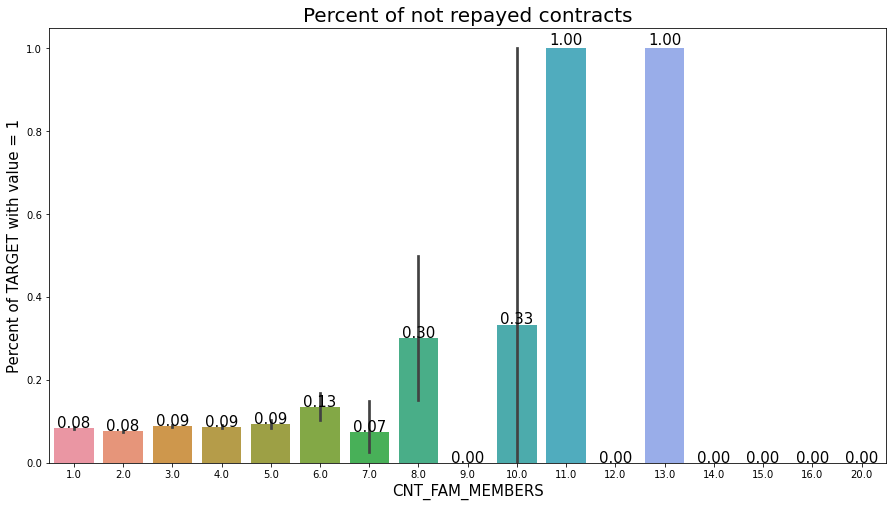

In [37]:
plt_barsstats(df_train, 'CNT_FAM_MEMBERS')

We see a consistence with the number of childrens in the familly. Thoose that are with 11 and 13 members in family are with 100% loans not repayed.

## Examine outliers and describing the linking datasets

### Application dataset

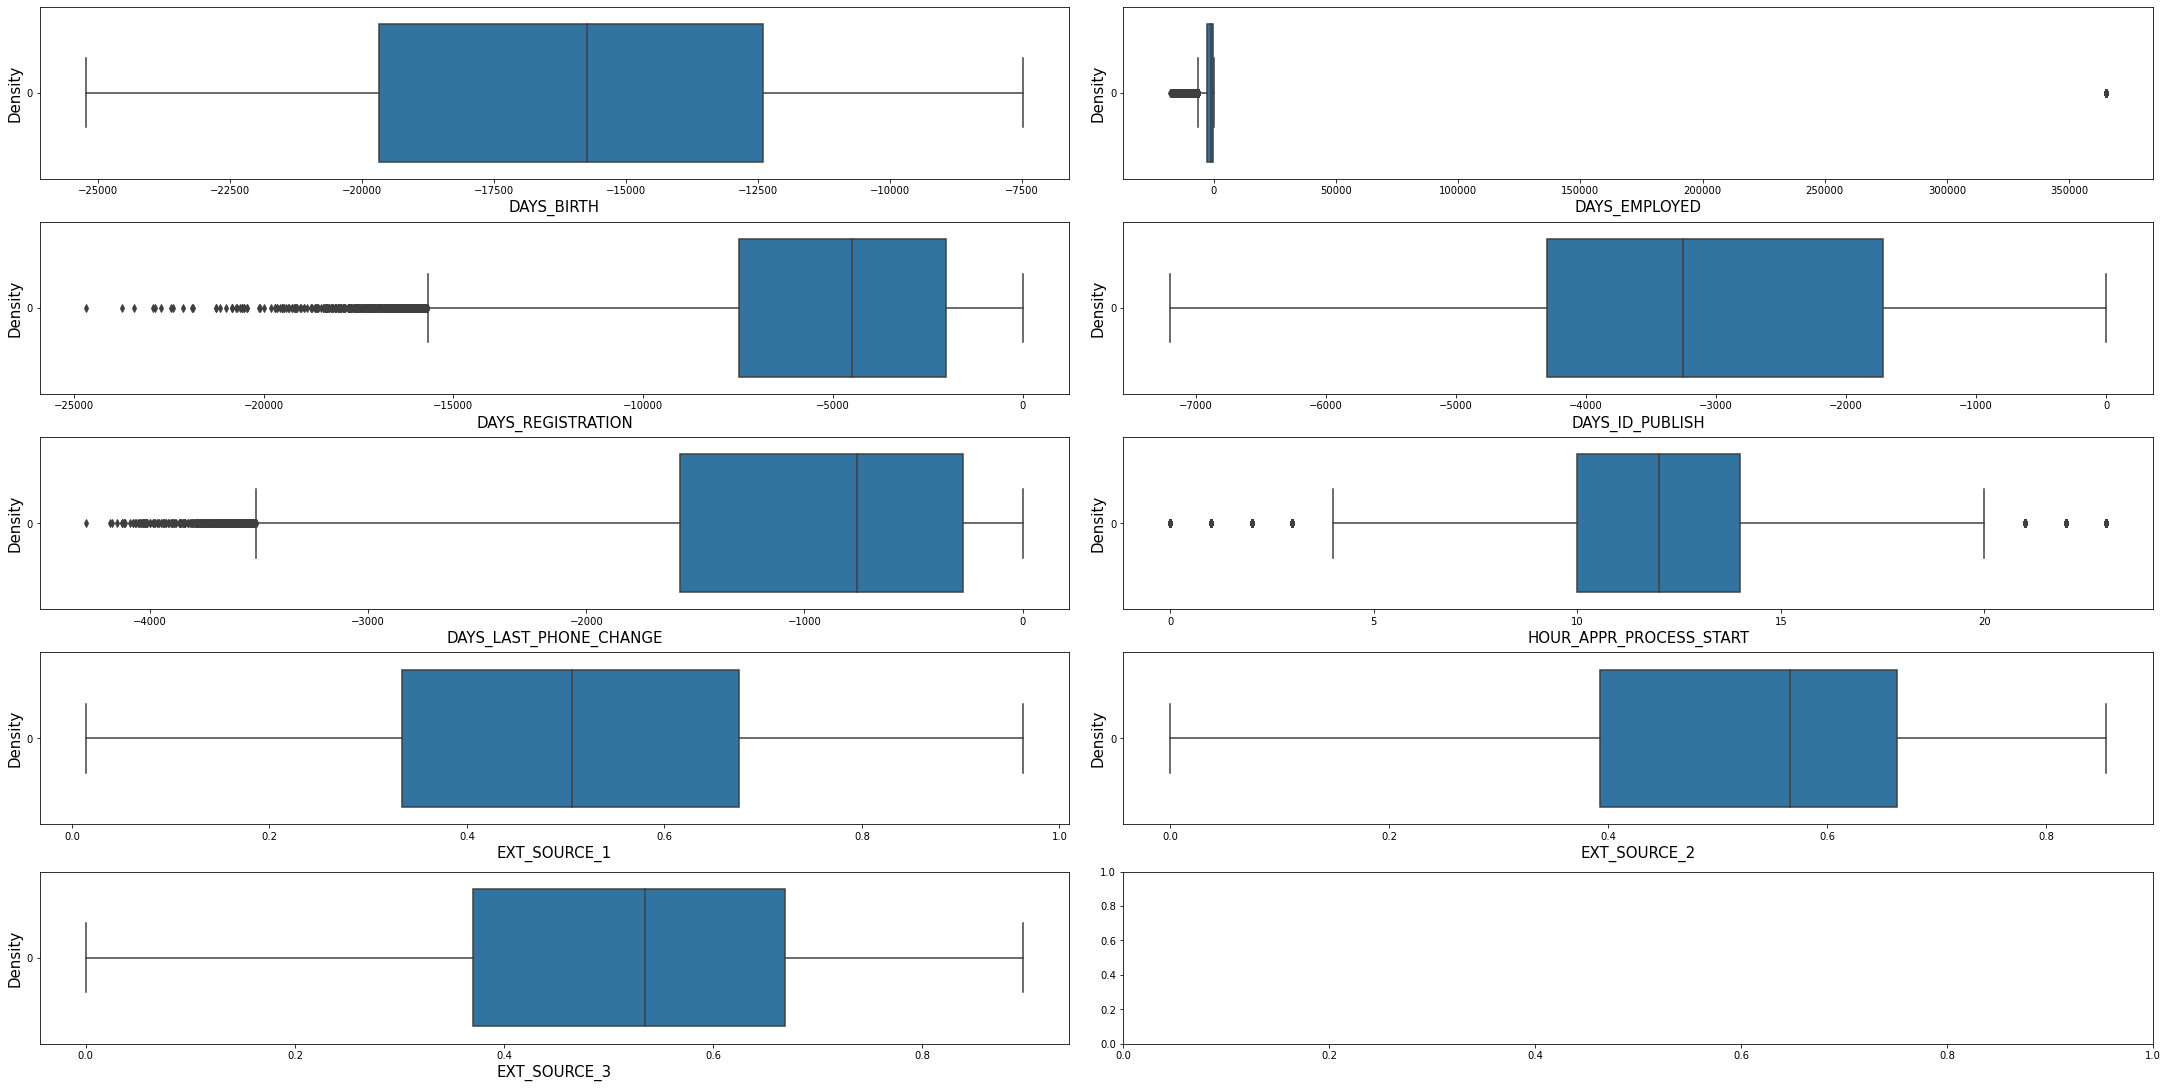

In [38]:
cols = ['DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE',
       'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3']

plot_density(df_train, columns = cols, dt = DensityTypes.Boxplot)

The numbers in the `DAYS_BIRTH` column are negative because they are recorded relative to the current loan application.  We can see an outlier in the`DAYS_EMPLOYED`, the value being approximative 100years. We see a normal distribution hear for `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`. Theese values seeams to be ok.

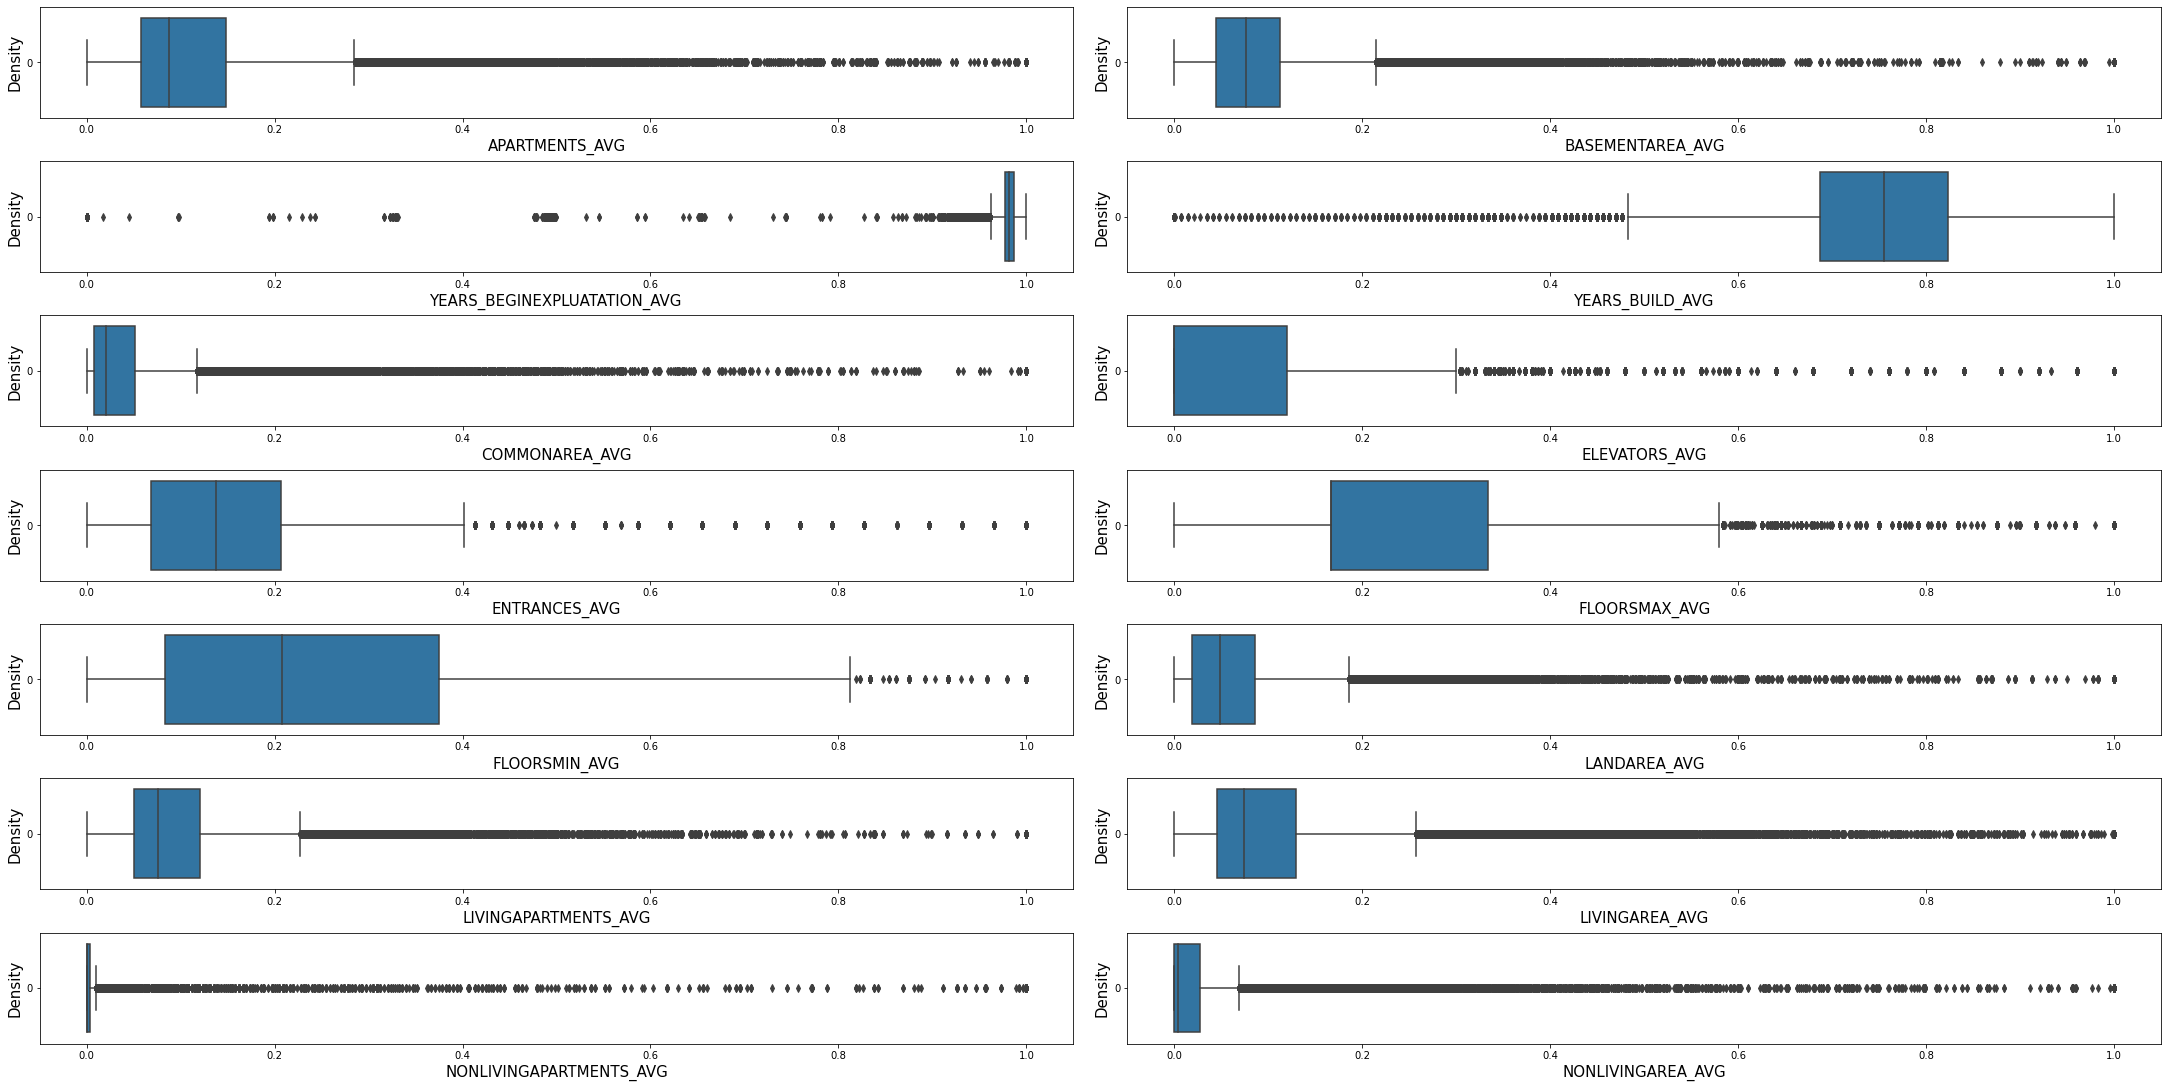

In [39]:
cols = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']
plot_density(df_train, columns = cols, dt = DensityTypes.Boxplot)

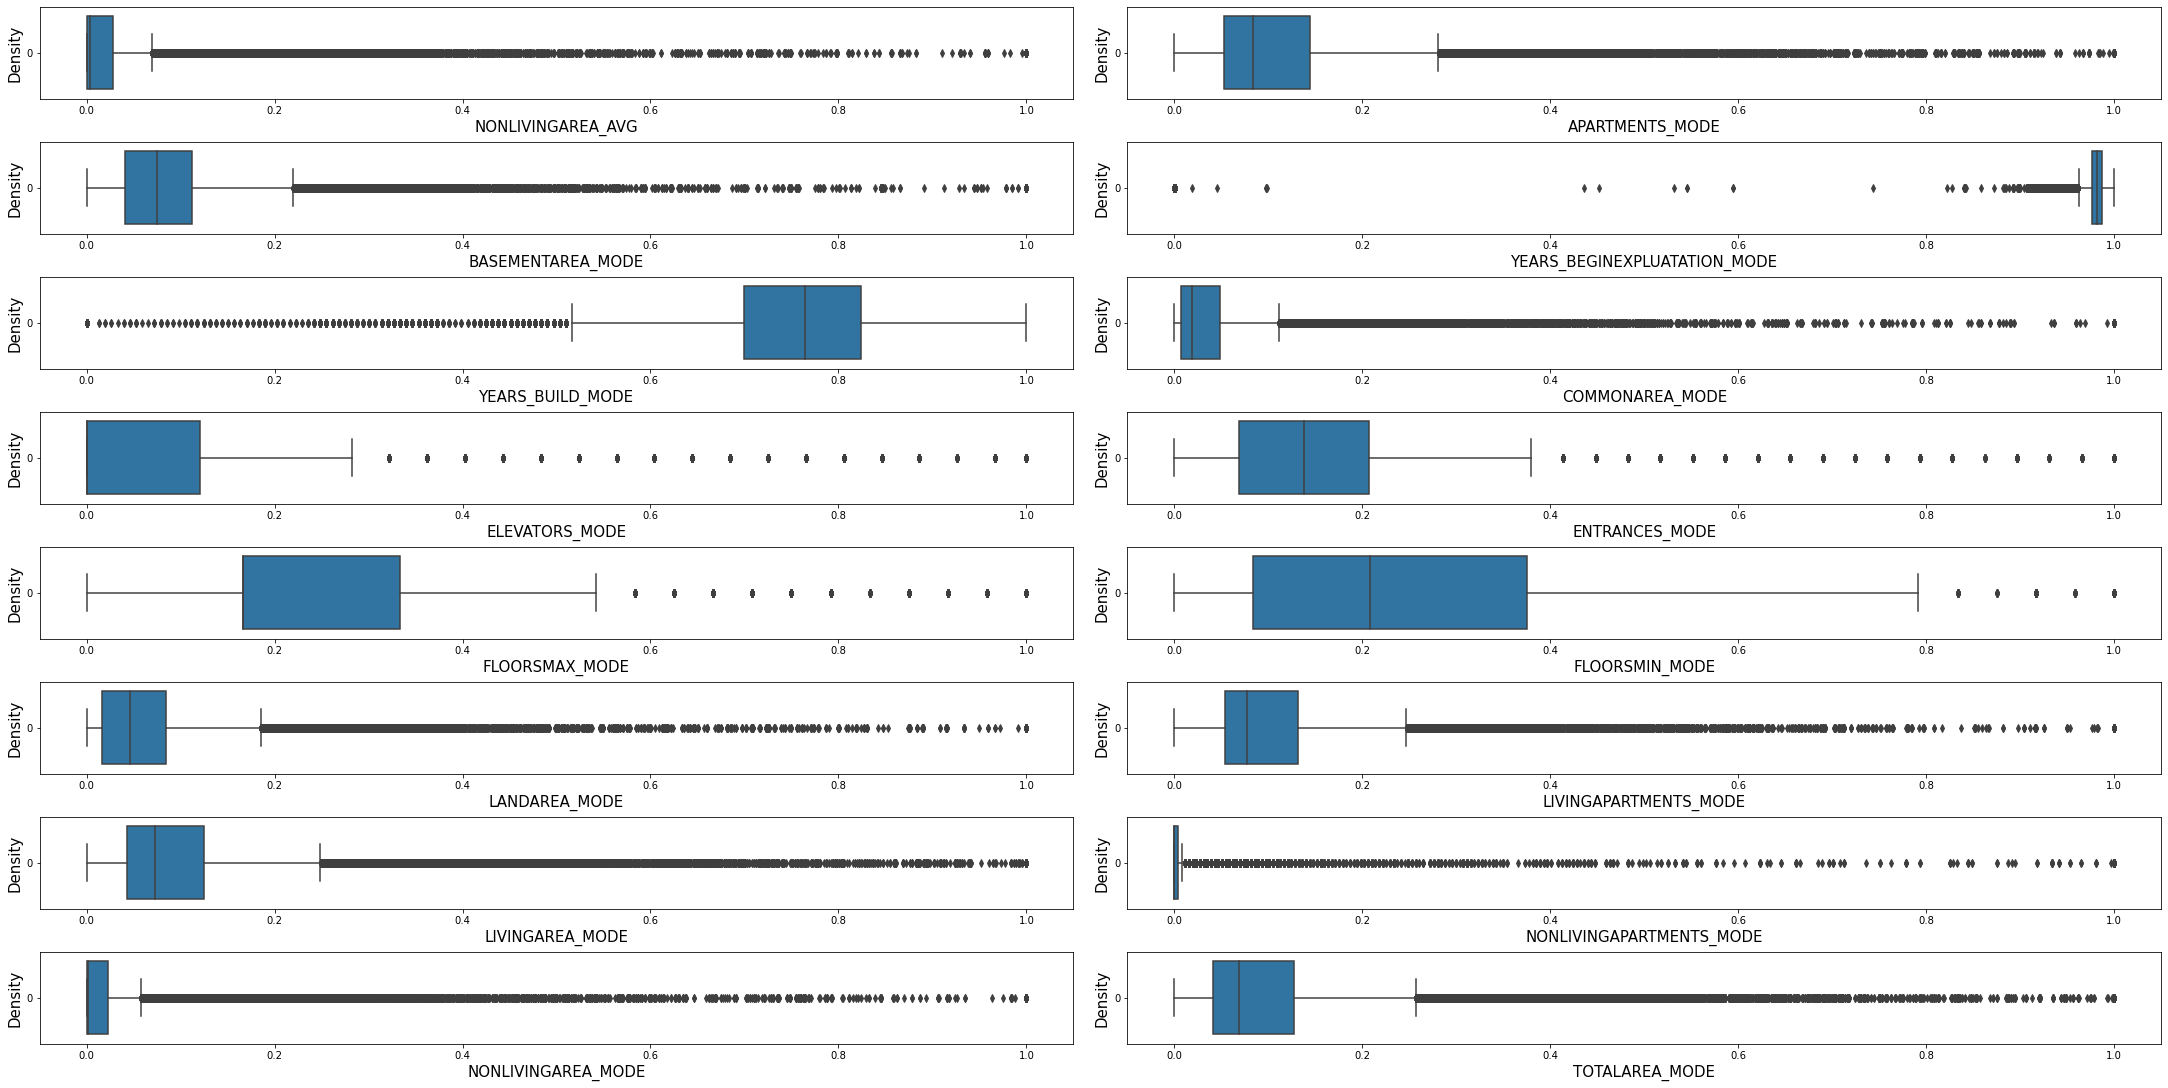

In [40]:
cols = ['NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'TOTALAREA_MODE']
plot_density(df_train, columns = cols, dt = DensityTypes.Boxplot)

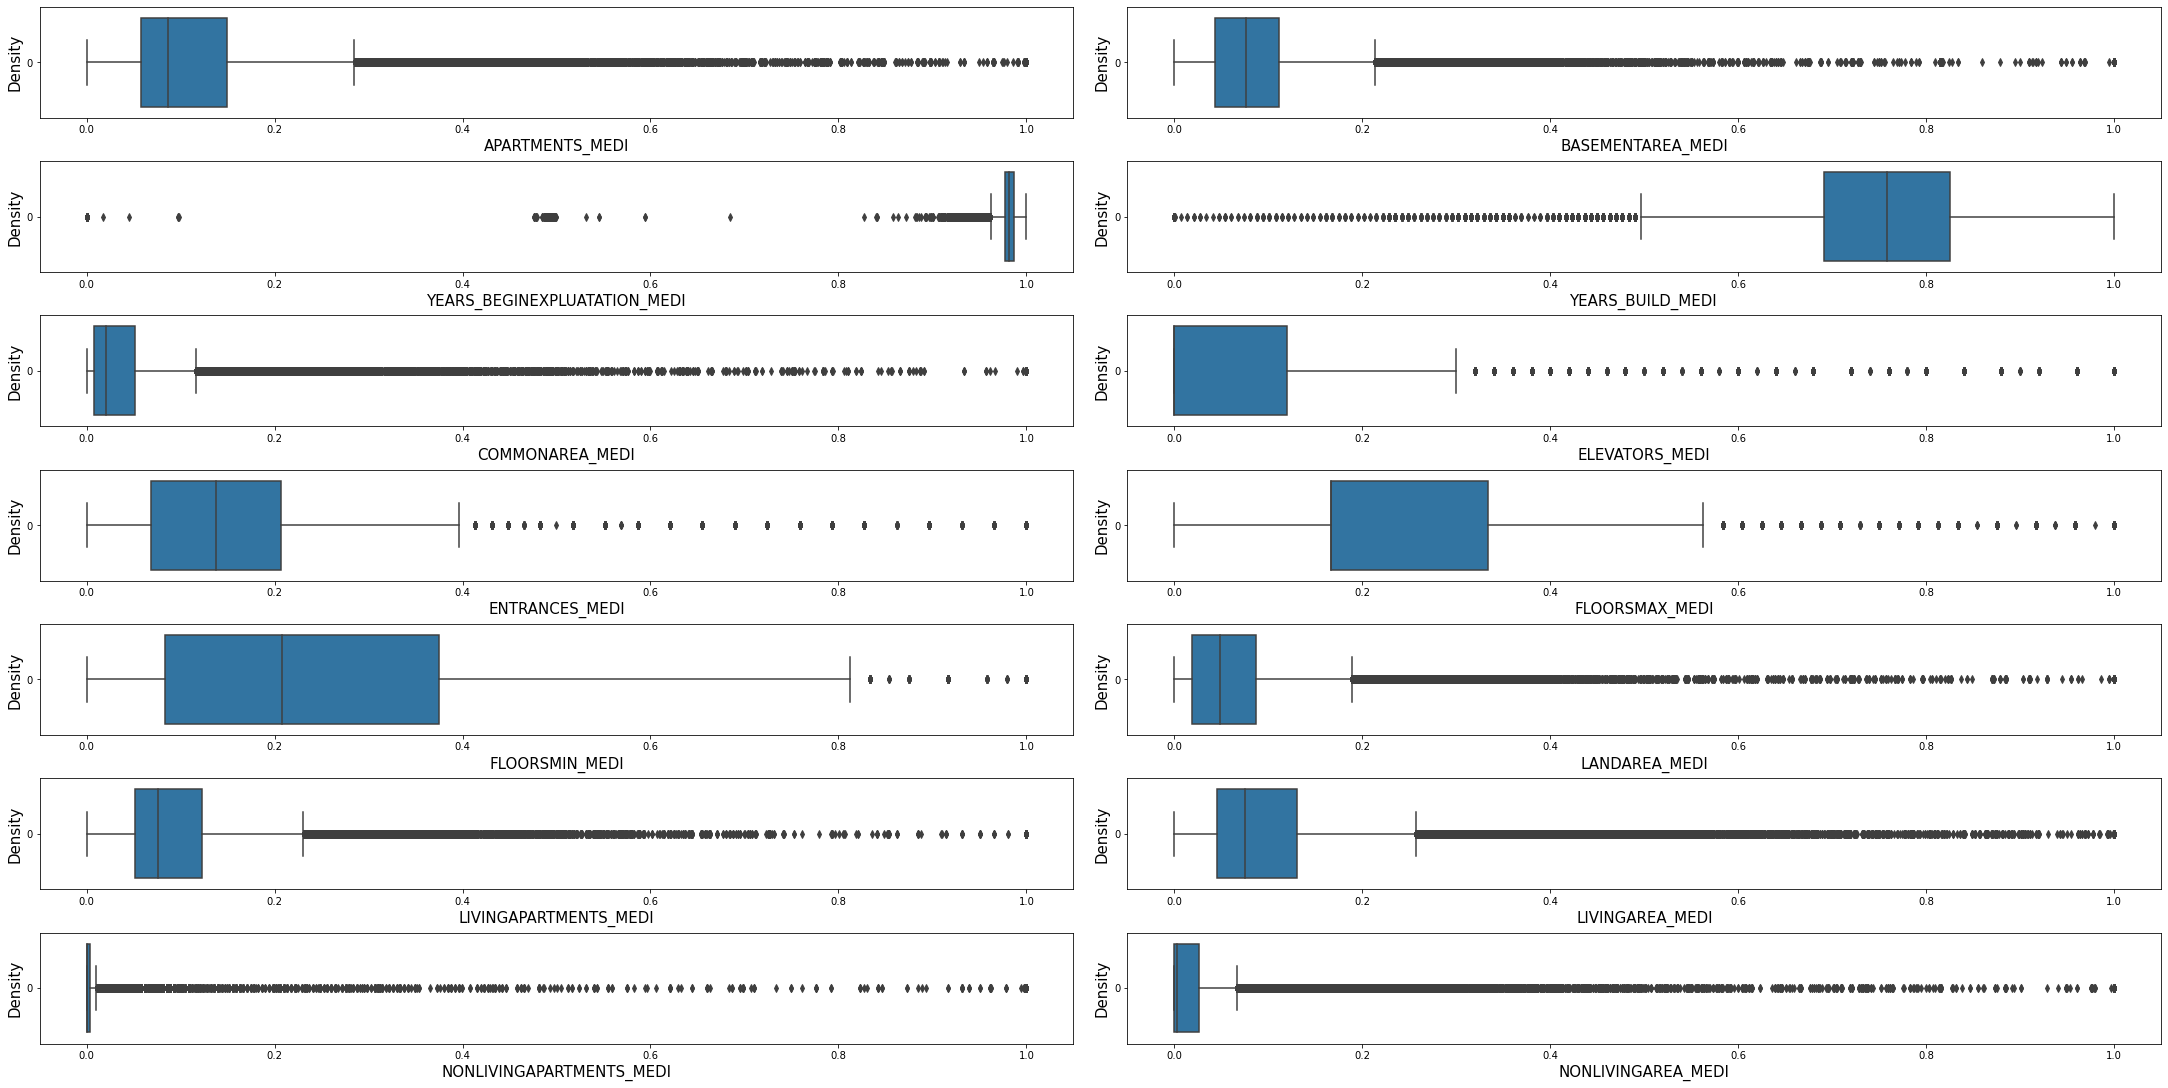

In [41]:
cols = ['APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
       'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI']
plot_density(df_train, columns = cols, dt = DensityTypes.Boxplot)

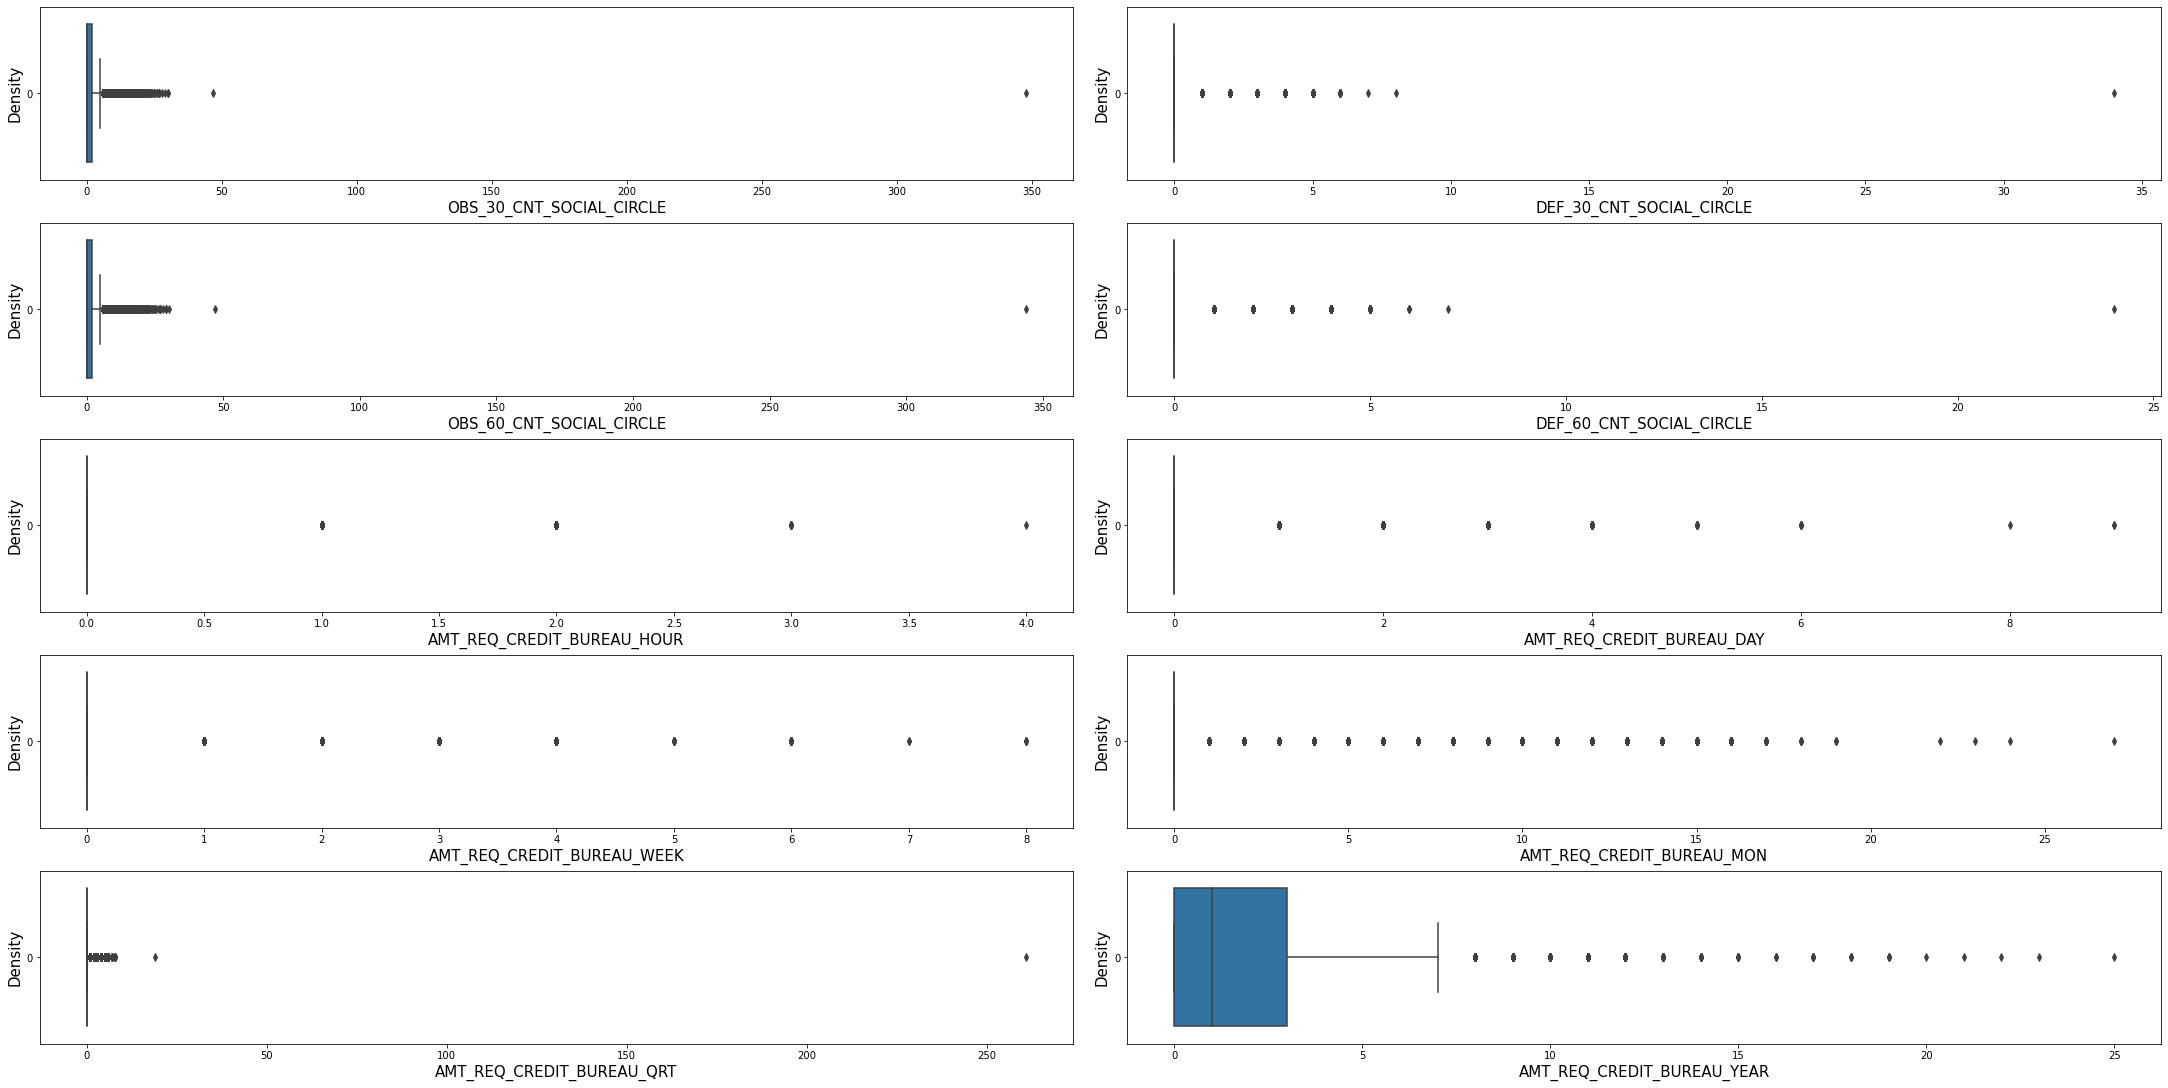

In [42]:
cols = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
plot_density(df_train, columns = cols, dt = DensityTypes.Boxplot)

In previous boxplots I do not observe values that are not in permissed range. The one with 350 social circle observation count seems to me a little strange, but I propose to let it remain.

Next the bureau dataset is analysed, joining it with the application dataset.

### Bureau dataset

Bureau data consists of client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

In [43]:
df_bureau.describe()

SK_ID_CURR  SK_ID_BUREAU   DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
count  1.716428e+06  1.716428e+06  1.716428e+06        1.716428e+06   
mean   2.782149e+05  5.924434e+06 -1.142108e+03        8.181666e-01   
std    1.029386e+05  5.322657e+05  7.951649e+02        3.654443e+01   
min    1.000010e+05  5.000000e+06 -2.922000e+03        0.000000e+00   
25%    1.888668e+05  5.463954e+06 -1.666000e+03        0.000000e+00   
50%    2.780550e+05  5.926304e+06 -9.870000e+02        0.000000e+00   
75%    3.674260e+05  6.385681e+06 -4.740000e+02        0.000000e+00   
max    4.562550e+05  6.843457e+06  0.000000e+00        2.792000e+03   

       DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
count         1.610875e+06       1.082775e+06            5.919400e+05   
mean          5.105174e+02      -1.017437e+03            3.825418e+03   
std           4.994220e+03       7.140106e+02            2.060316e+05   
min          -4.206000e+04      -4.202300e+04            0.000000e+00   
25%          -1.138000e+03      -1.489000e+03            0.000000e+00   
50%          -3.300000e+02      -8.970000e+02            0.000000e+00   
75%           4.740000e+02      -4.250000e+02            0.000000e+00   
max           3.119900e+04       0.000000e+00            1.159872e+08   

       CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
count        1.716428e+06    1.716415e+06         1.458759e+06   
mean         6.410406e-03    3.549946e+05         1.370851e+05   
std          9.622391e-02    1.149811e+06         6.774011e+05   
min          0.000000e+00    0.000000e+00        -4.705600e+06   
25%          0.000000e+00    5.130000e+04         0.000000e+00   
50%          0.000000e+00    1.255185e+05         0.000000e+00   
75%          0.000000e+00    3.150000e+05         4.015350e+04   
max          9.000000e+00    5.850000e+08         1.701000e+08   

       AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  \
count          1.124648e+06            1.716428e+06        1.716428e+06   
mean           6.229515e+03            3.791276e+01       -5.937483e+02   
std            4.503203e+04            5.937650e+03        7.207473e+02   
min           -5.864061e+05            0.000000e+00       -4.194700e+04   
25%            0.000000e+00            0.000000e+00       -9.080000e+02   
50%            0.000000e+00            0.000000e+00       -3.950000e+02   
75%            0.000000e+00            0.000000e+00       -3.300000e+01   
max            4.705600e+06            3.756681e+06        3.720000e+02   

        AMT_ANNUITY  
count  4.896370e+05  
mean   1.571276e+04  
std    3.258269e+05  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    1.350000e+04  
max    1.184534e+08

In [44]:
df_bureau.describe(include=[object])

CREDIT_ACTIVE CREDIT_CURRENCY      CREDIT_TYPE
count        1716428         1716428          1716428
unique             4               4               15
top           Closed      currency 1  Consumer credit
freq         1079273         1715020          1251615

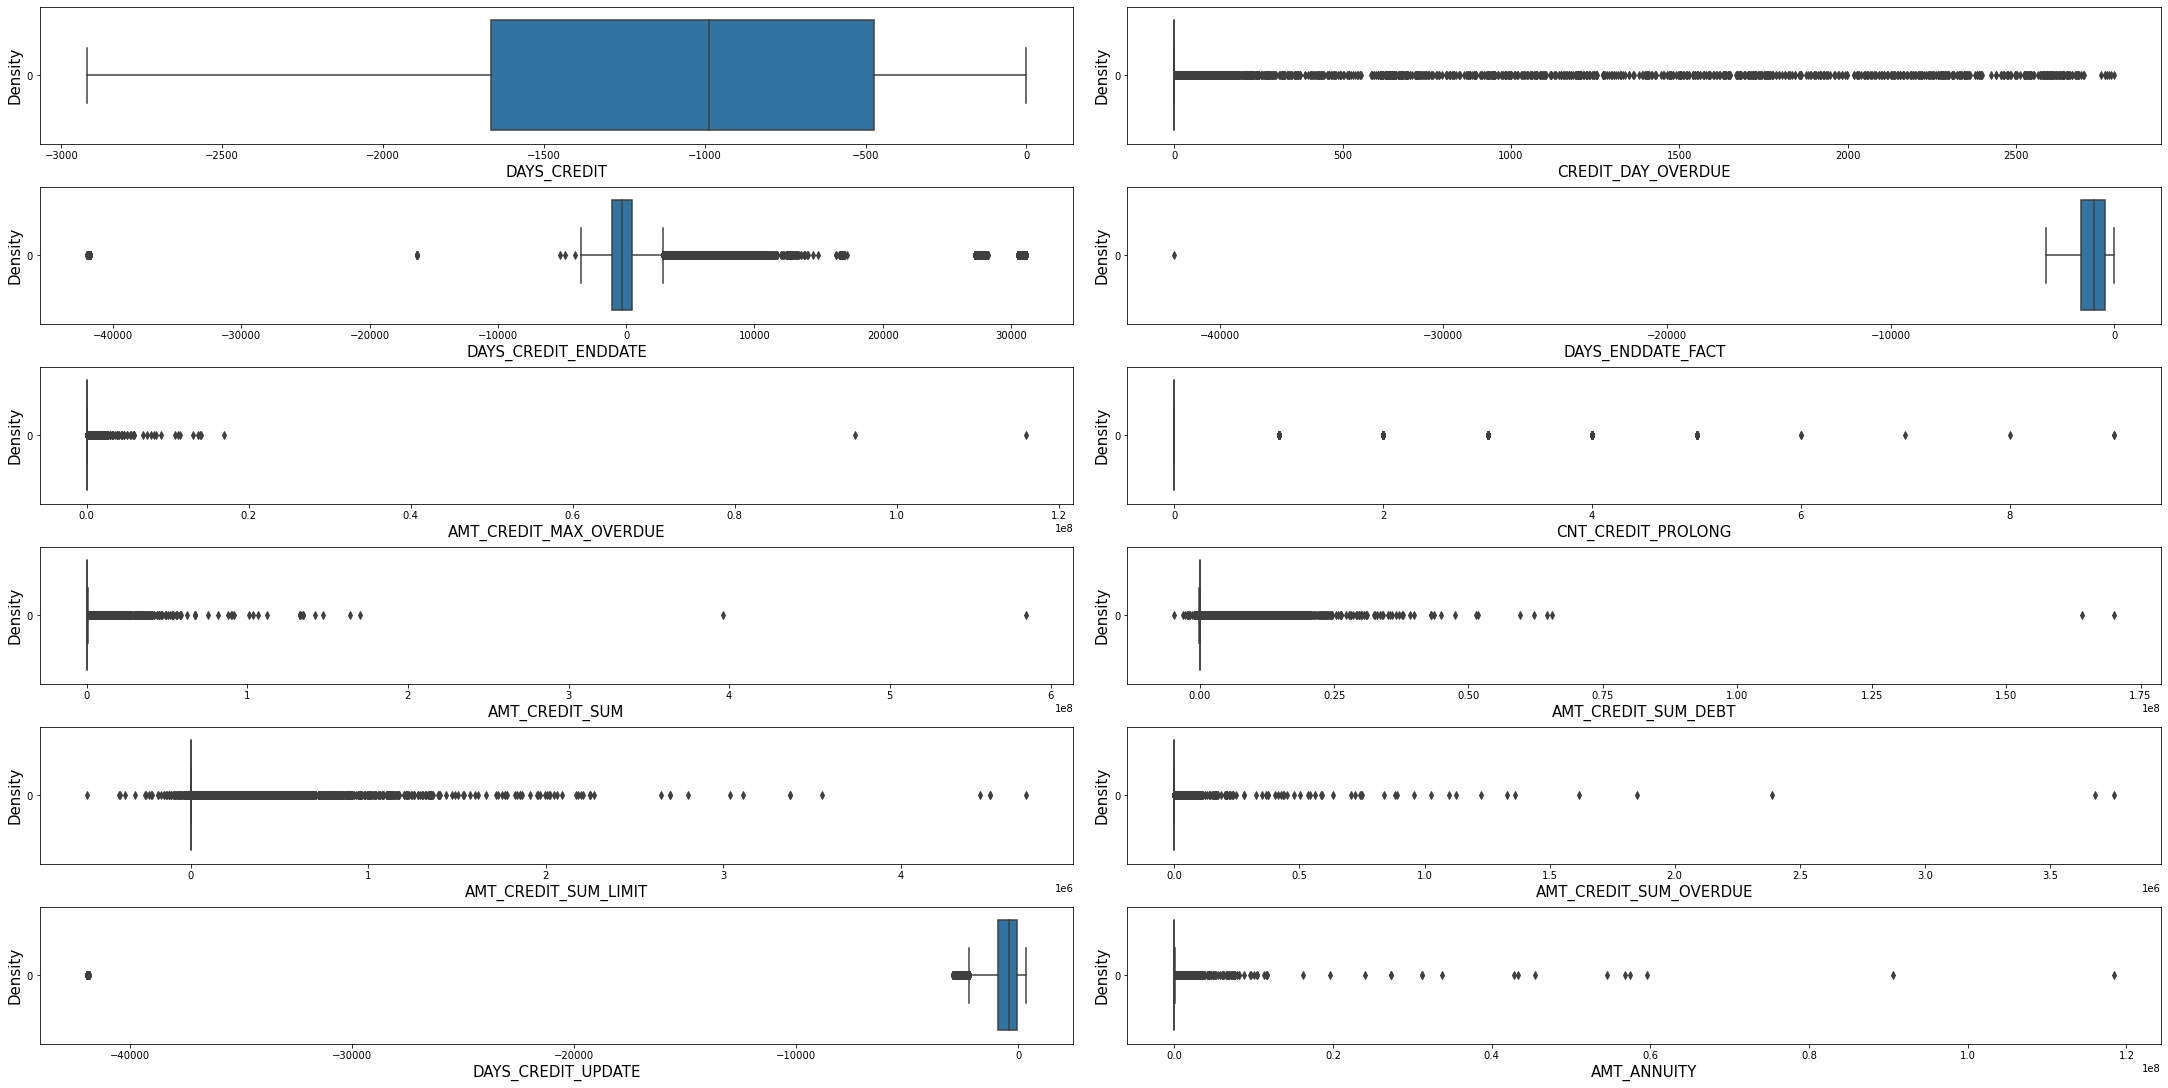

In [45]:
cols = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY']
plot_density(df_bureau, columns = cols, dt = DensityTypes.Boxplot)

`DAYS_CREDIT_ENDDAT` is a little bit strange having a minimum value of -118 days, that is more then 100 years. I will uppose that this kind of credit is possible. We also have positive values. I am not sure what theese values means, but I think it is the payed loans. I see some positive and negative values in  `AMT_CREDIT_SUM_DEB`. I am not a specialist in the bank domain, but I suppose that the positive values are the debt of the client and the negative values are the bank debt.The same think is for the `AMT_CREDIT_SUM_LIMI`. So I think theese values can be good. A discussion with a specialist could help to understand better the speciality.

Speaking about the outliers values, that I find a little bit strange. First note that in the `DAYS_CREDIT_UPDAT` we have just one positive value that is equal to 372 (the positive information can tell here about the future that is not logic in this situation). For know I am not sure what that means but I will suppose it as an outlier for future analysis. Also `DAYS_CREDIT_UPDAT` has a minimal value of -41947 that is also taken as an outlier in my analyse (more then 100 years before loan application did last information about the Credit Bureau credit come seems to be irelevant). Finally the `DAYS_ENDDATE_FAC` with the minimum value equal to -42023 seems to be also irelavat.

### Bureau balance

In [46]:
df_bureau_balance.describe()

SK_ID_BUREAU  MONTHS_BALANCE
count  2.729992e+07    2.729992e+07
mean   6.036297e+06   -3.074169e+01
std    4.923489e+05    2.386451e+01
min    5.001709e+06   -9.600000e+01
25%    5.730933e+06   -4.600000e+01
50%    6.070821e+06   -2.500000e+01
75%    6.431951e+06   -1.100000e+01
max    6.842888e+06    0.000000e+00

In [47]:
df_bureau_balance.describe(include=[object])

STATUS
count   27299925
unique         8
top            C
freq    13646993

***What statuses in Credit Bureau during the mounth and how much of them?***

 - C means closed
 - X means status unknown
 - 0 means no DPD
 - 1 means maximal did during month between 1-30
 - 2 means DPD 31-60,
 - … 
 - 5 means DPD 120+ or sold or written off

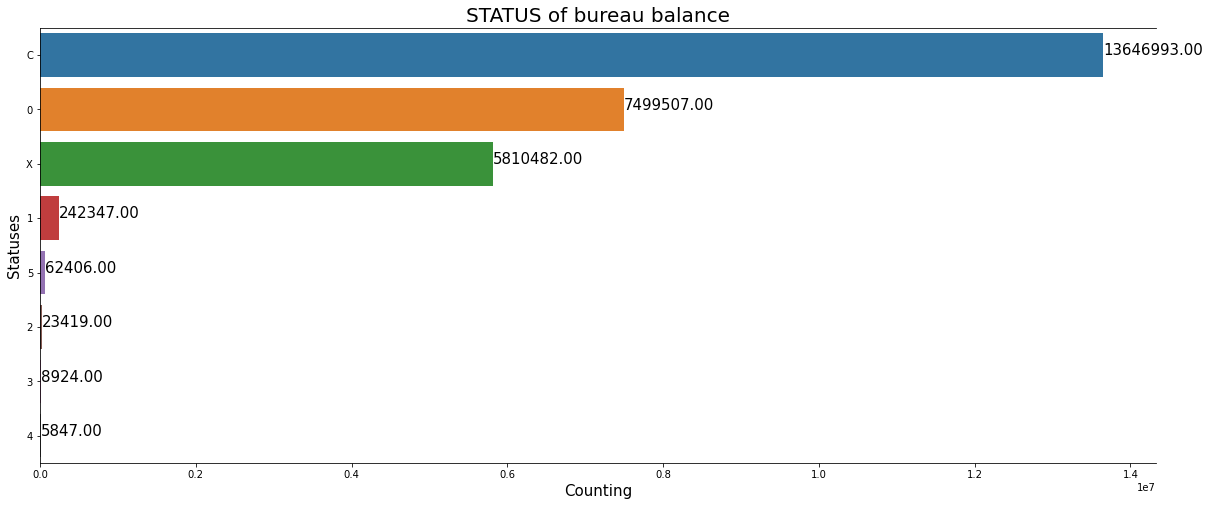

In [48]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=df_bureau_balance.STATUS.value_counts(), y=df_bureau_balance.STATUS.value_counts().index, data=df_bureau_balance);
show_values(ax, orient="h")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
plt.title('STATUS of bureau balance', fontsize=20);
plt.xlabel('Counting', fontsize=15);
plt.ylabel('Statuses', fontsize=15);
plt.show();

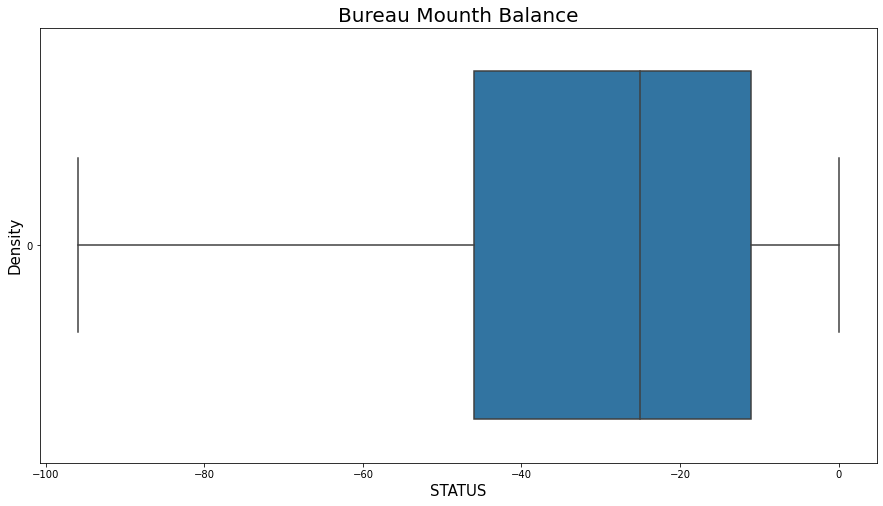

In [49]:
plt.figure(figsize=(15,8))
sns.boxplot(data = df_bureau_balance.MONTHS_BALANCE, orient='h');
plt.title('Bureau Mounth Balance', fontsize=20);
plt.xlabel('STATUS', fontsize=15);
plt.ylabel('Density', fontsize=15);
plt.show();

No outliers is observed.

### Credit card balance

In [50]:
df_credit_card_balance.describe()

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE   AMT_BALANCE  \
count  3.840312e+06  3.840312e+06    3.840312e+06  3.840312e+06   
mean   1.904504e+06  2.783242e+05   -3.452192e+01  5.830016e+04   
std    5.364695e+05  1.027045e+05    2.666775e+01  1.063070e+05   
min    1.000018e+06  1.000060e+05   -9.600000e+01 -4.202502e+05   
25%    1.434385e+06  1.895170e+05   -5.500000e+01  0.000000e+00   
50%    1.897122e+06  2.783960e+05   -2.800000e+01  0.000000e+00   
75%    2.369328e+06  3.675800e+05   -1.100000e+01  8.904669e+04   
max    2.843496e+06  4.562500e+05   -1.000000e+00  1.505902e+06   

       AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
count             3.840312e+06              3.090496e+06   
mean              1.538080e+05              5.961325e+03   
std               1.651457e+05              2.822569e+04   
min               0.000000e+00             -6.827310e+03   
25%               4.500000e+04              0.000000e+00   
50%               1.125000e+05              0.000000e+00   
75%               1.800000e+05              0.000000e+00   
max               1.350000e+06              2.115000e+06   

       AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
count          3.840312e+06                3.090496e+06   
mean           7.433388e+03                2.881696e+02   
std            3.384608e+04                8.201989e+03   
min           -6.211620e+03                0.000000e+00   
25%            0.000000e+00                0.000000e+00   
50%            0.000000e+00                0.000000e+00   
75%            0.000000e+00                0.000000e+00   
max            2.287098e+06                1.529847e+06   

       AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  \
count              3.090496e+06             3.535076e+06  ...   
mean               2.968805e+03             3.540204e+03  ...   
std                2.079689e+04             5.600154e+03  ...   
min                0.000000e+00             0.000000e+00  ...   
25%                0.000000e+00             0.000000e+00  ...   
50%                0.000000e+00             0.000000e+00  ...   
75%                0.000000e+00             6.633911e+03  ...   
max                2.239274e+06             2.028820e+05  ...   

       AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
count              3.840312e+06   3.840312e+06          3.840312e+06   
mean               5.596588e+04   5.808881e+04          5.809829e+04   
std                1.025336e+05   1.059654e+05          1.059718e+05   
min               -4.233058e+05  -4.202502e+05         -4.202502e+05   
25%                0.000000e+00   0.000000e+00          0.000000e+00   
50%                0.000000e+00   0.000000e+00          0.000000e+00   
75%                8.535924e+04   8.889949e+04          8.891451e+04   
max                1.472317e+06   1.493338e+06          1.493338e+06   

       CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count              3.090496e+06          3.840312e+06   
mean               3.094490e-01          7.031439e-01   
std                1.100401e+00          3.190347e+00   
min                0.000000e+00          0.000000e+00   
25%                0.000000e+00          0.000000e+00   
50%                0.000000e+00          0.000000e+00   
75%                0.000000e+00          0.000000e+00   
max                5.100000e+01          1.650000e+02   

       CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
count                3.090496e+06              3.090496e+06   
mean                 4.812496e-03              5.594791e-01   
std                  8.263861e-02              3.240649e+00   
min                  0.000000e+00              0.000000e+00   
25%                  0.000000e+00              0.000000e+00   
50%                  0.000000e+00              0.000000e+00   
75%                  0.000000e+00              0.000000e+00   
max                  1.200000e+01              1.650000e+02   

       CNT_INST

In [51]:
df_credit_card_balance.describe(include=[object])

NAME_CONTRACT_STATUS
count               3840312
unique                    7
top                  Active
freq                3698436

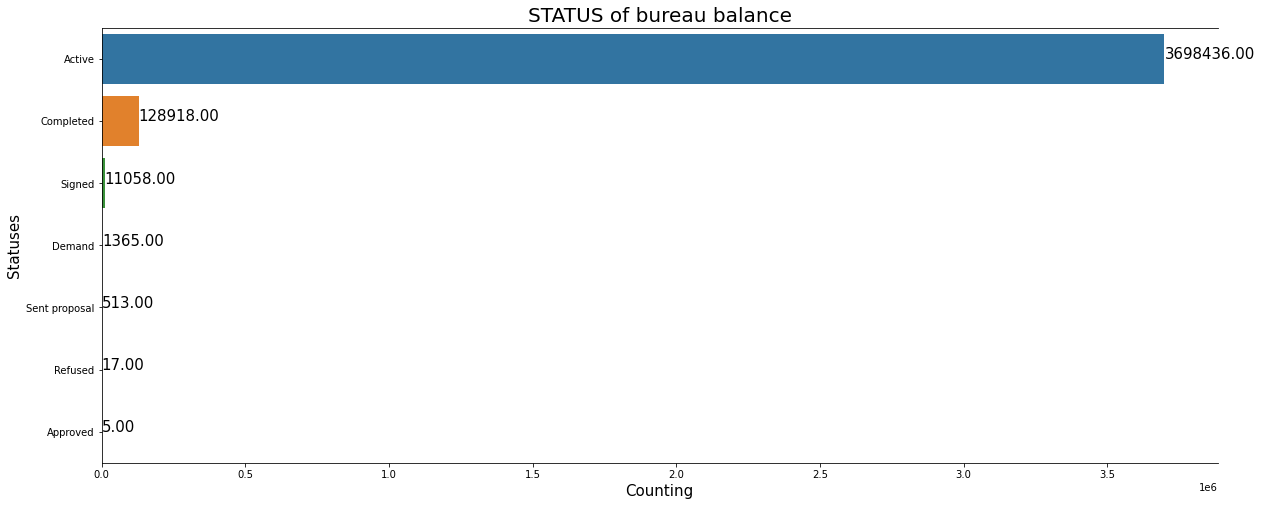

In [52]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=df_credit_card_balance.NAME_CONTRACT_STATUS.value_counts(), y=df_credit_card_balance.NAME_CONTRACT_STATUS.value_counts().index, data=df_credit_card_balance);
show_values(ax, orient="h")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
plt.title('STATUS of bureau balance', fontsize=20);
plt.xlabel('Counting', fontsize=15);
plt.ylabel('Statuses', fontsize=15);
plt.show();

Observe that the most contract status on the previous credit are thoose of active status.

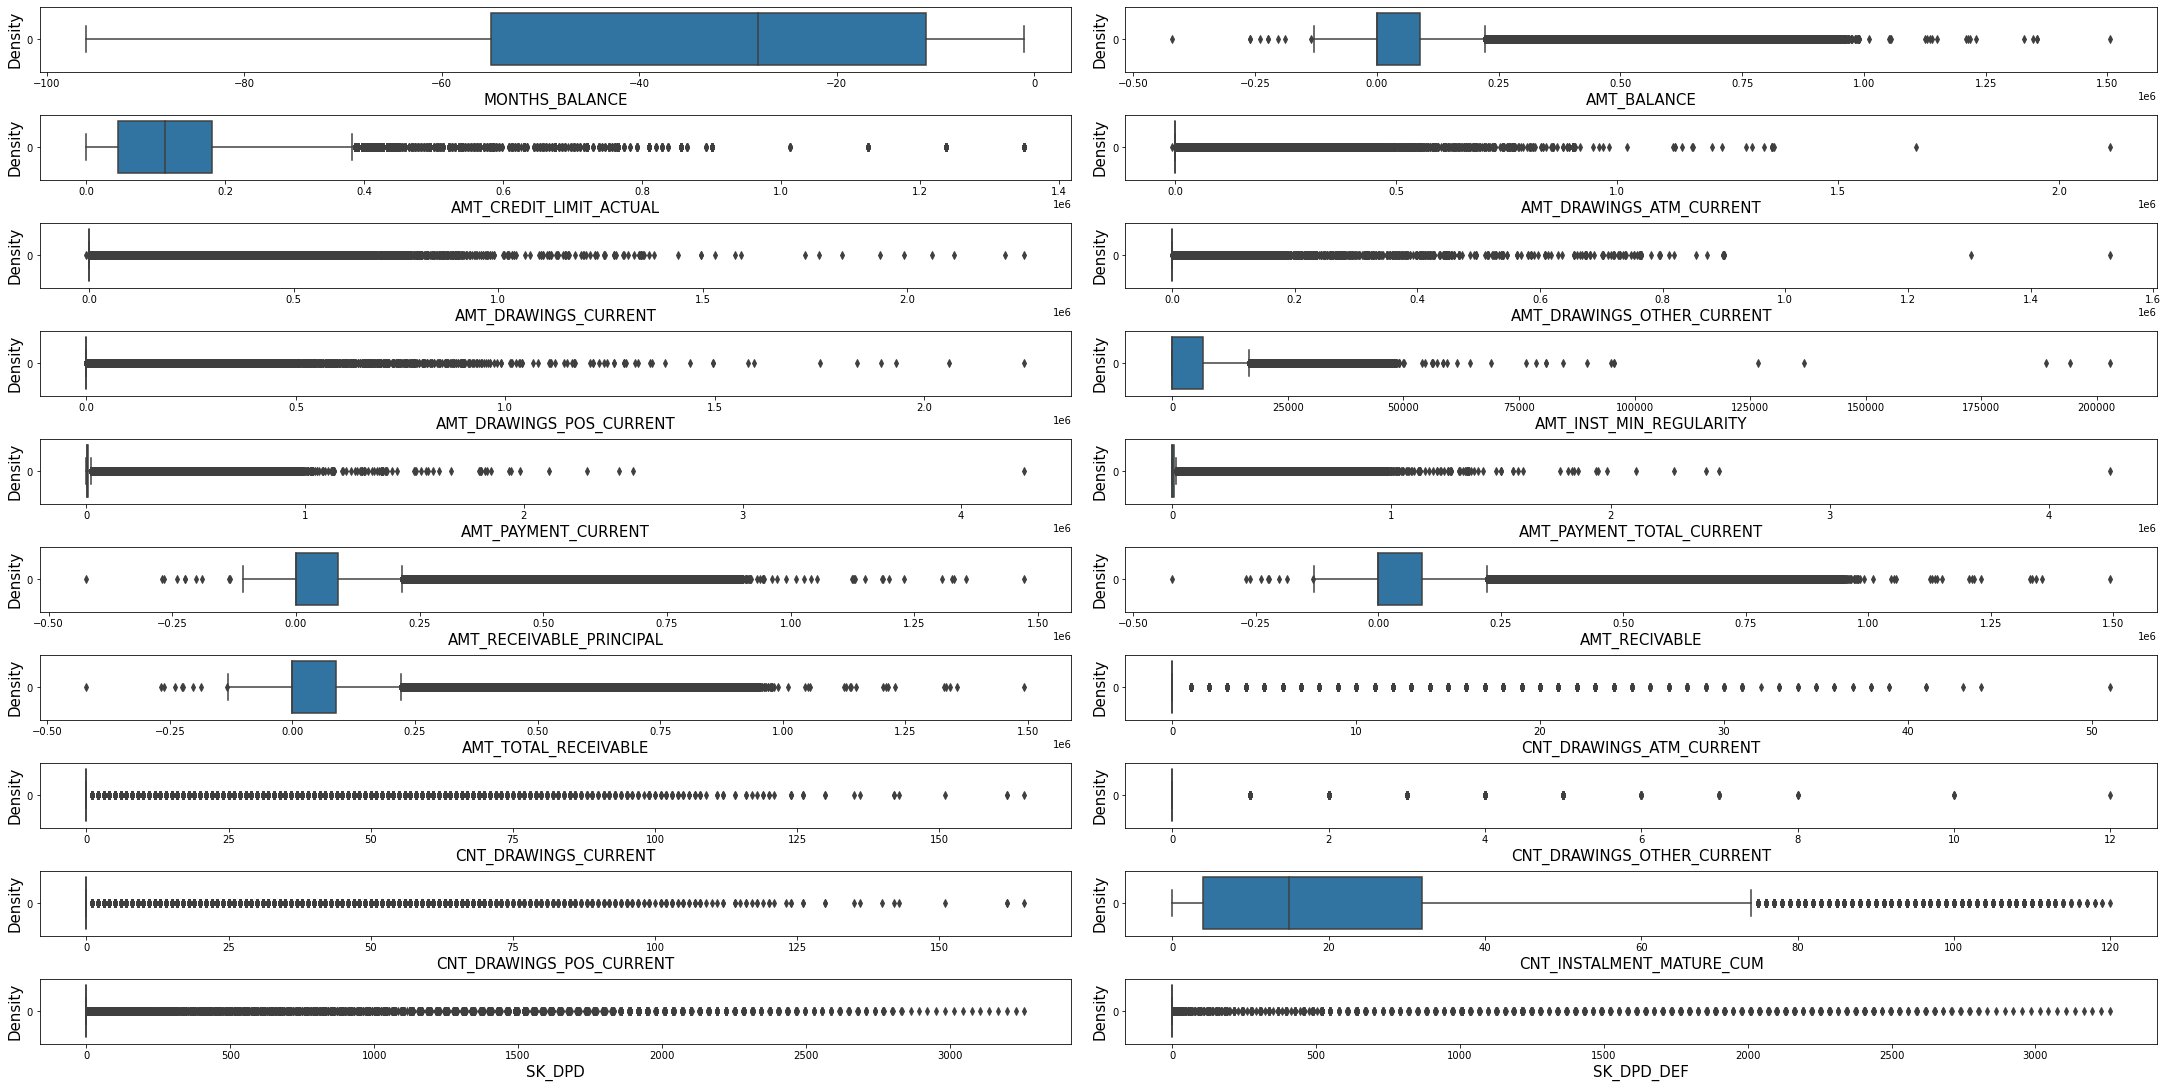

In [53]:
cols = ['MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD',
       'SK_DPD_DEF']
plot_density(df_credit_card_balance, columns = cols, dt = DensityTypes.Boxplot)

Here I do not observe some outliers. Everithing seems normal.

### Installments payment

In [54]:
df_installments_payments.describe()

SK_ID_PREV    SK_ID_CURR  NUM_INSTALMENT_VERSION  \
count  1.360540e+07  1.360540e+07            1.360540e+07   
mean   1.903365e+06  2.784449e+05            8.566373e-01   
std    5.362029e+05  1.027183e+05            1.035216e+00   
min    1.000001e+06  1.000010e+05            0.000000e+00   
25%    1.434191e+06  1.896390e+05            0.000000e+00   
50%    1.896520e+06  2.786850e+05            1.000000e+00   
75%    2.369094e+06  3.675300e+05            1.000000e+00   
max    2.843499e+06  4.562550e+05            1.780000e+02   

       NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
count           1.360540e+07     1.360540e+07        1.360250e+07   
mean            1.887090e+01    -1.042270e+03       -1.051114e+03   
std             2.666407e+01     8.009463e+02        8.005859e+02   
min             1.000000e+00    -2.922000e+03       -4.921000e+03   
25%             4.000000e+00    -1.654000e+03       -1.662000e+03   
50%             8.000000e+00    -8.180000e+02       -8.270000e+02   
75%             1.900000e+01    -3.610000e+02       -3.700000e+02   
max             2.770000e+02    -1.000000e+00       -1.000000e+00   

       AMT_INSTALMENT   AMT_PAYMENT  
count    1.360540e+07  1.360250e+07  
mean     1.705091e+04  1.723822e+04  
std      5.057025e+04  5.473578e+04  
min      0.000000e+00  0.000000e+00  
25%      4.226085e+03  3.398265e+03  
50%      8.884080e+03  8.125515e+03  
75%      1.671021e+04  1.610842e+04  
max      3.771488e+06  3.771488e+06

_`df_installments_payments` does not have categorical variables_

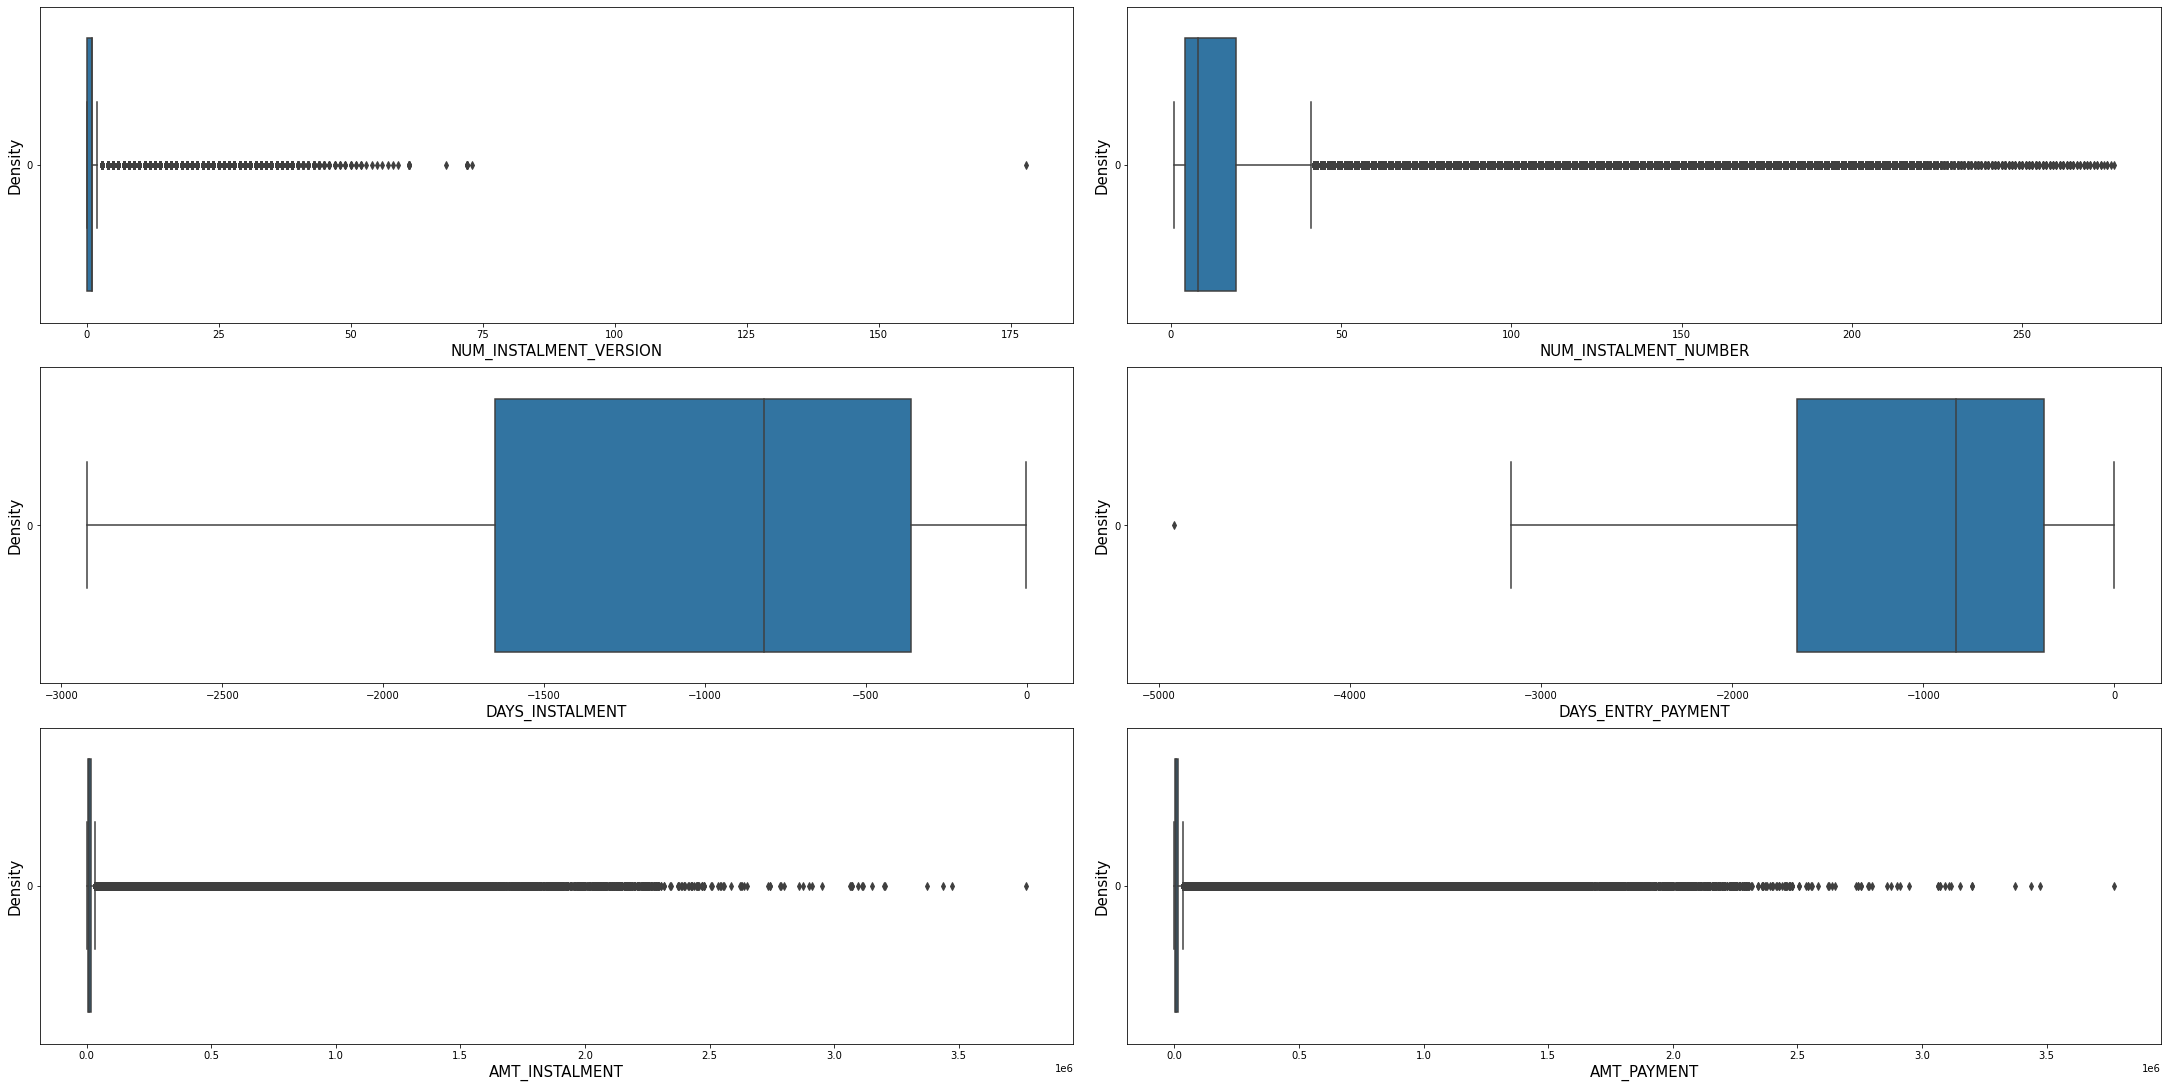

In [55]:
cols = ['NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT']
plot_density(df_installments_payments, columns = cols, dt = DensityTypes.Boxplot)

Eaven that in the previous figure we observe some non habituded values. It seems to be some acceptable values. Therefore no values are ommited here. However for filling the nan values may we make some attentions of theese values that are not habitude.

### POS Cash ballance

In [56]:
df_POS_CASH_balance.describe()

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
count  1.000136e+07  1.000136e+07    1.000136e+07    9.975287e+06   
mean   1.903217e+06  2.784039e+05   -3.501259e+01    1.708965e+01   
std    5.358465e+05  1.027637e+05    2.606657e+01    1.199506e+01   
min    1.000001e+06  1.000010e+05   -9.600000e+01    1.000000e+00   
25%    1.434405e+06  1.895500e+05   -5.400000e+01    1.000000e+01   
50%    1.896565e+06  2.786540e+05   -2.800000e+01    1.200000e+01   
75%    2.368963e+06  3.674290e+05   -1.300000e+01    2.400000e+01   
max    2.843499e+06  4.562550e+05   -1.000000e+00    9.200000e+01   

       CNT_INSTALMENT_FUTURE        SK_DPD    SK_DPD_DEF  
count           9.975271e+06  1.000136e+07  1.000136e+07  
mean            1.048384e+01  1.160693e+01  6.544684e-01  
std             1.110906e+01  1.327140e+02  3.276249e+01  
min             0.000000e+00  0.000000e+00  0.000000e+00  
25%             3.000000e+00  0.000000e+00  0.000000e+00  
50%             7.000000e+00  0.000000e+00  0.000000e+00  
75%             1.400000e+01  0.000000e+00  0.000000e+00  
max             8.500000e+01  4.231000e+03  3.595000e+03

In [57]:
df_POS_CASH_balance.describe(include=[object])

NAME_CONTRACT_STATUS
count              10001358
unique                    9
top                  Active
freq                9151119

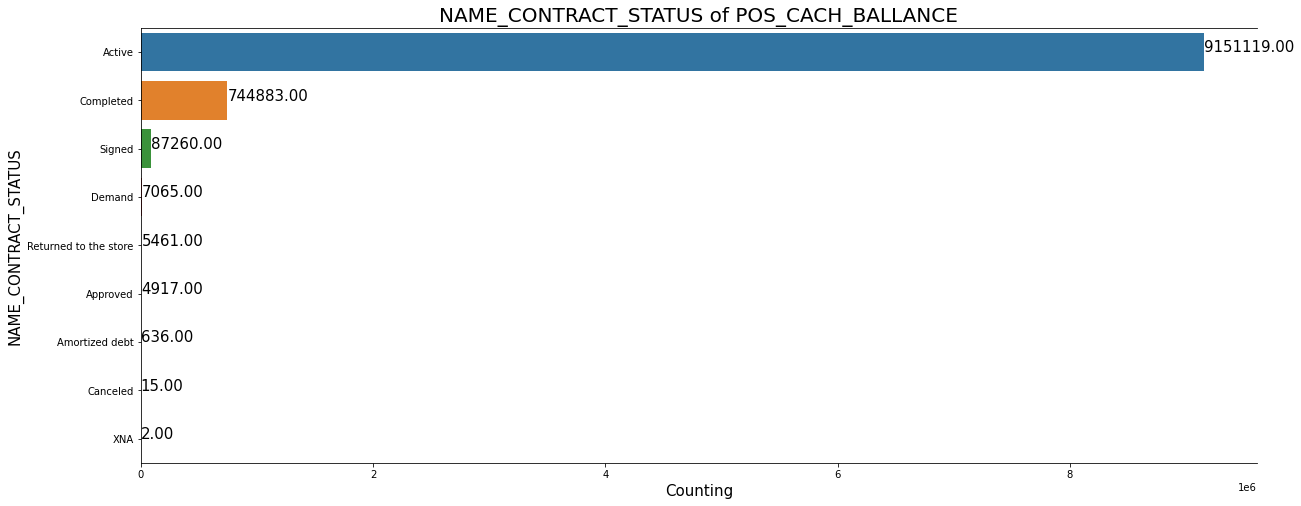

In [58]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=df_POS_CASH_balance.NAME_CONTRACT_STATUS.value_counts(), y=df_POS_CASH_balance.NAME_CONTRACT_STATUS.value_counts().index, data=df_POS_CASH_balance);
show_values(ax, orient="h")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
plt.title('NAME_CONTRACT_STATUS of POS_CACH_BALLANCE', fontsize=20);
plt.xlabel('Counting', fontsize=15);
plt.ylabel('NAME_CONTRACT_STATUS', fontsize=15);
plt.show();

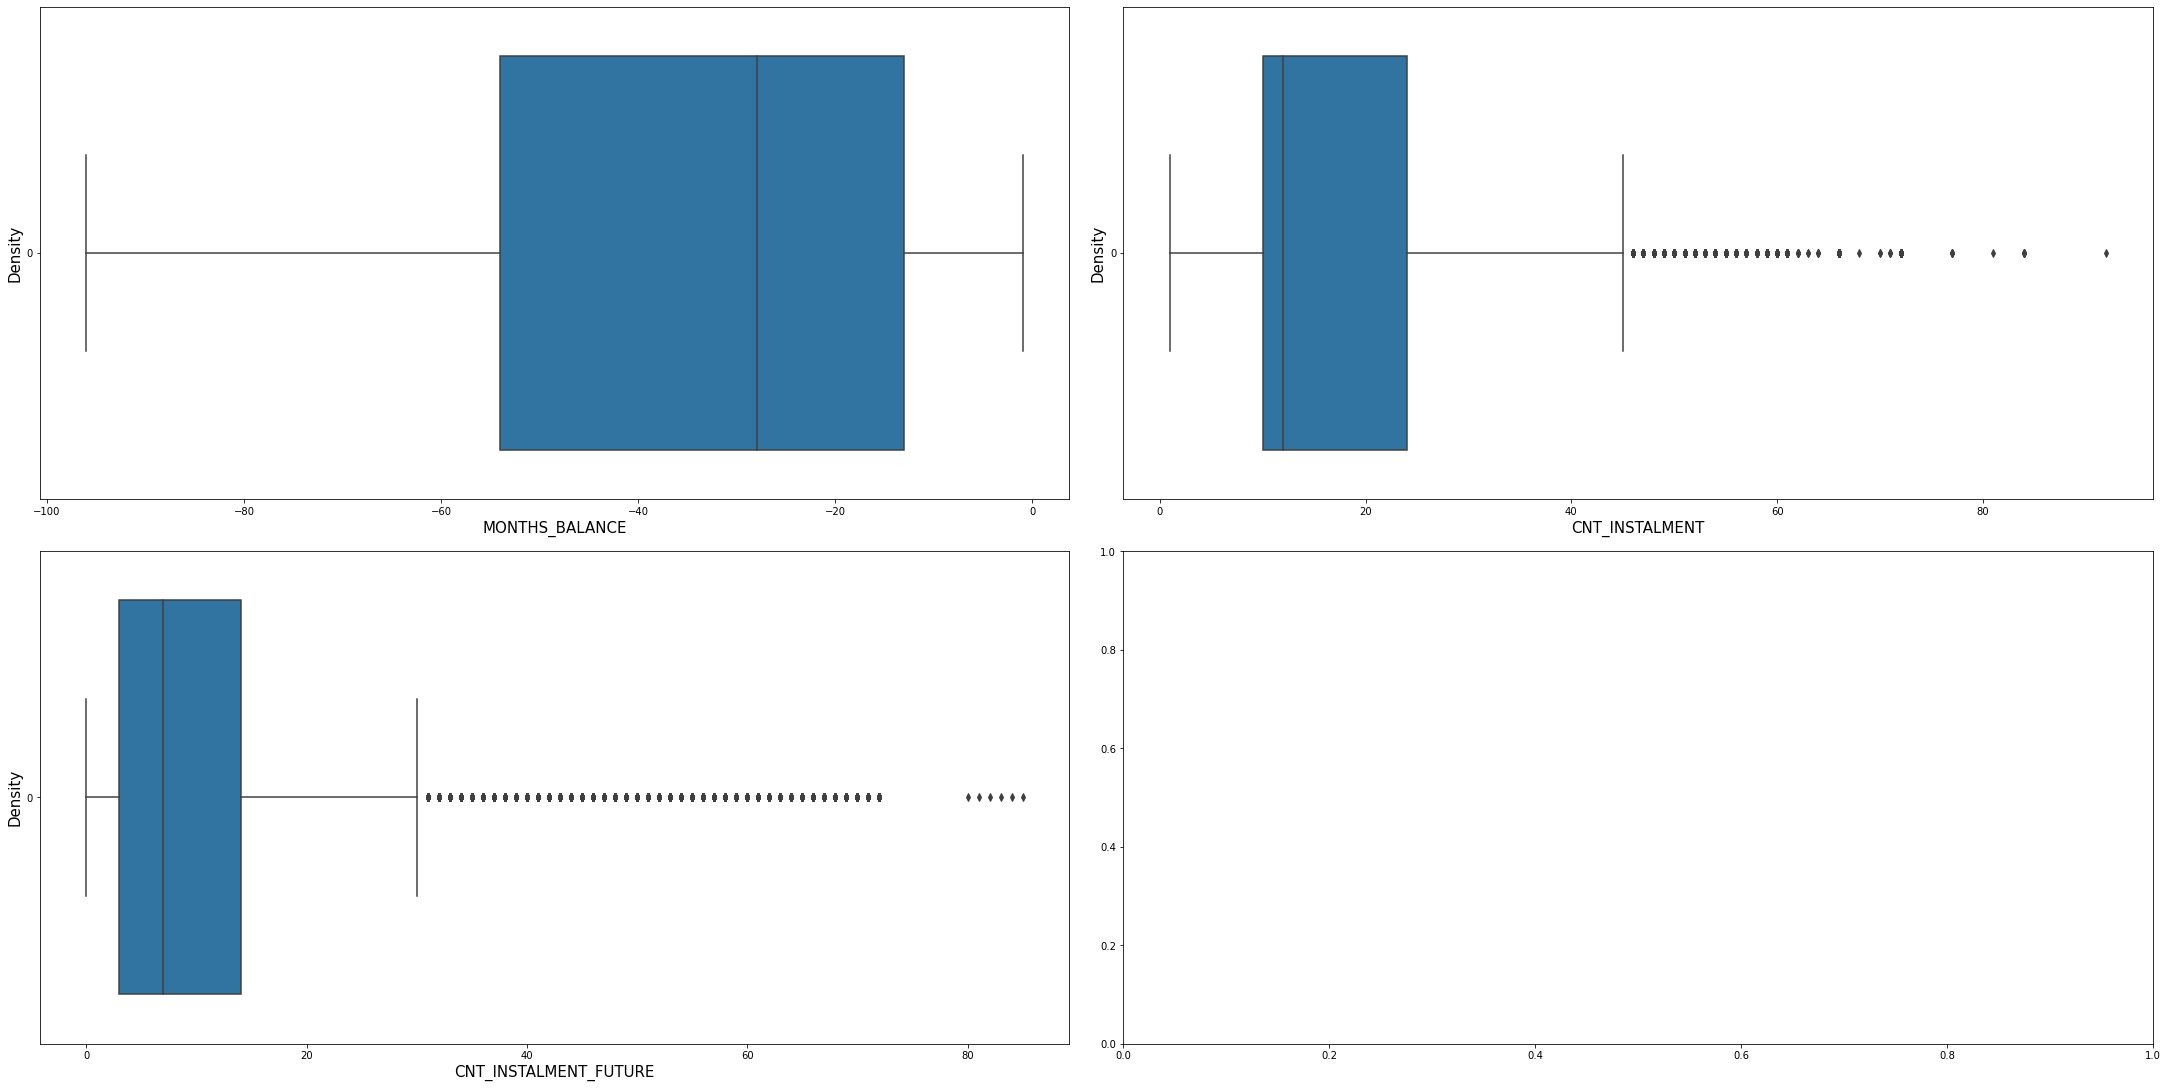

In [59]:
cols = ['MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE']
plot_density(df_POS_CASH_balance, columns = cols, dt = DensityTypes.Boxplot)

### Previous application

In [60]:
df_previous_application.describe()

SK_ID_PREV    SK_ID_CURR   AMT_ANNUITY  AMT_APPLICATION  \
count  1.670214e+06  1.670214e+06  1.297979e+06     1.670214e+06   
mean   1.923089e+06  2.783572e+05  1.595512e+04     1.752339e+05   
std    5.325980e+05  1.028148e+05  1.478214e+04     2.927798e+05   
min    1.000001e+06  1.000010e+05  0.000000e+00     0.000000e+00   
25%    1.461857e+06  1.893290e+05  6.321780e+03     1.872000e+04   
50%    1.923110e+06  2.787145e+05  1.125000e+04     7.104600e+04   
75%    2.384280e+06  3.675140e+05  2.065842e+04     1.803600e+05   
max    2.845382e+06  4.562550e+05  4.180581e+05     6.905160e+06   

         AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
count  1.670213e+06      7.743700e+05     1.284699e+06   
mean   1.961140e+05      6.697402e+03     2.278473e+05   
std    3.185746e+05      2.092150e+04     3.153966e+05   
min    0.000000e+00     -9.000000e-01     0.000000e+00   
25%    2.416050e+04      0.000000e+00     5.084100e+04   
50%    8.054100e+04      1.638000e+03     1.123200e+05   
75%    2.164185e+05      7.740000e+03     2.340000e+05   
max    6.905160e+06      3.060045e+06     6.905160e+06   

       HOUR_APPR_PROCESS_START  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  \
count             1.670214e+06            1.670214e+06      774370.000000   
mean              1.248418e+01            9.964675e-01           0.079637   
std               3.334028e+00            5.932963e-02           0.107823   
min               0.000000e+00            0.000000e+00          -0.000015   
25%               1.000000e+01            1.000000e+00           0.000000   
50%               1.200000e+01            1.000000e+00           0.051605   
75%               1.500000e+01            1.000000e+00           0.108909   
max               2.300000e+01            1.000000e+00           1.000000   

       ...  RATE_INTEREST_PRIVILEGED  DAYS_DECISION  SELLERPLACE_AREA  \
count  ...               5951.000000   1.670214e+06      1.670214e+06   
mean   ...                  0.773503  -8.806797e+02      3.139511e+02   
std    ...                  0.100879   7.790997e+02      7.127443e+03   
min    ...                  0.373150  -2.922000e+03     -1.000000e+00   
25%    ...                  0.715645  -1.300000e+03     -1.000000e+00   
50%    ...                  0.835095  -5.810000e+02      3.000000e+00   
75%    ...                  0.852537  -2.800000e+02      8.200000e+01   
max    ...                  1.000000  -1.000000e+00      4.000000e+06   

        CNT_PAYMENT  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  \
count  1.297984e+06       997149.000000   997149.000000   
mean   1.605408e+01       342209.855039    13826.269337   
std    1.456729e+01        88916.115834    72444.869708   
min    0.000000e+00        -2922.000000    -2892.000000   
25%    6.000000e+00       365243.000000    -1628.000000   
50%    1.200000e+01       365243.000000     -831.000000   
75%    2.400000e+01       365243.000000     -411.000000   
max    8.400000e+01       365243.000000   365243.000000   

       DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
count              997149.000000  997149.000000     997149.000000   
mean                33767.774054   76582.403064      81992.343838   
std                106857.034789  149647.415123     153303.516729   
min                 -2801.000000   -2889.000000      -2874.000000   
25%                 -1242.000000   -1314.000000      -1270.000000   
50%                  -361.000000    -537.000000       -499.000000   
75%                   129.000000     -74.000000        -44.000000   
max                365243.000000  365243.000000     365243.000000   

       NFLAG_INSURED_ON_APPROVAL  
count              997149.000000  
mean                    0.332570  
std                     0.471134  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     1.000000  
max                     1.000000  

[8 rows x 21 columns]

In [61]:
df_previous_application.describe(include=[object])

NAME_CONTRACT_TYPE WEEKDAY_APPR_PROCESS_START  \
count             1670214                    1670214   
unique                  4                          7   
top            Cash loans                    TUESDAY   
freq               747553                     255118   

       FLAG_LAST_APPL_PER_CONTRACT NAME_CASH_LOAN_PURPOSE  \
count                      1670214                1670214   
unique                           2                     25   
top                              Y                    XAP   
freq                       1661739                 922661   

       NAME_CONTRACT_STATUS      NAME_PAYMENT_TYPE CODE_REJECT_REASON  \
count               1670214                1670214            1670214   
unique                    4                      4                  9   
top                Approved  Cash through the bank                XAP   
freq                1036781                1033552            1353093   

       NAME_TYPE_SUITE NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO  \
count           849809          1670214             1670214        1670214   
unique               7                4                  28              5   
top      Unaccompanied         Repeater                 XNA            POS   
freq            508970          1231261              950809         691011   

       NAME_PRODUCT_TYPE             CHANNEL_TYPE NAME_SELLER_INDUSTRY  \
count            1670214                  1670214              1670214   
unique                 3                        8                   11   
top                  XNA  Credit and cash offices                  XNA   
freq             1063666                   719968               855720   

       NAME_YIELD_GROUP PRODUCT_COMBINATION  
count           1670214             1669868  
unique                5                  17  
top                 XNA                Cash  
freq             517215              285990

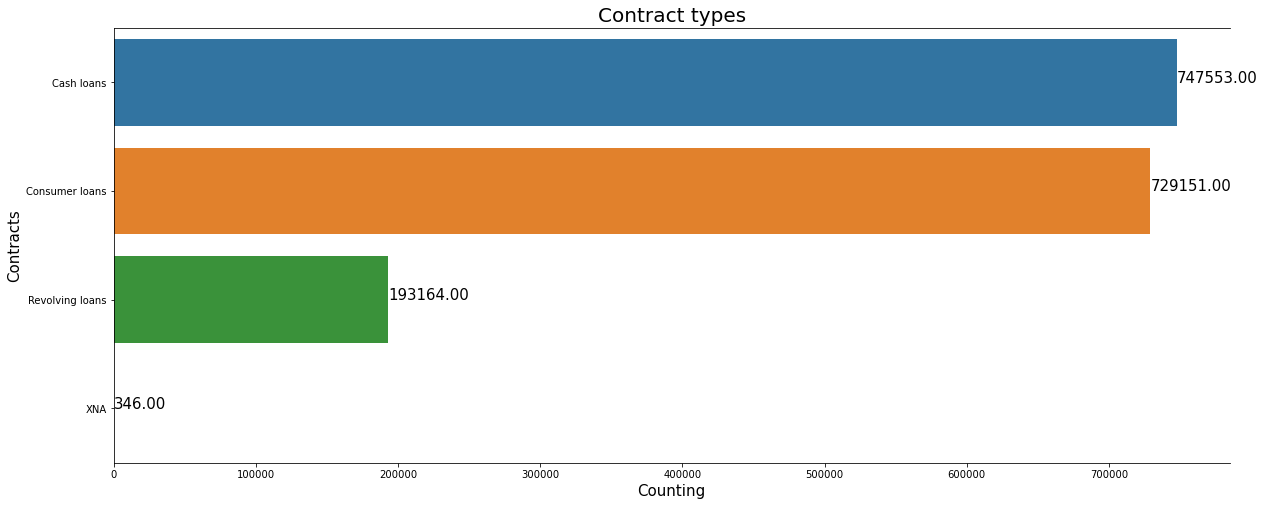

In [62]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=df_previous_application.NAME_CONTRACT_TYPE.value_counts(), y=df_previous_application.NAME_CONTRACT_TYPE.value_counts().index, data=df_previous_application);
show_values(ax, orient="h")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
plt.title('Contract types', fontsize=20);
plt.xlabel('Counting', fontsize=15);
plt.ylabel('Contracts', fontsize=15);
plt.show();

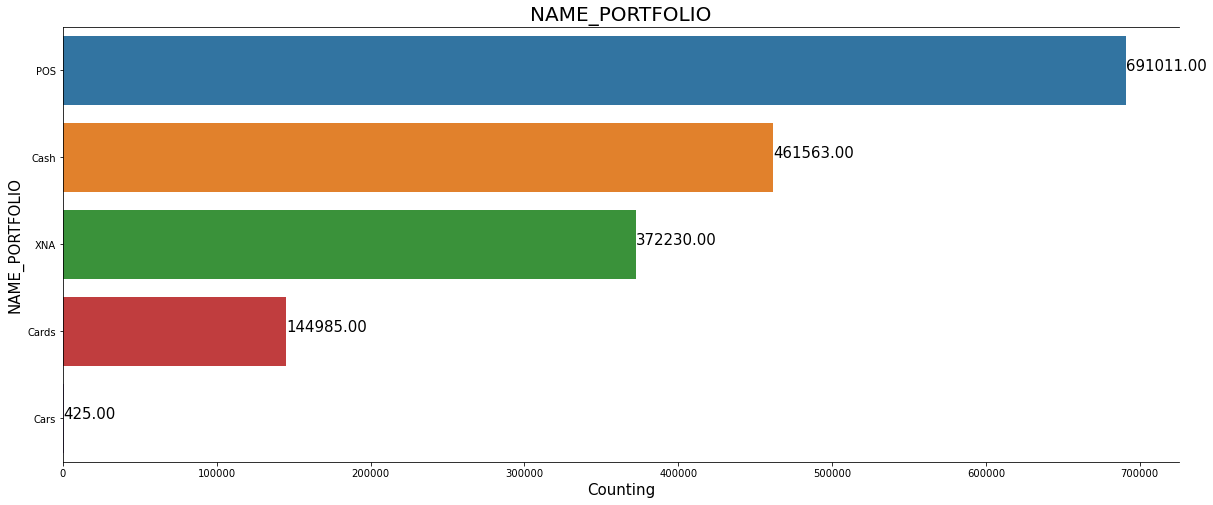

In [63]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=df_previous_application.NAME_PORTFOLIO.value_counts(), y=df_previous_application.NAME_PORTFOLIO.value_counts().index, data=df_previous_application);
show_values(ax, orient="h")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
plt.title('NAME_PORTFOLIO', fontsize=20);
plt.xlabel('Counting', fontsize=15);
plt.ylabel('NAME_PORTFOLIO', fontsize=15);
plt.show();

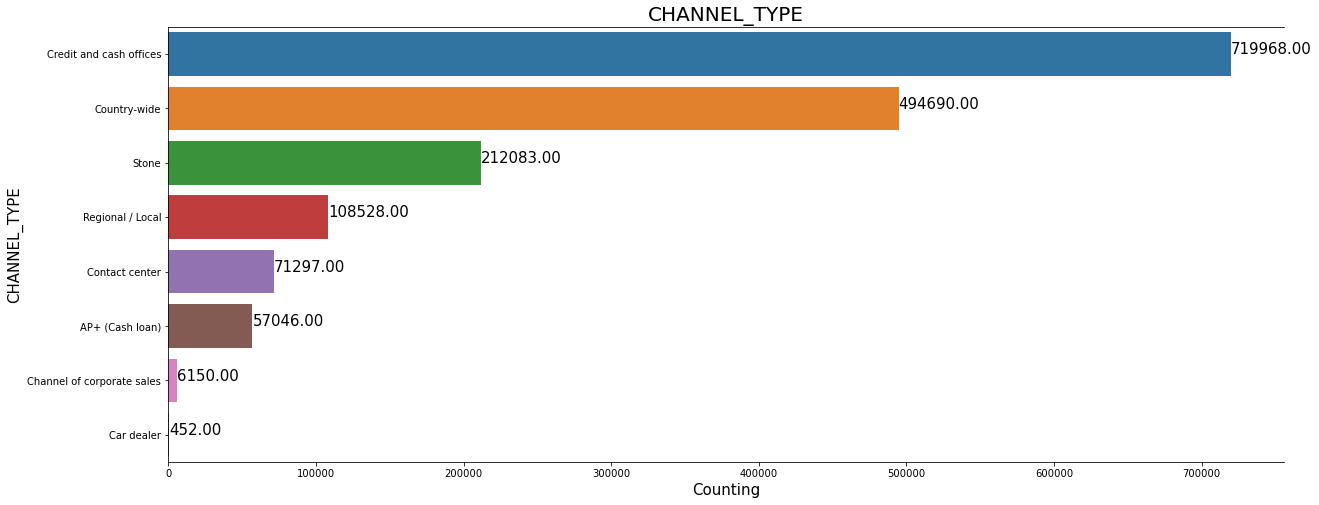

In [64]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=df_previous_application.CHANNEL_TYPE.value_counts(), y=df_previous_application.CHANNEL_TYPE.value_counts().index, data=df_previous_application);
show_values(ax, orient="h")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
plt.title('CHANNEL_TYPE', fontsize=20);
plt.xlabel('Counting', fontsize=15);
plt.ylabel('CHANNEL_TYPE', fontsize=15);
plt.show();

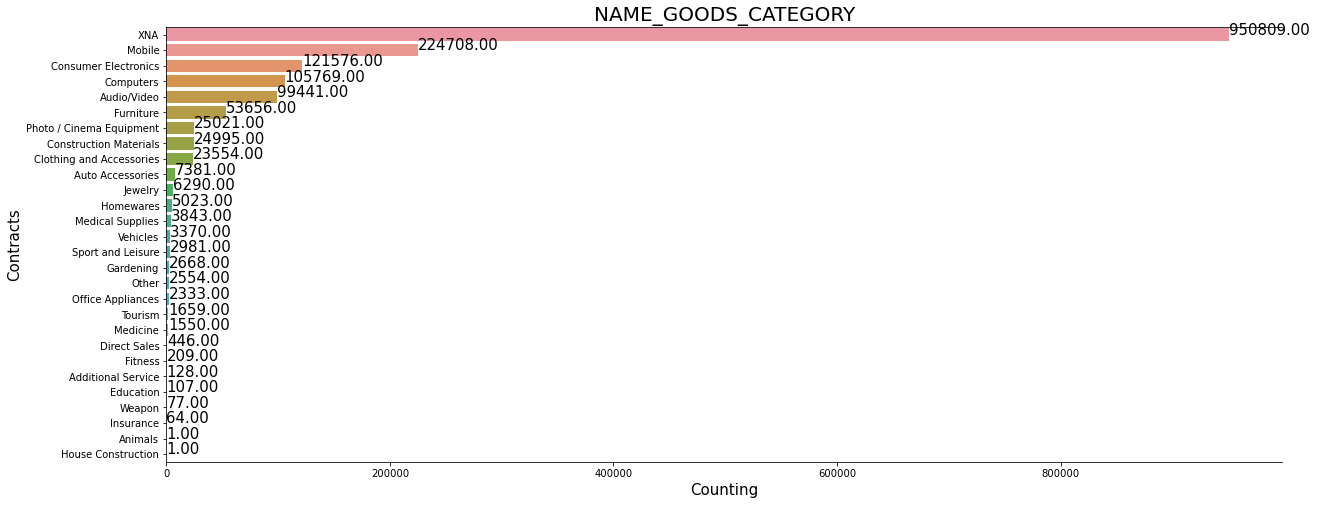

In [65]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=df_previous_application.NAME_GOODS_CATEGORY.value_counts(), y=df_previous_application.NAME_GOODS_CATEGORY.value_counts().index, data=df_previous_application);
show_values(ax, orient="h")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
plt.title('NAME_GOODS_CATEGORY', fontsize=20);
plt.xlabel('Counting', fontsize=15);
plt.ylabel('Contracts', fontsize=15);
plt.show();

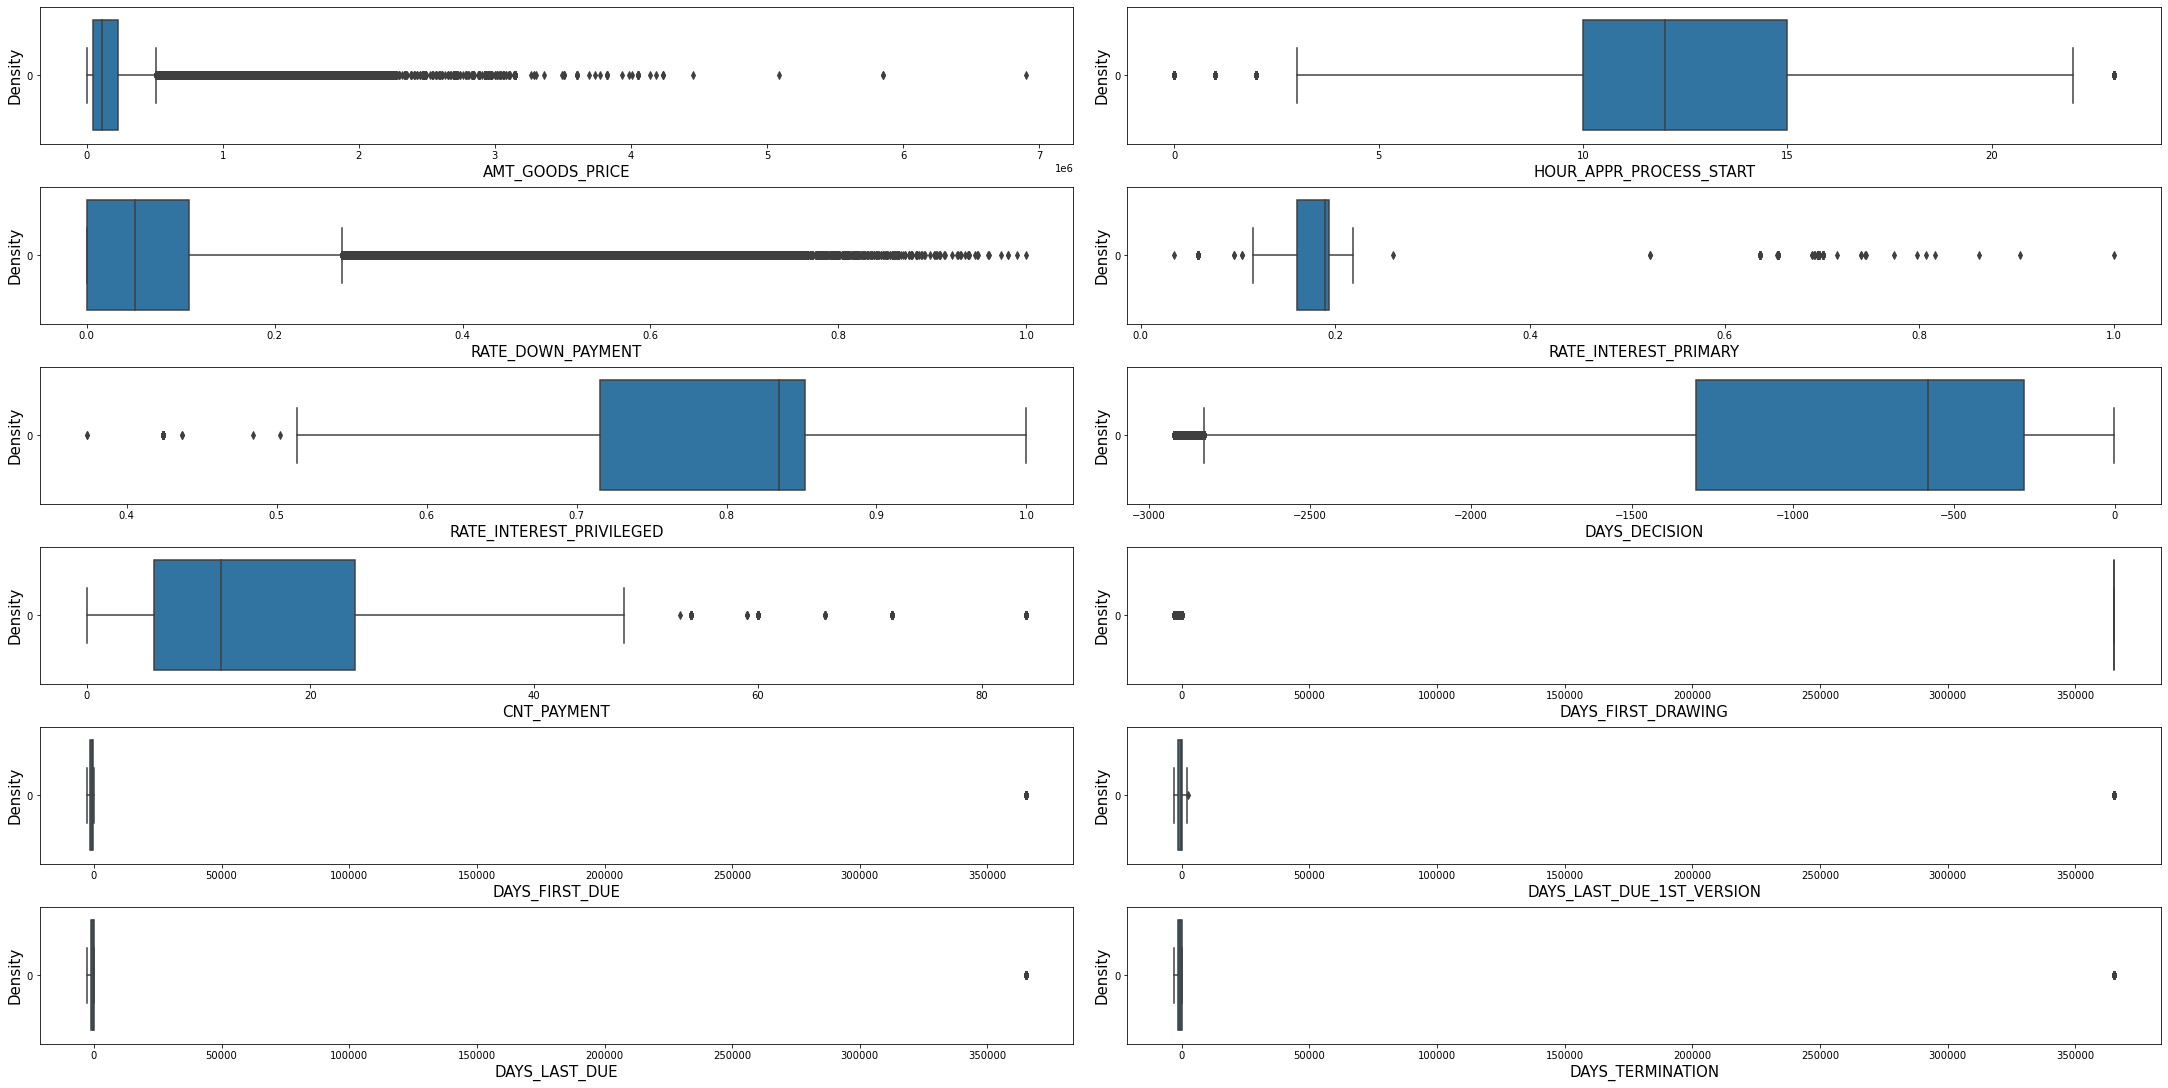

In [66]:
cols = [  'AMT_GOODS_PRICE',
       'HOUR_APPR_PROCESS_START', 
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION',
       'CNT_PAYMENT', 
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION']
plot_density(df_previous_application, columns = cols, dt = DensityTypes.Boxplot)

Observe some outliers in `DAYS_` variables. Theese must be treated.

## Anomalies, Cleaning datasets and Features Engineering

 - Remove the outliers and the anomalies values. We will set the bad values to NaN, in order to fill them all with an Imputer class.
 - Remove non existant gender
 - Remove columns with more then 60% of nans
 - Categorize values in the Organization_type
 - Adding polynomial and domain knoladge features
 - Merging and Joining dataframes
 - Encodding categorical variables

### Application train
#### Duplicates verification

In [6]:
df_train.duplicated(['SK_ID_CURR']).sum()

0

#### Verification of nan in ID client

In [7]:
len(df_train[df_train.SK_ID_CURR.isna()])

0

#### Removing columns with more then 60% of NaNs

In [8]:
var_verify = (df_train.isna().mean() < 0.60)
#var_verify.index
columns60 = list(df_train.columns[var_verify])
df_train = df_train[columns60];

#### Vriffy values that are NaN or XNA and take a decision wether we shall keep them or make a change.

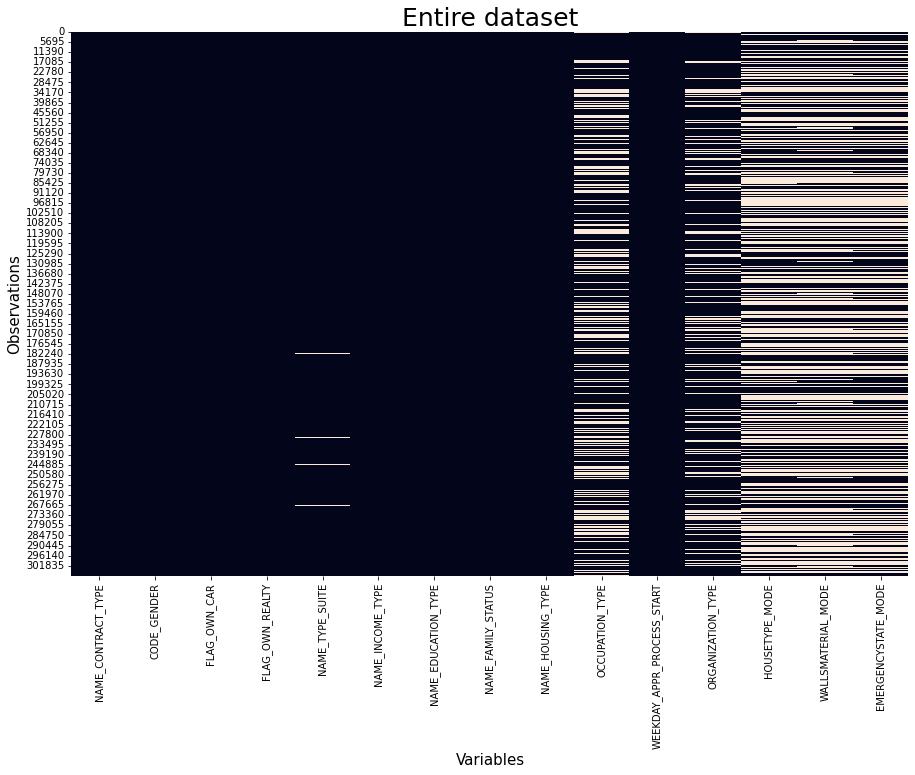

In [9]:
categorical_columns = [col for col in df_train.columns if df_train[col].dtype == 'object']
for col in categorical_columns:
    df_train[col] = df_train[col].replace({'XNA': np.nan})
plot_data(df_train[categorical_columns])

In [10]:
for col in categorical_columns:
    print('There are {0} nan values in the {1} mode variable'.format(len(df_train[df_train[col].isna()]), col))

There are 0 nan values in the NAME_CONTRACT_TYPE mode variable
There are 4 nan values in the CODE_GENDER mode variable
There are 0 nan values in the FLAG_OWN_CAR mode variable
There are 0 nan values in the FLAG_OWN_REALTY mode variable
There are 1292 nan values in the NAME_TYPE_SUITE mode variable
There are 0 nan values in the NAME_INCOME_TYPE mode variable
There are 0 nan values in the NAME_EDUCATION_TYPE mode variable
There are 0 nan values in the NAME_FAMILY_STATUS mode variable
There are 0 nan values in the NAME_HOUSING_TYPE mode variable
There are 96391 nan values in the OCCUPATION_TYPE mode variable
There are 0 nan values in the WEEKDAY_APPR_PROCESS_START mode variable
There are 55374 nan values in the ORGANIZATION_TYPE mode variable
There are 154297 nan values in the HOUSETYPE_MODE mode variable
There are 156341 nan values in the WALLSMATERIAL_MODE mode variable
There are 145755 nan values in the EMERGENCYSTATE_MODE mode variable


Lot's of values are not given for the emergency mode that has 2 other values 'yes' and 'no'. The same think is observed for the HOUSETYPE_MODE variable. I will keep the nan value for theese variables. Also WALLSMATERIAL_MODE has a lot of nan values. But viewing the unique values we observe the Other value in WALLSMATERIAL_MODE, so we fill the nan values with 'Others' value that seems adequate. With the same logic we set the values of ORGANIZATION_TYPE XNA to Other. Also we will simplify the organization types by reducing them with making some categories: 'Industry: type 1, 2, 3....' we will name it just 'Industry'; 'Trade: type 1,2,3..' we name it 'Trade', etc.

In [11]:
df_train.loc[df_train.WALLSMATERIAL_MODE.isna(), 'WALLSMATERIAL_MODE'] = 'Others'
df_train.WALLSMATERIAL_MODE.unique()

array(['Stone, brick', 'Block', 'Others', 'Panel', 'Mixed', 'Wooden',
       'Monolithic'], dtype=object)

In [12]:
categories ={
    'business entity' : ['business entity type 3', 'business entity type 2', 'business entity type 1', ],
    'industry' : ['industry: type 9', 'industry: type 3', 'industry: type 11', 'industry: type 7', 'industry: type 1', 'industry: type 4', 'industry: type 5', 'industry: type 2', 'industry: type 12', 'industry: type 6', 'industry: type 10', 'industry: type 13', 'industry: type 8'],
    'other': ['other'],
    'self-employed' : ['self-employed'],
    'medicine' : ['medicine'],
    'government' : ['government'],
    'school' : ['school' ],
    'trade' : ['trade: type 7', 'trade: type 3', 'trade: type 2', 'trade: type 6', 'trade: type 1', 'trade: type 4', 'trade: type 5'],
    'kindergarten' : ['kindergarten'],
    'construction' : ['construction'],
    'transport' : ['transport: type 4', 'transport: type 2', 'transport: type 3', 'transport: type 1'],
    'security':['security'], 
    'housing':['housing'], 
    'military':['military'],
    'bank':['bank'],
    'agriculture':['agriculture'],
    'police':['police'],
    'postal':['postal'],
    'security ministries':['security ministries'],
    'postal':['postal'],
    'restaurant':['restaurant'],
    'services' :['services', 'legal services', 'cleaning'],
    'university':['university'],
    'hotel':['hotel'],
    'electricity':['electricity'],
    'insurance':['insurance'],
    'telecom':['telecom'],
    'emergency' :['emergency'],
    'advertising':['advertising'],
    'realtor':['realtor'],
    'culture':['culture'],
    'mobile':['mobile'],
    'religion':['religion'],
}
df_train['ORGANIZATION_TYPE'] = df_train['ORGANIZATION_TYPE'].str.lower();
for new_value, old_value in categories.items():
    df_train['ORGANIZATION_TYPE'] = df_train['ORGANIZATION_TYPE'].replace(old_value, new_value);
#compute_words_freq(df_train, 'ORGANIZATION_TYPE', sep=',')

In [13]:
df_train.loc[df_train.ORGANIZATION_TYPE.isna(), 'ORGANIZATION_TYPE'] = 'other'
df_train.ORGANIZATION_TYPE.unique()

array(['business entity', 'school', 'government', 'religion', 'other',
       'electricity', 'medicine', 'self-employed', 'transport',
       'construction', 'housing', 'kindergarten', 'trade', 'industry',
       'military', 'services', 'security ministries', 'emergency',
       'security', 'university', 'police', 'postal', 'agriculture',
       'restaurant', 'culture', 'hotel', 'bank', 'insurance', 'mobile',
       'advertising', 'telecom', 'realtor'], dtype=object)

In [14]:
df_train.loc[df_train.OCCUPATION_TYPE.isna(), 'OCCUPATION_TYPE'] = 'Drivers'
df_train.OCCUPATION_TYPE.unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', 'Drivers',
       'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

In [15]:
df_train.NAME_TYPE_SUITE.unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children',
       'Other_A', nan, 'Other_B', 'Group of people'], dtype=object)

#### Remove 4 applications with nan CODE_GENDER

In [16]:
df_train = df_train[~df_train['CODE_GENDER'].isna()]

#### DAYS_EMPLOYED and DAYS_BIRTH outlier

In [17]:
(df_train['DAYS_BIRTH'] / -365).describe()

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?

In [18]:
df_train['DAYS_EMPLOYED'].describe()

count    307507.000000
mean      63815.929208
std      141276.472519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

In [19]:
len(df_train[(df_train['DAYS_EMPLOYED']>0) & (df_train['DAYS_EMPLOYED']!=365243)].DAYS_EMPLOYED)

0

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. 

In [20]:
# Replace the anomalous values with nan
df_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

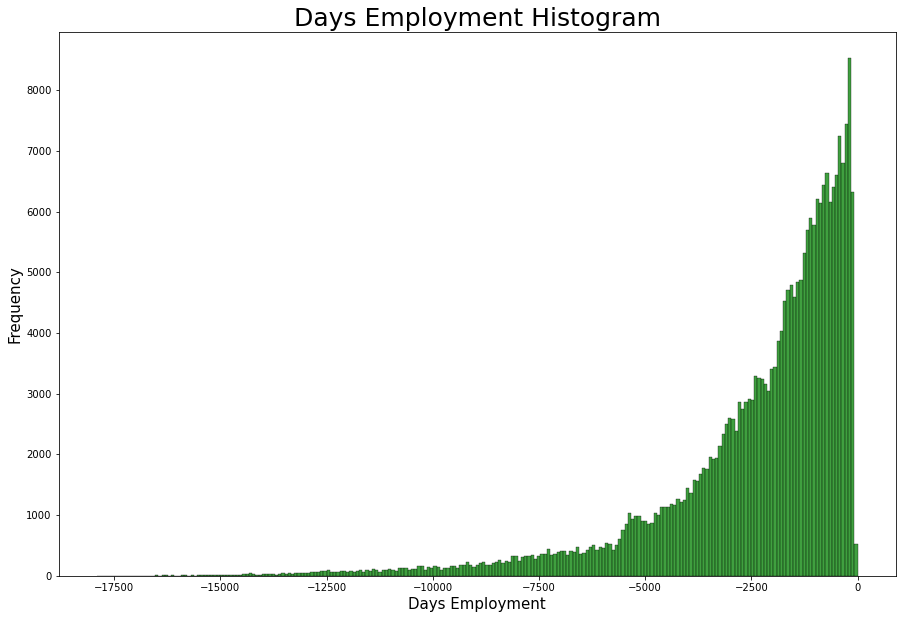

In [21]:
fig = plt.figure(figsize=(15, 10));
sns.histplot(data = df_train['DAYS_EMPLOYED'], kde=False, color='green');
plt.title('Days Employment Histogram',fontsize=25);
plt.xlabel('Days Employment',fontsize=15);
plt.ylabel('Frequency',fontsize=15);
plt.show();

The distribution looks to be much more in line with what we would expect. We will have to fill in the nans with some value, probably the median of the column. The other columns with DAYS in the dataframe look to be about what we expect with no obvious outliers.

#### Adding some Domain knowledge features and polynomial features

Feature engineering: those win are those who can create the most useful features out of the data. (This is true for the most part as the winning models, at least for structured data, all tend to be variants on gradient boosting). This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. This is a great article on the subject). As Andrew Ng is fond of saying: "applied machine learning is basically feature engineering.".

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some automated tools to help us out).

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

 - ***Polynomial features*** : One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables `EXT_SOURCE_1`^2 and `EXT_SOURCE_2`^2 and also variables such as `EXT_SOURCE_` x `EXT_SOURCE_2`, `EXT_SOURCE_1` x `EXT_SOURCE_2`^2, `EXT_SOURCE_1`^2 x  `EXT_SOURCE_2`^2, and so on. These features that are a combination of multiple individual variables are called interaction terms because they capture the interactions between variables. In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. Interaction terms are commonly used in statistical models to capture the effects of multiple variables. Theese are not used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan. Scikit-Learn has a useful class called PolynomialFeatures that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into problems with overfitting). 
 
 - ***Domain knowledge features*** : Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by this script by Aguiar:

      - `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
      - `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
      - `CREDIT_TERM`: the length of the payment in months (since the annuity is the monthly amount due
      - `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

In [22]:
from sklearn.preprocessing import PolynomialFeatures
                                  

# Make a new dataframe for polynomial features
poly_features = df_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]


from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)

# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

PolynomialFeatures(degree=3)

/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
var_verify = poly_features.nunique()>1
#var_verify.index
poly_features = poly_features[poly_features.columns[var_verify]]
poly_features.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'], inplace=True, axis=1)

In [24]:
poly_features.head()

EXT_SOURCE_1^2  EXT_SOURCE_1 EXT_SOURCE_2  EXT_SOURCE_1 EXT_SOURCE_3  \
0        0.006895                   0.021834                   0.011573   
1        0.096887                   0.193685                   0.166614   
2        0.256034                   0.281290                   0.369159   
3        0.256034                   0.329122                   0.270849   
4        0.256034                   0.163305                   0.270849   

   EXT_SOURCE_1 DAYS_BIRTH  EXT_SOURCE_2^2  EXT_SOURCE_2 EXT_SOURCE_3  \
0              -785.612748        0.069142                   0.036649   
1             -5218.396475        0.387190                   0.333073   
2             -9637.236584        0.309038                   0.405575   
3             -9616.490669        0.423074                   0.348166   
4            -10085.550751        0.104160                   0.172754   

   EXT_SOURCE_2 DAYS_BIRTH  EXT_SOURCE_3^2  EXT_SOURCE_3 DAYS_BIRTH  \
0             -2487.756636        0.019426             -1318.634256   
1            -10431.950422        0.286521             -8973.906339   
2            -10587.901540        0.532268            -13895.327191   
3            -12361.644326        0.286521            -10172.925140   
4             -6432.819536        0.286521            -10669.126224   

   DAYS_BIRTH^2  ...  EXT_SOURCE_2^3  EXT_SOURCE_2^2 EXT_SOURCE_3  \
0    89510521.0  ...        0.018181                     0.009637   
1   281065225.0  ...        0.240927                     0.207254   
2   362750116.0  ...        0.171798                     0.225464   
3   361190025.0  ...        0.275185                     0.226462   
4   397284624.0  ...        0.033616                     0.055754   

   EXT_SOURCE_2^2 DAYS_BIRTH  EXT_SOURCE_2 EXT_SOURCE_3^2  \
0                -654.152107                     0.005108   
1               -6491.237078                     0.178286   
2               -5885.942404                     0.295894   
3               -8040.528832                     0.186365   
4               -2076.117157                     0.092471   

   EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH  EXT_SOURCE_2 DAYS_BIRTH^2  \
0                           -346.733022               2.353667e+07   
1                          -5583.975307               1.748916e+08   
2                          -7724.580288               2.016572e+08   
3                          -6616.894625               2.349331e+08   
4                          -3443.335521               1.282190e+08   

   EXT_SOURCE_3^3  EXT_SOURCE_3^2 DAYS_BIRTH  EXT_SOURCE_3 DAYS_BIRTH^2  \
0        0.002707                -183.785678               1.247560e+07   
1        0.153368               -4803.518937               1.504475e+08   
2        0.388325              -10137.567875               2.646504e+08   
3        0.153368               -5445.325225               1.933364e+08   
4        0.153368               -5710.929881               2.126570e+08   

   DAYS_BIRTH^3  
0 -8.468590e+11  
1 -4.712058e+12  
2 -6.908939e+12  
3 -6.864416e+12  
4 -7.918677e+12  

[5 rows x 30 columns]

In [25]:
df_train = pd.concat([df_train, poly_features], axis=1)

In [26]:
df_train['CREDIT_INCOME_PERCENT'] = df_train['AMT_CREDIT'] / df_train['AMT_INCOME_TOTAL']
df_train['ANNUITY_INCOME_PERCENT'] = df_train['AMT_ANNUITY'] / df_train['AMT_INCOME_TOTAL']
df_train['CREDIT_TERM'] = df_train['AMT_ANNUITY'] / df_train['AMT_CREDIT']
df_train['DAYS_EMPLOYED_PERCENT'] = df_train['DAYS_EMPLOYED'] / df_train['DAYS_BIRTH']
df_train['INCOME_CREDIT_PERC'] = df_train['AMT_INCOME_TOTAL'] / df_train['AMT_CREDIT']
df_train['INCOME_PER_PERSON'] = df_train['AMT_INCOME_TOTAL'] / df_train['CNT_FAM_MEMBERS']

#### Visualize the new variables
We should explore these domain knowledge variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the TARGET.

<Figure size 864x1440 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='CREDIT_INCOME_PERCENT', ylabel='Density'>

<AxesSubplot:xlabel='CREDIT_INCOME_PERCENT', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of CREDIT_INCOME_PERCENT by Target Value')

Text(0.5, 0, 'CREDIT_INCOME_PERCENT')

Text(0, 0.5, 'Density')

<AxesSubplot:>

<AxesSubplot:xlabel='ANNUITY_INCOME_PERCENT', ylabel='Density'>

<AxesSubplot:xlabel='ANNUITY_INCOME_PERCENT', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of ANNUITY_INCOME_PERCENT by Target Value')

Text(0.5, 0, 'ANNUITY_INCOME_PERCENT')

Text(0, 0.5, 'Density')

<AxesSubplot:>

<AxesSubplot:xlabel='CREDIT_TERM', ylabel='Density'>

<AxesSubplot:xlabel='CREDIT_TERM', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of CREDIT_TERM by Target Value')

Text(0.5, 0, 'CREDIT_TERM')

Text(0, 0.5, 'Density')

<AxesSubplot:>

<AxesSubplot:xlabel='DAYS_EMPLOYED_PERCENT', ylabel='Density'>

<AxesSubplot:xlabel='DAYS_EMPLOYED_PERCENT', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of DAYS_EMPLOYED_PERCENT by Target Value')

Text(0.5, 0, 'DAYS_EMPLOYED_PERCENT')

Text(0, 0.5, 'Density')

<AxesSubplot:>

<AxesSubplot:xlabel='INCOME_CREDIT_PERC', ylabel='Density'>

<AxesSubplot:xlabel='INCOME_CREDIT_PERC', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of INCOME_CREDIT_PERC by Target Value')

Text(0.5, 0, 'INCOME_CREDIT_PERC')

Text(0, 0.5, 'Density')

<AxesSubplot:>

<AxesSubplot:xlabel='INCOME_PER_PERSON', ylabel='Density'>

<AxesSubplot:xlabel='INCOME_PER_PERSON', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of INCOME_PER_PERSON by Target Value')

Text(0.5, 0, 'INCOME_PER_PERSON')

Text(0, 0.5, 'Density')

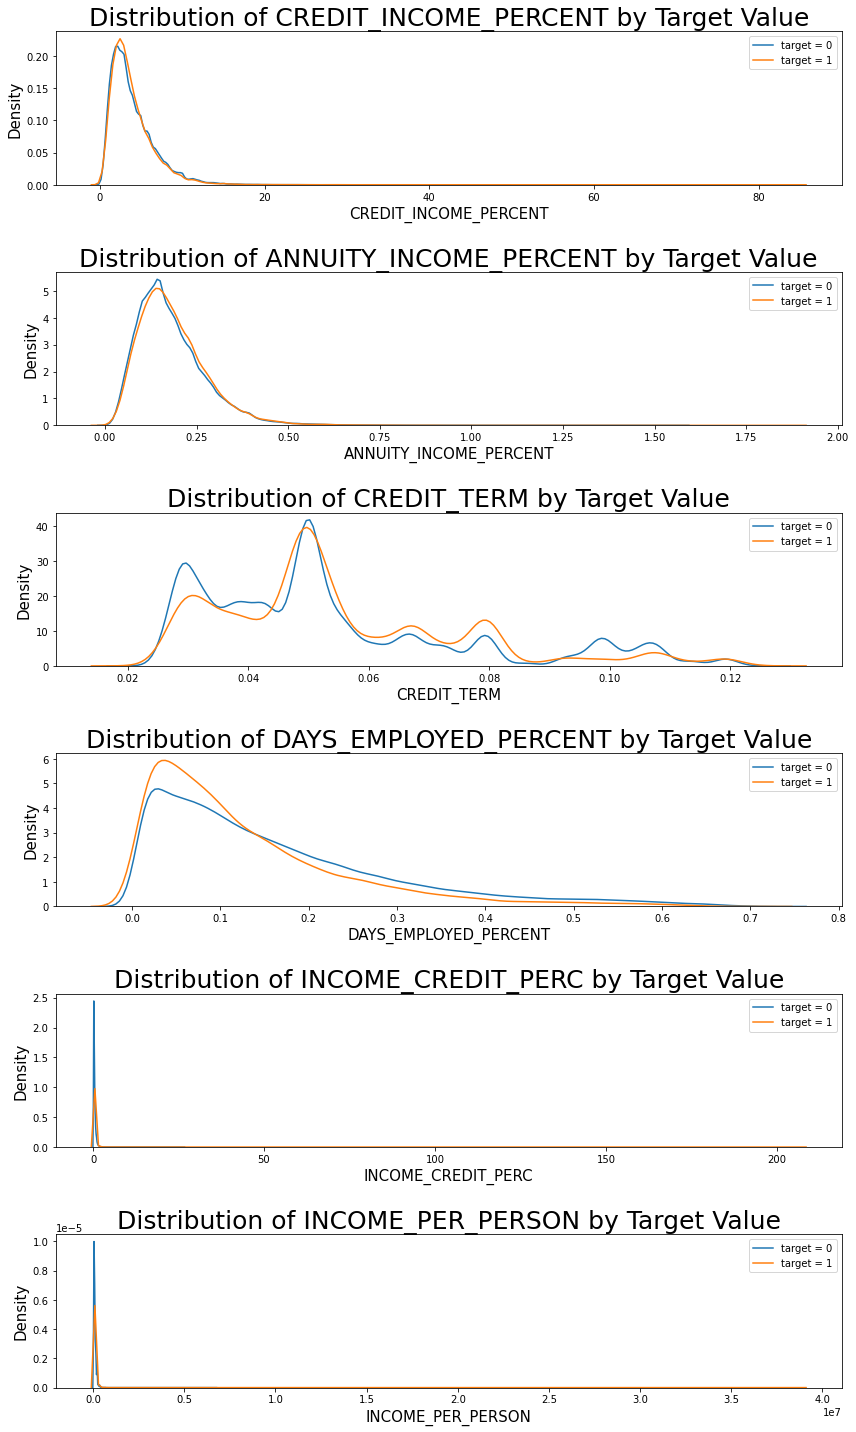

In [29]:
plt.figure(figsize = (12, 20));
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON']):
    
    # create a new subplot for each source
    plt.subplot(6, 1, i + 1);
    # plot repaid loans
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, feature], label = 'target = 0');
    # plot loans that were not repaid
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, feature], label = 'target = 1');
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature,fontsize=25);
    plt.xlabel('%s' % feature,fontsize=15); 
    plt.ylabel('Density',fontsize=15);
    plt.legend();
    
plt.tight_layout(h_pad = 2.5)

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out!

### Bureau

#### Removing columns with more then 60% of NaNs

In [27]:
var_verify = (df_bureau.isna().mean() < 0.60)
#var_verify.index
columns60 = list(df_bureau.columns[var_verify])
df_bureau = df_bureau[columns60];

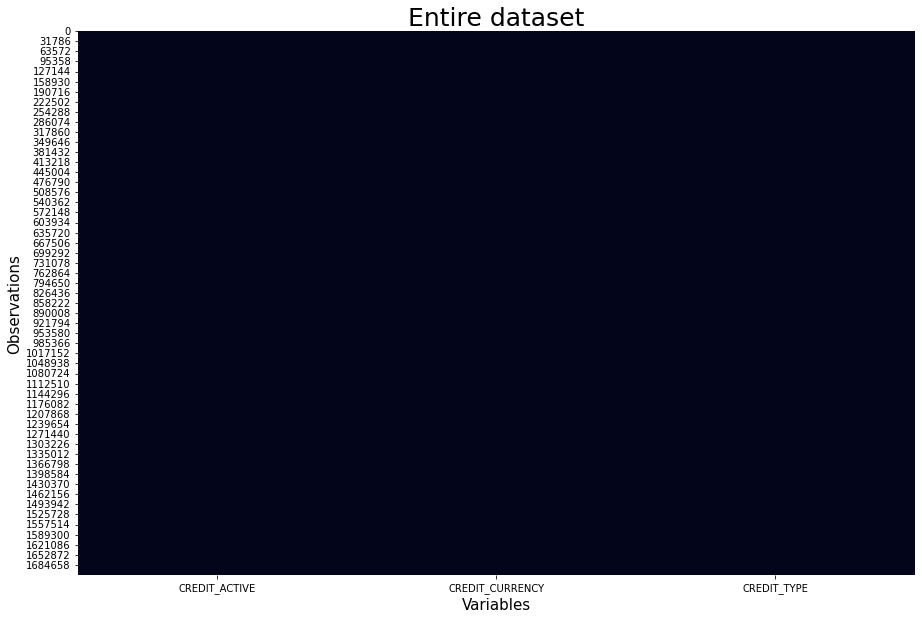

In [28]:
categorical_columns = [col for col in df_bureau.columns if df_bureau[col].dtype == 'object']
for col in categorical_columns:
    df_bureau[col] = df_bureau[col].replace({'XNA': np.nan})
plot_data(df_bureau[categorical_columns])

### Previous application

#### Removing columns with more then 60% of NaNs

In [29]:
var_verify = (df_previous_application.isna().mean() < 0.60)
#var_verify.index
columns60 = list(df_previous_application.columns[var_verify])
df_previous_application = df_previous_application[columns60];

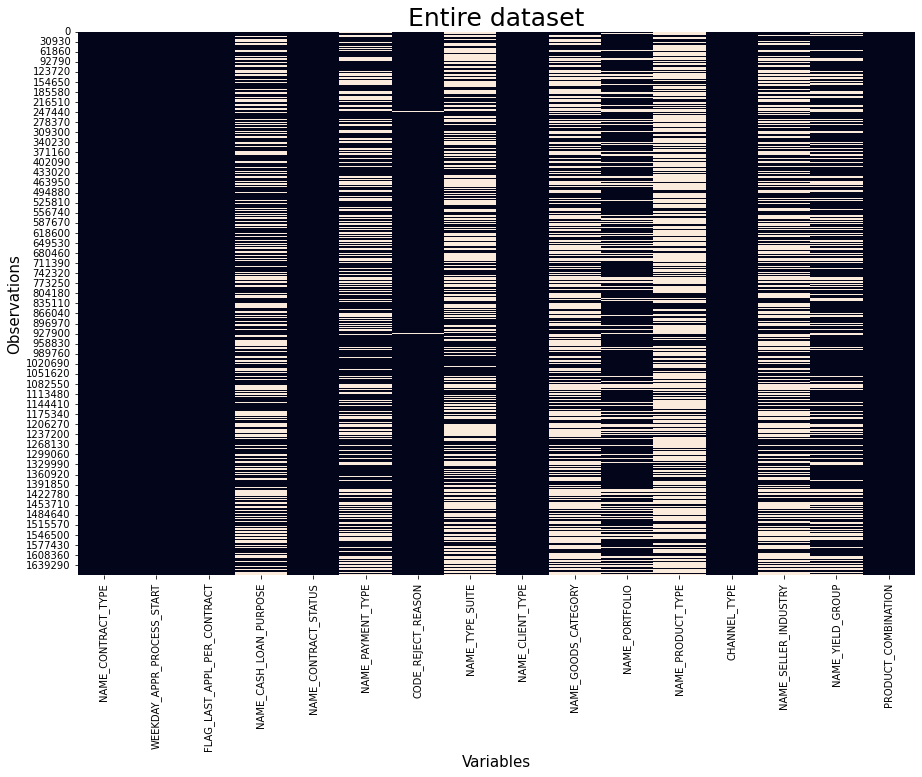

In [30]:
categorical_columns = [col for col in df_previous_application.columns if df_previous_application[col].dtype == 'object']
for col in categorical_columns:
    df_previous_application[col] = df_previous_application[col].replace({'XNA': np.nan})
plot_data(df_previous_application[categorical_columns])

In [31]:
for col in categorical_columns:
    print('There are {0} nan values in the {1} mode variable'.format(len(df_previous_application[df_previous_application[col].isna()]), col))

There are 346 nan values in the NAME_CONTRACT_TYPE mode variable
There are 0 nan values in the WEEKDAY_APPR_PROCESS_START mode variable
There are 0 nan values in the FLAG_LAST_APPL_PER_CONTRACT mode variable
There are 677918 nan values in the NAME_CASH_LOAN_PURPOSE mode variable
There are 0 nan values in the NAME_CONTRACT_STATUS mode variable
There are 627384 nan values in the NAME_PAYMENT_TYPE mode variable
There are 5244 nan values in the CODE_REJECT_REASON mode variable
There are 820405 nan values in the NAME_TYPE_SUITE mode variable
There are 1941 nan values in the NAME_CLIENT_TYPE mode variable
There are 950809 nan values in the NAME_GOODS_CATEGORY mode variable
There are 372230 nan values in the NAME_PORTFOLIO mode variable
There are 1063666 nan values in the NAME_PRODUCT_TYPE mode variable
There are 0 nan values in the CHANNEL_TYPE mode variable
There are 855720 nan values in the NAME_SELLER_INDUSTRY mode variable
There are 517215 nan values in the NAME_YIELD_GROUP mode variable

In [32]:
df_previous_application.loc[df_previous_application.NAME_CASH_LOAN_PURPOSE == 'XAP', 'NAME_CASH_LOAN_PURPOSE'] = 'Other'
df_previous_application.loc[df_previous_application.NAME_CASH_LOAN_PURPOSE.isna(), 'NAME_CASH_LOAN_PURPOSE'] = 'Other'
df_previous_application.NAME_CASH_LOAN_PURPOSE.unique()

array(['Other', 'Repairs', 'Everyday expenses', 'Car repairs',
       'Building a house or an annex', 'Journey',
       'Purchase of electronic equipment', 'Medicine',
       'Payments on other loans', 'Urgent needs', 'Buying a used car',
       'Buying a new car', 'Buying a holiday home / land', 'Education',
       'Buying a home', 'Furniture', 'Buying a garage',
       'Business development', 'Wedding / gift / holiday', 'Hobby',
       'Gasification / water supply', 'Refusal to name the goal',
       'Money for a third person'], dtype=object)

In [33]:
df_previous_application.loc[df_previous_application.CODE_REJECT_REASON.isna(), 'CODE_REJECT_REASON'] = 'XAP'
df_previous_application.CODE_REJECT_REASON.unique()

array(['XAP', 'HC', 'LIMIT', 'CLIENT', 'SCOFR', 'SCO', 'VERIF', 'SYSTEM'],
      dtype=object)

In [34]:
df_previous_application.loc[df_previous_application.NAME_GOODS_CATEGORY.isna(), 'NAME_GOODS_CATEGORY'] = 'Other'
df_previous_application.NAME_GOODS_CATEGORY.unique()

array(['Mobile', 'Other', 'Consumer Electronics',
       'Construction Materials', 'Auto Accessories',
       'Photo / Cinema Equipment', 'Computers', 'Audio/Video', 'Medicine',
       'Clothing and Accessories', 'Furniture', 'Sport and Leisure',
       'Homewares', 'Gardening', 'Jewelry', 'Vehicles', 'Education',
       'Medical Supplies', 'Direct Sales', 'Office Appliances', 'Fitness',
       'Tourism', 'Insurance', 'Additional Service', 'Weapon', 'Animals',
       'House Construction'], dtype=object)

#### DAYS_ outlier variables

In [35]:
df_previous_application['DAYS_FIRST_DRAWING'].replace({365243: np.nan}, inplace = True)
df_previous_application['DAYS_FIRST_DUE'].replace({365243: np.nan}, inplace = True)
df_previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace({365243: np.nan}, inplace = True)
df_previous_application['DAYS_LAST_DUE'].replace({365243: np.nan}, inplace = True)
df_previous_application['DAYS_TERMINATION'].replace({365243: np.nan}, inplace = True)

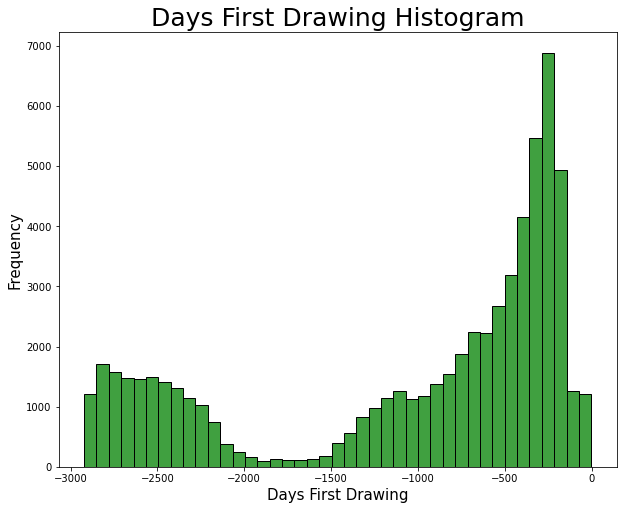

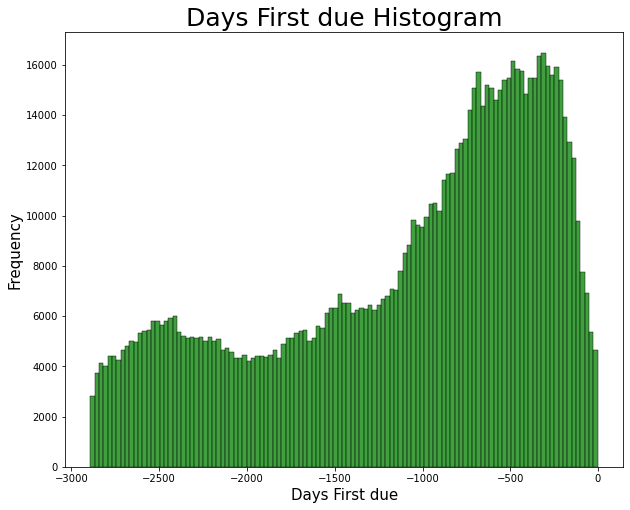

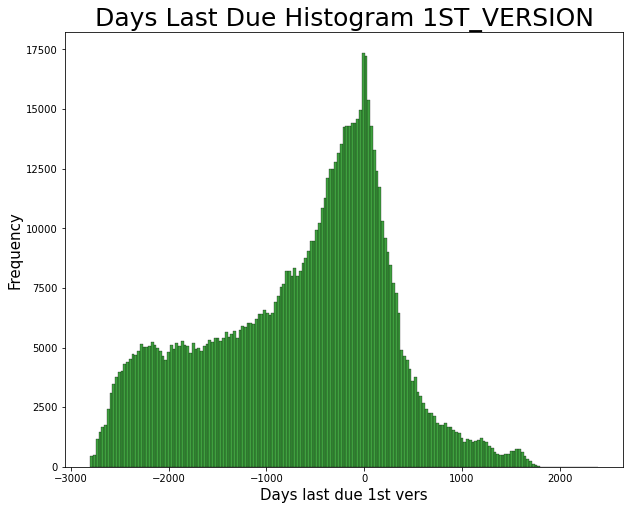

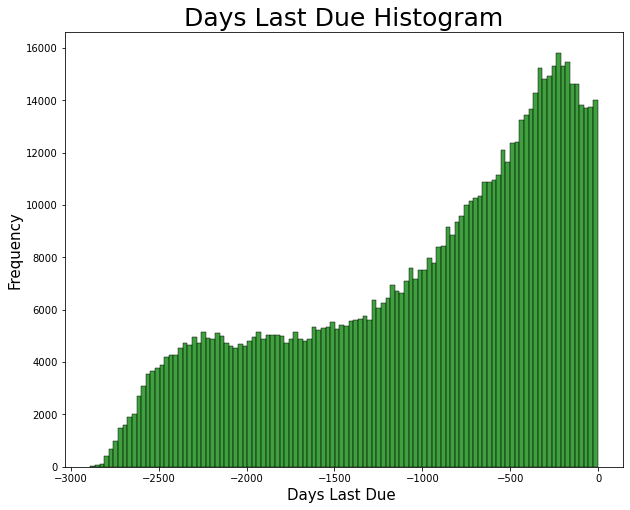

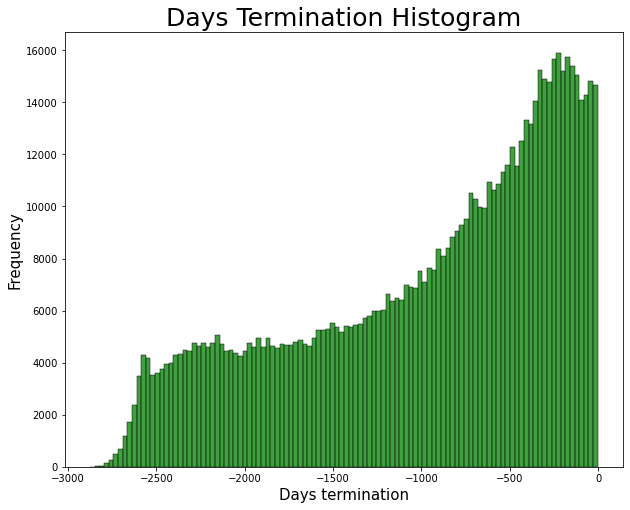

In [36]:
fig = plt.figure(figsize=(10, 8));
sns.histplot(data = df_previous_application['DAYS_FIRST_DRAWING'], kde=False, color='green');
plt.title('Days First Drawing Histogram',fontsize=25);
plt.xlabel('Days First Drawing',fontsize=15);
plt.ylabel('Frequency',fontsize=15);
plt.show();

fig = plt.figure(figsize=(10, 8));
sns.histplot(data = df_previous_application['DAYS_FIRST_DUE'], kde=False, color='green');
plt.title('Days First due Histogram',fontsize=25);
plt.xlabel('Days First due',fontsize=15);
plt.ylabel('Frequency',fontsize=15);
plt.show();

fig = plt.figure(figsize=(10, 8));
sns.histplot(data = df_previous_application['DAYS_LAST_DUE_1ST_VERSION'], kde=False, color='green');
plt.title('Days Last Due Histogram 1ST_VERSION',fontsize=25);
plt.xlabel('Days last due 1st vers',fontsize=15);
plt.ylabel('Frequency',fontsize=15);
plt.show();

fig = plt.figure(figsize=(10, 8));
sns.histplot(data = df_previous_application['DAYS_LAST_DUE'], kde=False, color='green');
plt.title('Days Last Due Histogram',fontsize=25);
plt.xlabel('Days Last Due ',fontsize=15);
plt.ylabel('Frequency',fontsize=15);
plt.show();

fig = plt.figure(figsize=(10, 8));
sns.histplot(data = df_previous_application['DAYS_TERMINATION'], kde=False, color='green');
plt.title('Days Termination Histogram',fontsize=25);
plt.xlabel('Days termination',fontsize=15);
plt.ylabel('Frequency',fontsize=15);
plt.show();

### Deleting the datasets that will not be considerated in this work : Application test, credit card balance, installments payments, POS CAHS balance
 - We remove the test dataset because it does not contain the TARGET value, and it does not present interest in our future analyses.
 - For more simplicity on the project I consider deliting also df_bureau_balance, df_credit_card_balance, df_installments_payments, df_POS_CASH_balance

In [37]:
del df_test, df_bureau_balance, df_credit_card_balance, df_installments_payments, df_POS_CASH_balance
gc.collect()

NameError: name 'df_test' is not defined

## Merging application dataset with bureau and previous applications

### Encoding Categorical Variables

 - ***Label encoding***: assign each unique category in a categorical variable with an integer. No new columns are created. An example is shown below
 
 - ***One-hot encoding***: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.
 
If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option. Therefore for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding. For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.

### Joining bureau and applications on the application train via SK_ID_CURR

The datasets bureau and previous applications are linked with the main dataset applciation with the SK_ID_CURR. So we can join theese together. However first we aggregate groupping toghether regarding the SK_ID_GROUP and calculating some stats (like the minimum, maximum, mean, variation) creating new features. 

In [38]:
df_train = process_encode_and_joining(df_train, df_previous_application, df_bureau)
del df_previous_application, df_bureau
gc.collect()

Encoding datasets... - done in 6s
Processing joining dataframes and creation of features.... - done in 7s


0

In [39]:
df_train.shape

(307511, 467)

In [40]:
# delete variables with one value
var_verify = df_train.nunique()>1
df_train = df_train[df_train.columns[var_verify]]
df_train.shape

(307511, 457)

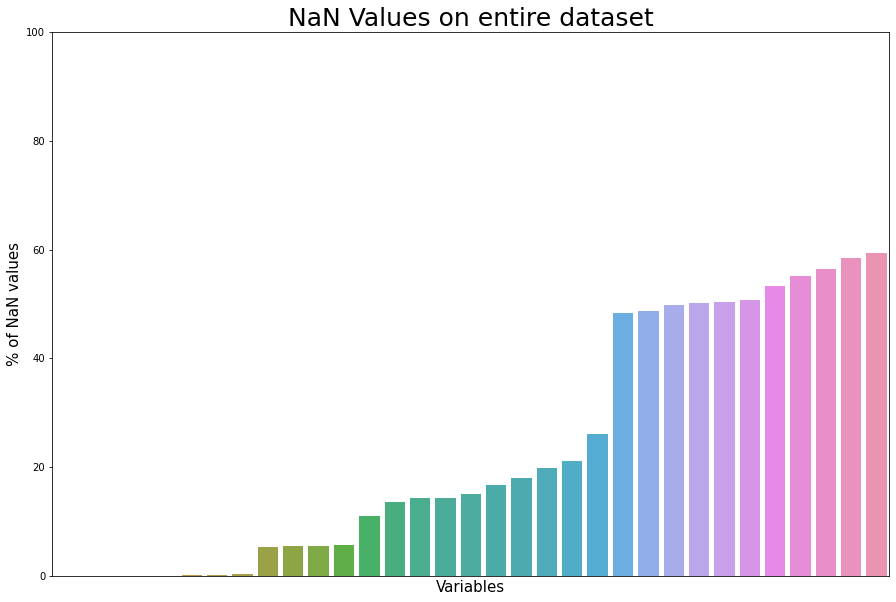

In [40]:
plot_nan_in_pourcent_from_data(df_train)

## Correlations

One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

 - .00-.19 “very weak”
 - .20-.39 “weak”
 - .40-.59 “moderate”
 - .60-.79 “strong”
 - .80-1.0 “very strong”

In [41]:
with timer("Computing the correlation between variables"):
    df_train_corr = get_correlations(df_train, 'TARGET')

Computing the correlation between variables - done in 103s


<AxesSubplot:>

/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


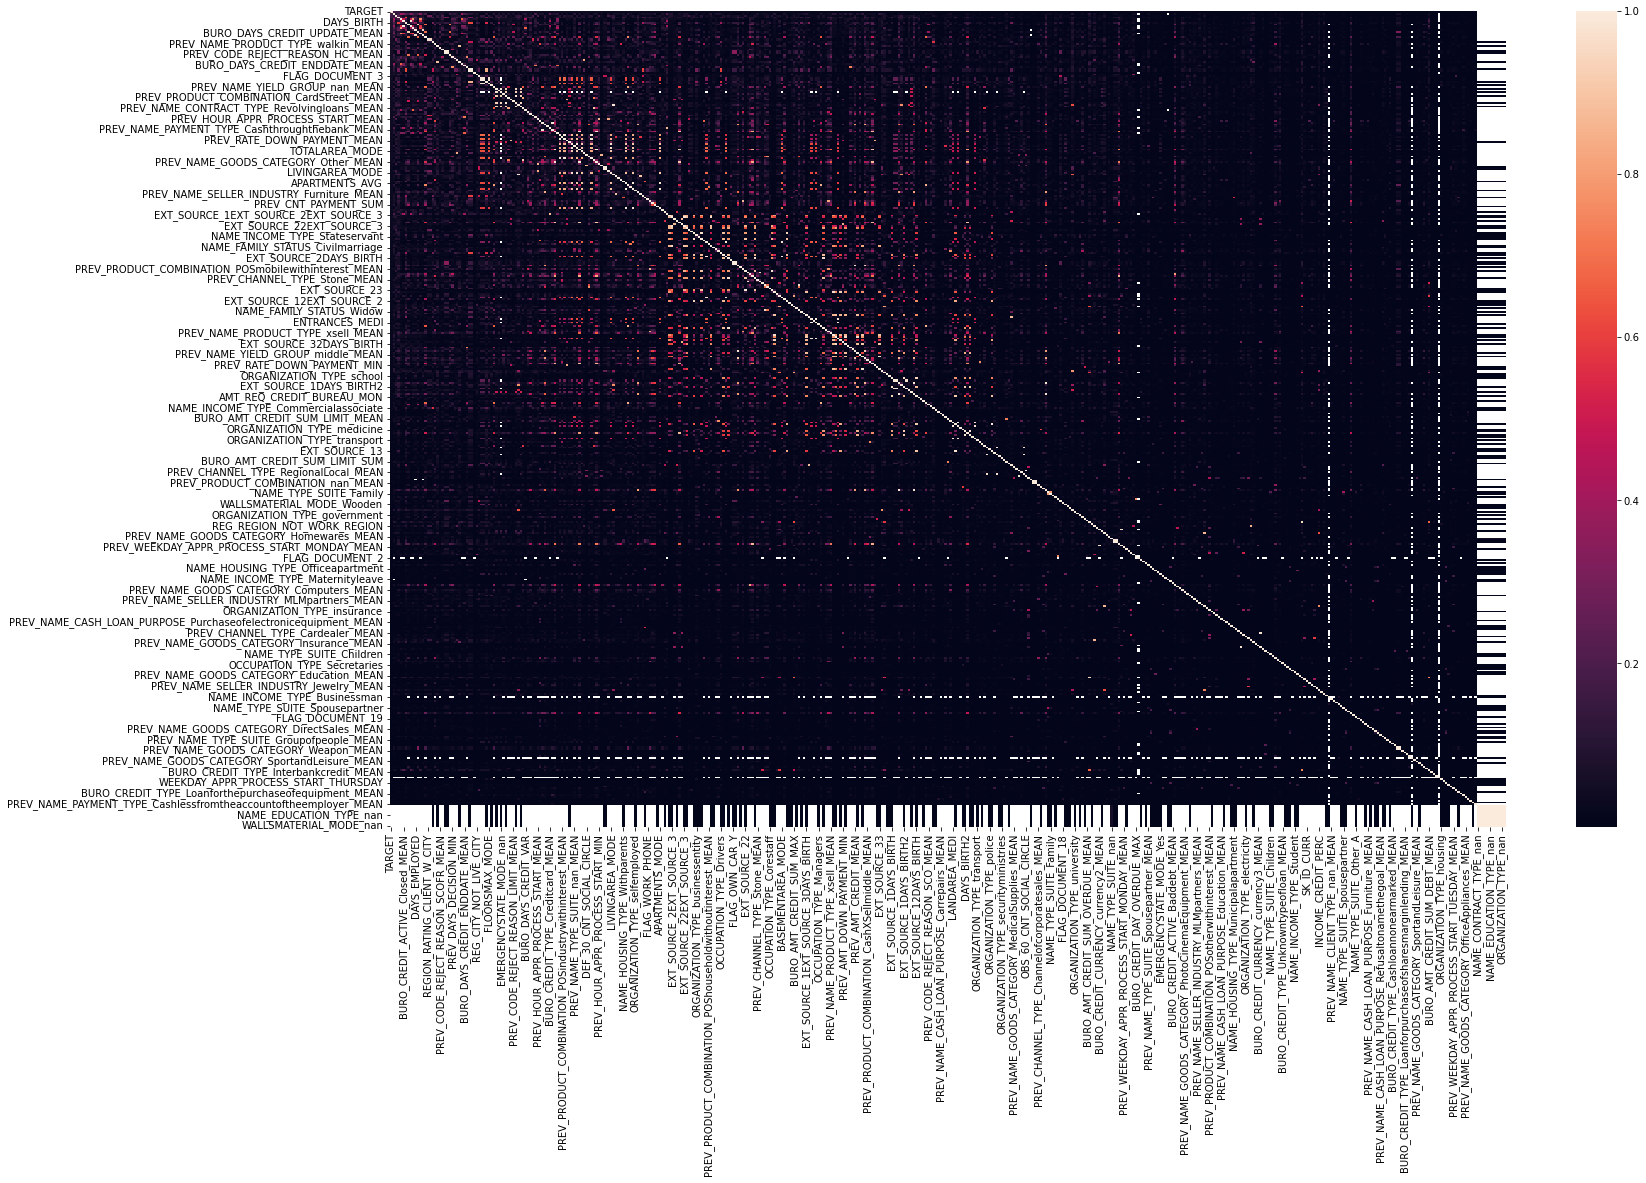

In [42]:
fig = plt.figure(figsize=(25, 15));
sns.heatmap(df_train_corr);
fig.title = 'Pearson correlation coefficient between every variable'
fig.show()

We see that there are variables that are very little corelated with the TARGET. We porpose to simplify the dataset by reducing theese variables from data. Also variables that are correlated between each other could be simplified by keeping just one of theese variables.

In [43]:
df_train.shape

#df = df_train.copy()
#hdc_make = False # high decorrelated with the TARGET
#hc_make = True # high correlated
#df_train_only_hc = remove_columns_regarding_correlation(df, df_train_corr, var='TARGET', hdc_make=hdc_make, hc_make=hc_make)
#df_train_only_hc.shape

df = df_train.copy()
hdc_make = True # high decorrelated with the TARGET
hc_make = True # high correlated
df_train_hc_and_hdc = remove_columns_regarding_correlation(df, df_train_corr, var='TARGET', hdc_make=hdc_make, hc_make=hc_make)
df_train_hc_and_hdc.shape

df_train.describe(include="all")

(307511, 457)

(307511, 185)

SK_ID_CURR        TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307507.000000  307507.00000  307507.000000      3.075070e+05   
mean   278181.527256       0.08073       0.417047      1.687977e+05   
std    102790.132982       0.27242       0.722119      2.371246e+05   
min    100002.000000       0.00000       0.000000      2.565000e+04   
25%    189146.500000       0.00000       0.000000      1.125000e+05   
50%    278203.000000       0.00000       0.000000      1.471500e+05   
75%    367143.500000       0.00000       1.000000      2.025000e+05   
max    456255.000000       1.00000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075070e+05  307495.000000     3.072290e+05   
mean   5.990286e+05   27108.666786     5.383977e+05   
std    4.024926e+05   14493.798379     3.694472e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307507.000000  307507.000000  252133.000000  ...   
mean                     0.020868  -16037.027271   -2384.142254  ...   
std                      0.013831    4363.982424    2338.327666  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -3175.000000  ...   
50%                      0.018850  -15750.000000   -1648.000000  ...   
75%                      0.028663  -12413.000000    -767.000000  ...   
max                      0.072508   -7489.000000       0.000000  ...   

       PREV_PRODUCT_COMBINATION_CashXSellmiddle_MEAN  \
count                                  291053.000000   
mean                                        0.062555   
std                                         0.133853   
min                                         0.000000   
25%                                         0.000000   
50%                                         0.000000   
75%                                         0.000000   
max                                         1.000000   

       PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN  \
count                                      291053.000000        
mean                                            0.206853        
std                                             0.293253        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                             0.333333        
max                                             1.000000        

       PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN  \
count                                      291053.000000           
mean                                            0.066188           
std                                             0.180909           
min                                             0.000000           
25%                                             0.000000           
50%                                             0.000000           
75%                                             0.000000           
max                                             1.000000           

       PREV_PRODUCT_COMBINATION_POSindustrywithinterest_MEAN  \
count                                      291053.000000       
mean                                            0.086598       
std                                             0.215790       
min                                             0.000000       
25%                                             0.000000       
50%                                             0.000000       
75%                                             0.000000       
max      

In [41]:
with timer("Imputing data with SimpleImputer stratagy median"):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    df_train_only_hc[:] = imputer.fit_transform(df_train_only_hc)

Imputing data with SimpleImputer stratagy median - done in 30s


In [42]:
df_train_hc_and_hdc = feature_selection(df_train_only_hc, k=200)

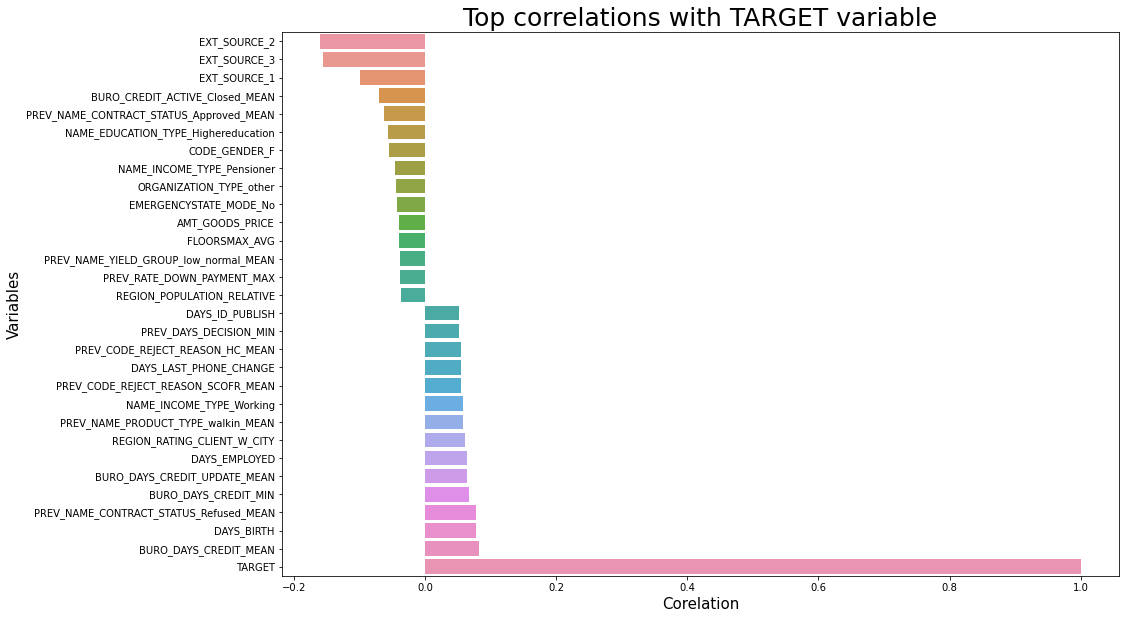

In [43]:
correlations = df_train_hc_and_hdc.corr()['TARGET'].sort_values()
dd_most_negative = pd.DataFrame(correlations[(~correlations.isna()) & (correlations!='TARGET')].head(15))
dd_most_positive = pd.DataFrame(correlations[(~correlations.isna()) & (correlations!='TARGET')].tail(15))
frames = [dd_most_negative, dd_most_positive]
correlations_margins = pd.concat(frames)
del dd_most_negative, dd_most_positive, frames
correlations[~correlations.isna()]
fig = plt.figure(figsize=(15, 10));
sns.barplot(y = correlations_margins.index, x = 'TARGET', data = correlations_margins )
plt.title('Top correlations with TARGET variable',fontsize=25);
plt.xlabel('Corelation',fontsize=15);
plt.ylabel('Variables',fontsize=15);

Let's take a look at some of more significant correlations: the `DAYS_BIRTH` and the created feature `BURO_DAYS_CREDIT_MEAN` is the most positive correlation variable from the df_train. (except for `TARGET` because the correlation of a variable with itself is always 1!). The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_`, `EXT_SOURCE_`, and `EXT_SOURCE_`.We can shortly thake a look at these variables. We can show the correlations of the EXT_SOURCE features with the target and with each other.

In [44]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = df_train_hc_and_hdc[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'BURO_DAYS_CREDIT_MEAN']]
plot_correlation(ext_data)

All three EXT_SOURCE featureshave negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

<Figure size 720x864 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='EXT_SOURCE_1', ylabel='Density'>

<AxesSubplot:xlabel='EXT_SOURCE_1', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of EXT_SOURCE_1 by Target Value')

Text(0.5, 0, 'EXT_SOURCE_1')

Text(0, 0.5, 'Density')

<AxesSubplot:>

<AxesSubplot:xlabel='EXT_SOURCE_2', ylabel='Density'>

<AxesSubplot:xlabel='EXT_SOURCE_2', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of EXT_SOURCE_2 by Target Value')

Text(0.5, 0, 'EXT_SOURCE_2')

Text(0, 0.5, 'Density')

<AxesSubplot:>

<AxesSubplot:xlabel='EXT_SOURCE_3', ylabel='Density'>

<AxesSubplot:xlabel='EXT_SOURCE_3', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of EXT_SOURCE_3 by Target Value')

Text(0.5, 0, 'EXT_SOURCE_3')

Text(0, 0.5, 'Density')

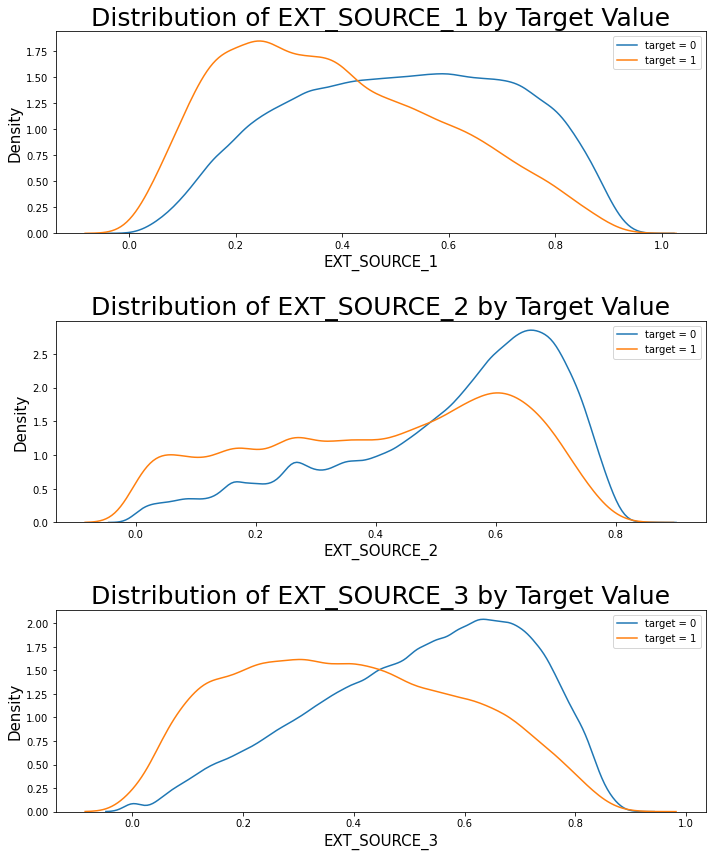

In [45]:
plt.figure(figsize = (10, 12));

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1);
    # plot repaid loans
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target = 0');
    # plot loans that were not repaid
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target = 1');
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source, fontsize=25);
    plt.xlabel('%s' % source, fontsize=15); 
    plt.ylabel('Density',fontsize=15);
    plt.legend();
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

# Data Preparation

In [44]:
df_train = df_train_hc_and_hdc

## Imputing the nan values

In [45]:
with timer("Imputing data with SimpleImputer stratagy median"):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    df_train[:] = imputer.fit_transform(df_train)

Imputing data with SimpleImputer stratagy median - done in 11s


## Separation of data and the target

In [46]:
# Given data
X = df_train.drop(["TARGET"], axis=1)
# Data to predict
y = df_train["TARGET"]

## Data Normalization

In [47]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X = pd.DataFrame(std_scale.transform(X), columns=X.columns)

## Data Splitting

Split the whole dataset into a training set (80% of data) and a test set (20% of data)
The dataset will be split in a stratified way, in order to have a good distribution of the target variable.

In [48]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y)

In [49]:
# Save the processed data
X_train.to_csv("data/preprocess/X_train.csv", index=False)
X_test.to_csv("data/preprocess/X_test.csv", index=False)
y_train.to_csv("data/preprocess/y_train.csv", index=False)
y_test.to_csv("data/preprocess/y_test.csv", index=False)

## Rebalancing Dataset

We can take into consideration tow type of balancing the data. First with the undersampling and second the oversampling as shown in the figure.

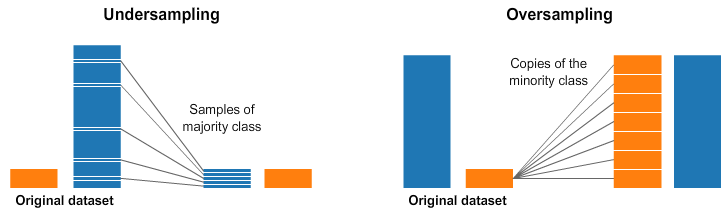

First we consider the undersampling.

In [50]:
if os.path.exists("data/preprocess/X_train_ubalanced.csv") and os.path.exists("data/preprocess/y_train_ubalanced.csv"):
    X_train = pd.read_csv("data/preprocess/X_train_ubalanced.csv")
    y_train = pd.read_csv("data/preprocess/y_train_ubalanced.csv")
else:
    # eliminate imbalance by randomly removing data points from the majority class
    
    random_sampler = RandomUnderSampler(
        sampling_strategy=1.,
    )
    X_train, y_train = random_sampler.fit_resample(X_train, y_train)

    # Save the processed data
    X_train.to_csv("data/preprocess/X_train_ubalanced.csv", index=False)
    y_train.to_csv("data/preprocess/y_train_ubalanced.csv", index=False)
    X_train = pd.read_csv("data/preprocess/X_train_ubalanced.csv")
    y_train = pd.read_csv("data/preprocess/y_train_ubalanced.csv")

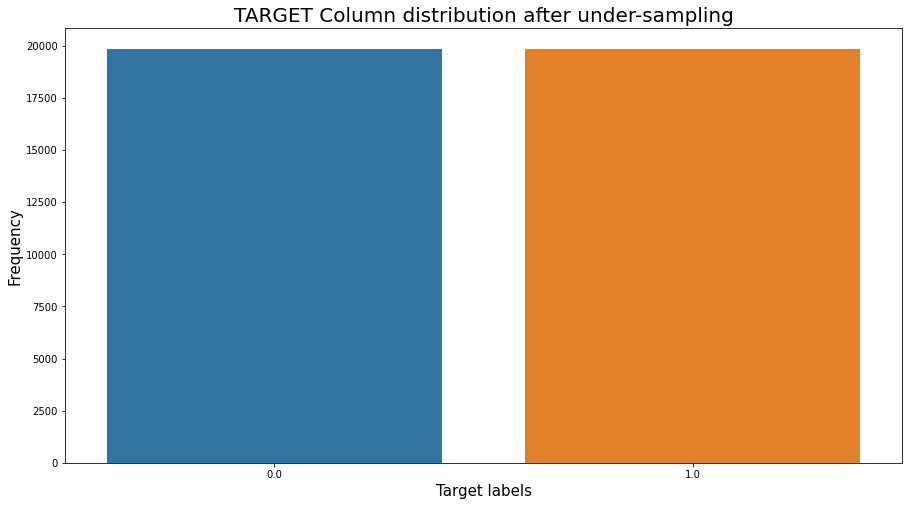

In [51]:
plt.figure(figsize=(15,8))
sns.barplot(x = y_train.TARGET.value_counts().index, y = y_train.TARGET.value_counts(), data = y_train)
plt.title('TARGET Column distribution after under-sampling', fontsize=20);
plt.xlabel('Target labels', fontsize=15);
plt.ylabel('Frequency', fontsize=15);
plt.show();

Next we consider the oversampling.

In [52]:
if os.path.exists("data/preprocess/X_train_obalanced.csv") and os.path.exists("data/preprocess/y_train_obalanced.csv"):
    X_train = pd.read_csv("data/preprocess/X_train_obalanced.csv")
    y_train = pd.read_csv("data/preprocess/y_train_obalanced.csv")
else:
    # eliminate imbalance by randomly removing data points from the majority class
    # transform the dataset
    X_train = pd.read_csv("data/preprocess/X_train.csv")
    y_train = pd.read_csv("data/preprocess/y_train.csv")
    
    oversample = SMOTE()
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    # Save the processed data
    X_train.to_csv("data/preprocess/X_train_obalanced.csv", index=False)
    y_train.to_csv("data/preprocess/y_train_obalanced.csv", index=False)
    X_train = pd.read_csv("data/preprocess/X_train_obalanced.csv")
    y_train = pd.read_csv("data/preprocess/y_train_obalanced.csv")

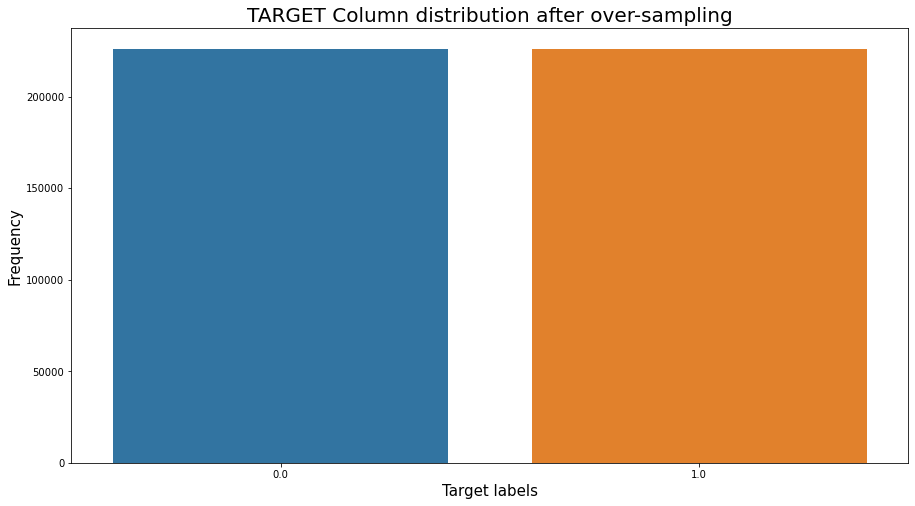

In [53]:
plt.figure(figsize=(15,8))
sns.barplot(x = y_train.TARGET.value_counts().index, y = y_train.TARGET.value_counts(), data = y_train)
plt.title('TARGET Column distribution after over-sampling', fontsize=20);
plt.xlabel('Target labels', fontsize=15);
plt.ylabel('Frequency', fontsize=15);
plt.show();

And finally the third type of dataset we create is by combining SMOTE with random undersampling of the majority class. We can update the example to first oversample the minority class to have 10 percent the number of examples of the majority class (e.g. about 1,000), then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class (e.g. about 2,000).

In [54]:
if os.path.exists("data/preprocess/X_train_oubalanced.csv") and os.path.exists("data/preprocess/y_train_oubalanced.csv"):
    X_train = pd.read_csv("data/preprocess/X_train_oubalanced.csv")
    y_train = pd.read_csv("data/preprocess/y_train_oubalanced.csv")
else:
    over = SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler()#sampling_strategy=0.1)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # eliminate imbalance by randomly removing data points from the majority class
    # transform the dataset
    X_train = pd.read_csv("data/preprocess/X_train.csv")
    y_train = pd.read_csv("data/preprocess/y_train.csv")
    
    X_train, y_train = pipeline.fit_resample(X_train, y_train)

    # Save the processed data
    X_train.to_csv("data/preprocess/X_train_oubalanced.csv", index=False)
    y_train.to_csv("data/preprocess/y_train_oubalanced.csv", index=False)
    X_train = pd.read_csv("data/preprocess/X_train_oubalanced.csv")
    y_train = pd.read_csv("data/preprocess/y_train_oubalanced.csv")

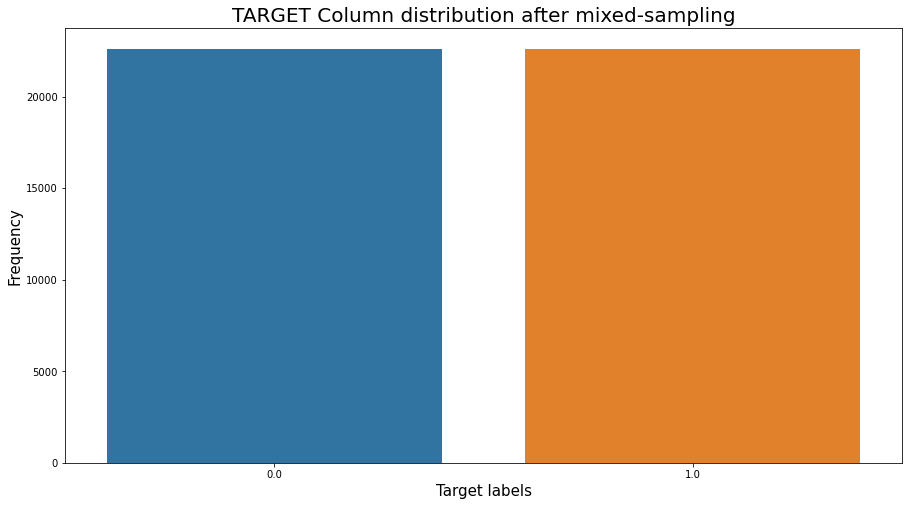

In [55]:
plt.figure(figsize=(15,8))
sns.barplot(x = y_train.TARGET.value_counts().index, y = y_train.TARGET.value_counts(), data = y_train)
plt.title('TARGET Column distribution after mixed-sampling', fontsize=20);
plt.xlabel('Target labels', fontsize=15);
plt.ylabel('Frequency', fontsize=15);
plt.show();

# Loading dataset

In [72]:
X_train = pd.read_csv("data/preprocess/X_train_oubalanced.csv")
y_train = pd.read_csv("data/preprocess/y_train_oubalanced.csv")
X_test = pd.read_csv("data/preprocess/X_test.csv")
y_test = pd.read_csv("data/preprocess/y_test.csv")

# ACP

Now, we can start to create our models in order to make predictions on TARGET. But, first we can make a PCA in order to project the observations and see them in a 2D plan. We take 75 principal components that cover more then 80% of information in data.

In [57]:
X = X_train.values
names = X_train.index #["product_name"] # ou data.index pour avoir les intitulés
features = X_train.columns

# choix du nombre de composantes à calculer
n_comp = 2

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_train)

X_projected = pca.fit_transform(X_train)


X_projected = pd.DataFrame(X_projected, index = names, columns = ['F{0}'.format(i) for i in range(n_comp)])

# Eboulis des valeurs propres
#display_scree_plot(pca)

PCA(n_components=2)

In [58]:
pd.concat([X_projected, y_train], axis=1).TARGET.unique()

array([0., 1.])

In [60]:
y_train.astype({'TARGET': 'int32'}).dtypes

TARGET    int32
dtype: object

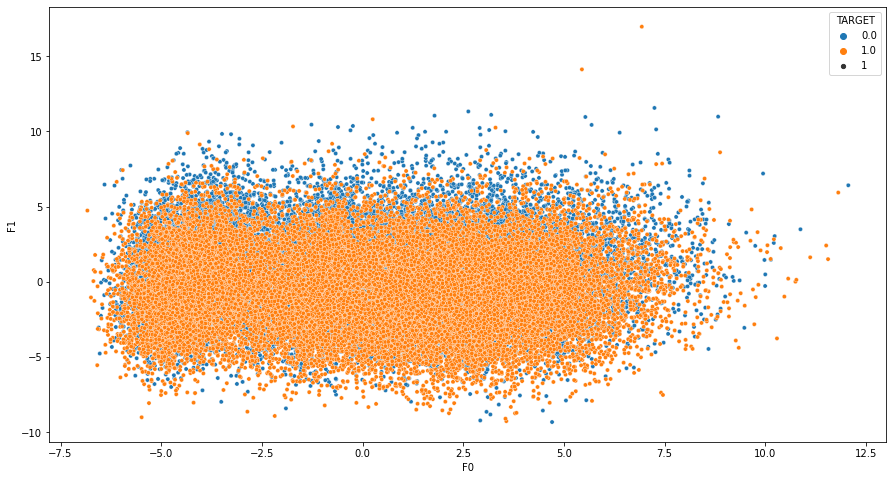

In [61]:
plt.figure(figsize=(15,8));
sns.scatterplot(
        x='F0',
        y='F1',
    hue = 'TARGET',
    data = pd.concat([X_projected, y_train], axis=1),
    size=1
);

In the previous figure we observe that we have observations that are not easly separated with a line. Also it will be difficult to find a model without an over-learning. The risc to find a lot of FP (false positives) and FN (false negative) is high. Therefore, in order to evaluate our models a simple accurancy metric is not sufficient, and a contingency matrix is higher recomended for such classifications problems.

# Model creation and application

For a naive baseline, we could guess the same value for all examples on the testing set. We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition. We try other 8 models to get a higher score.

In [74]:
results = pd.read_csv("data/preprocess/results_beta2.csv", index_col=0)
with open("models_beta2.pckl", "rb") as f:
    models = pickle.load(f)

Plotting some of our results, starting with the dummy classifier.

/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


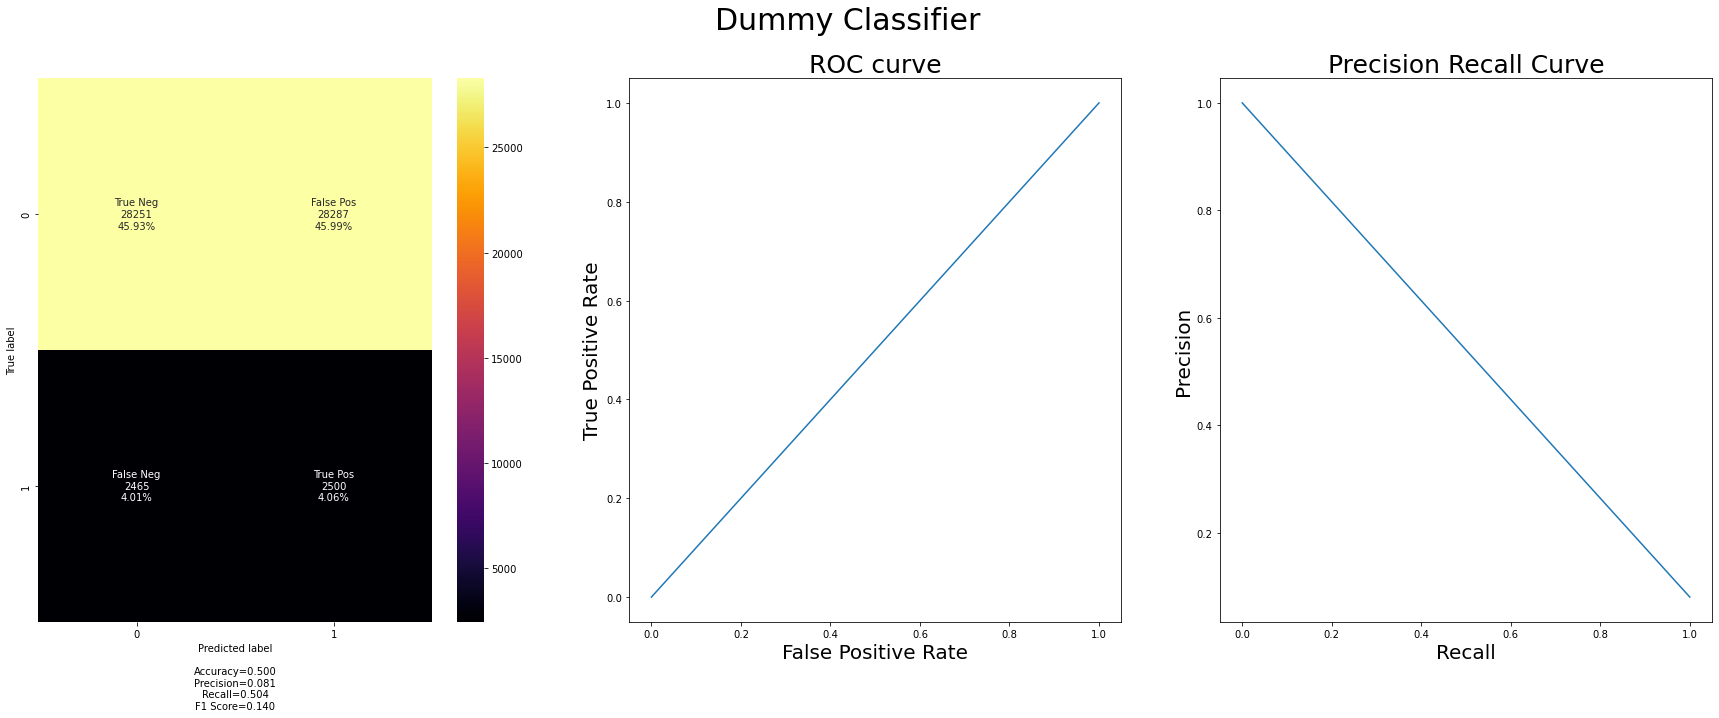

In [64]:
plot_result_stats(models['dummy'], title_fig = 'Dummy Classifier')

Let's know use a slightly more sophisticated model for our actual baseline: ***Logistic regression***.

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


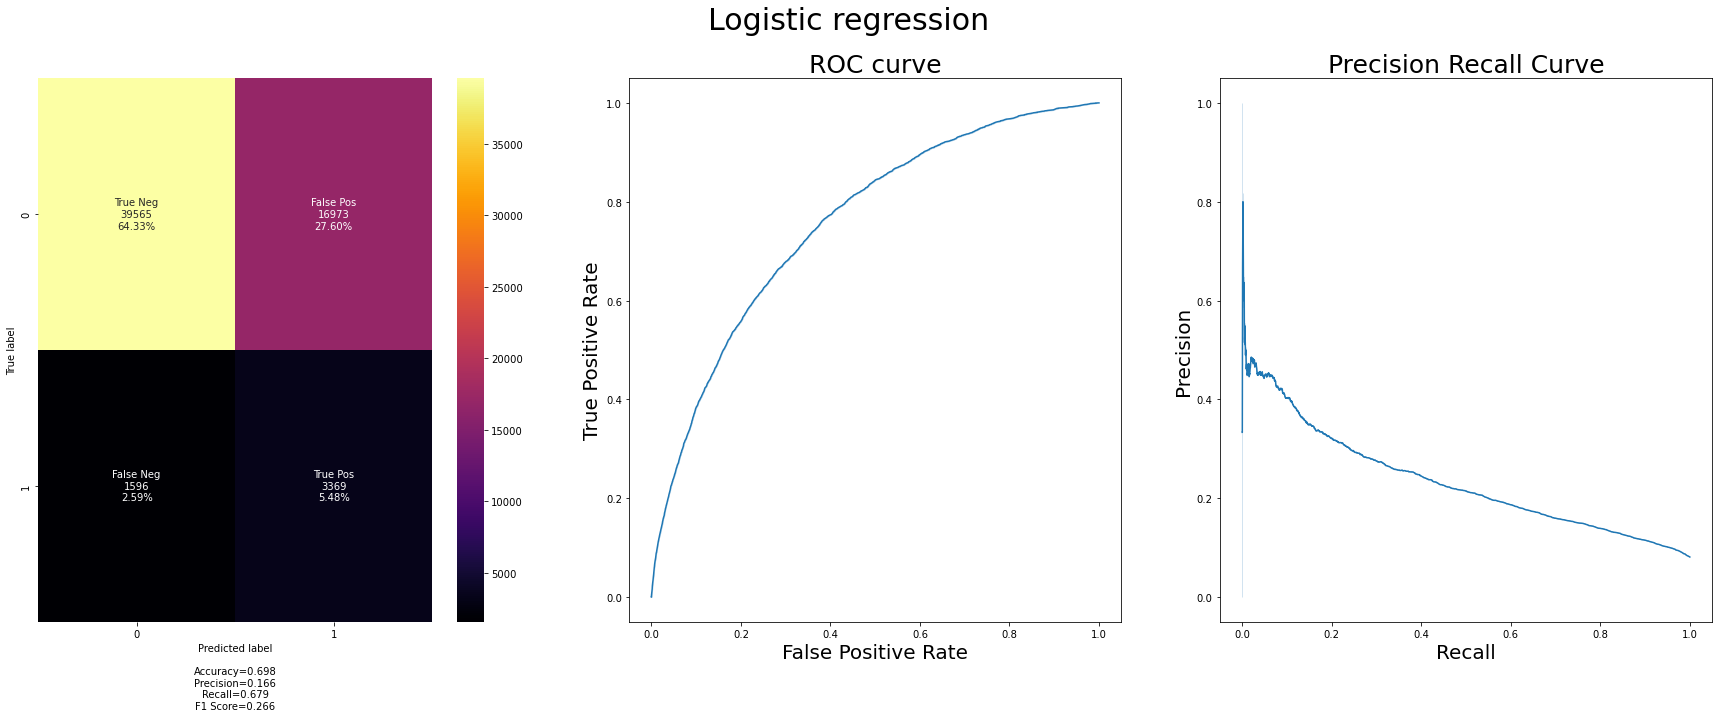

In [70]:
plot_result_stats(models['logreg'], title_fig = 'Logistic regression')

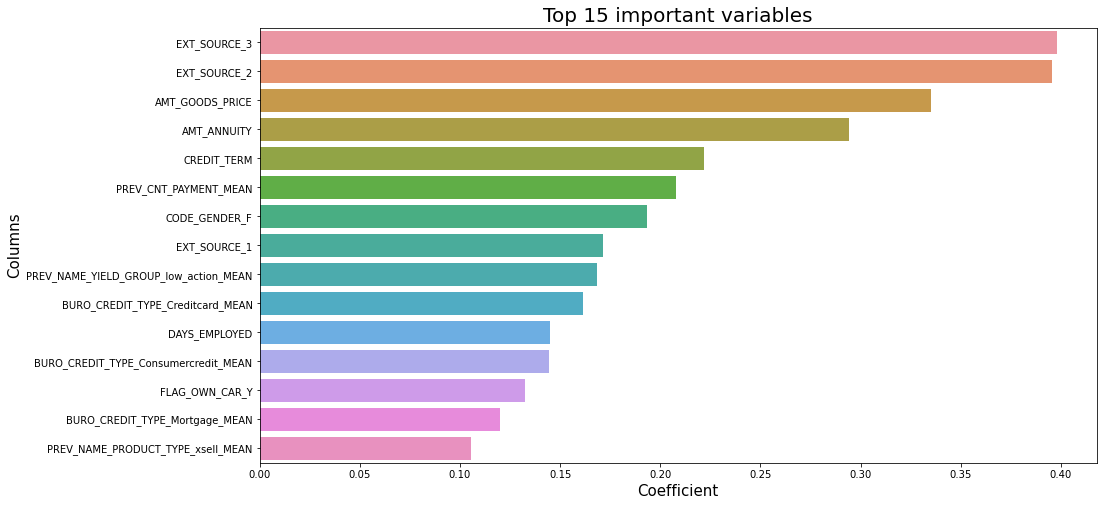

In [73]:
plot_varimportance(model_res = models['logreg'], cols = X_train.columns, cols_nr = 15)

/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


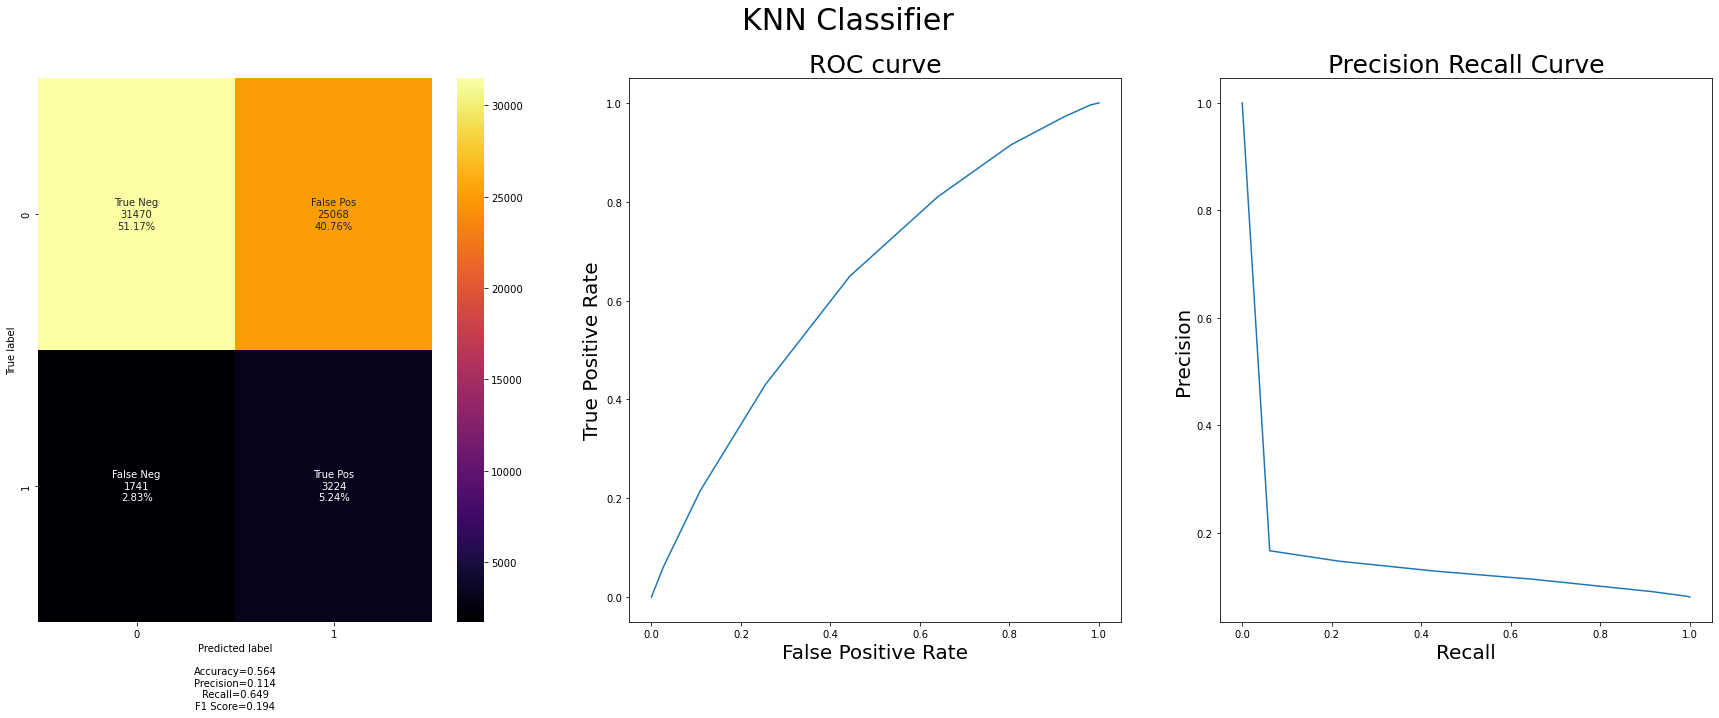

In [65]:
plot_result_stats(models['knn'], title_fig = 'KNN Classifier')

/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


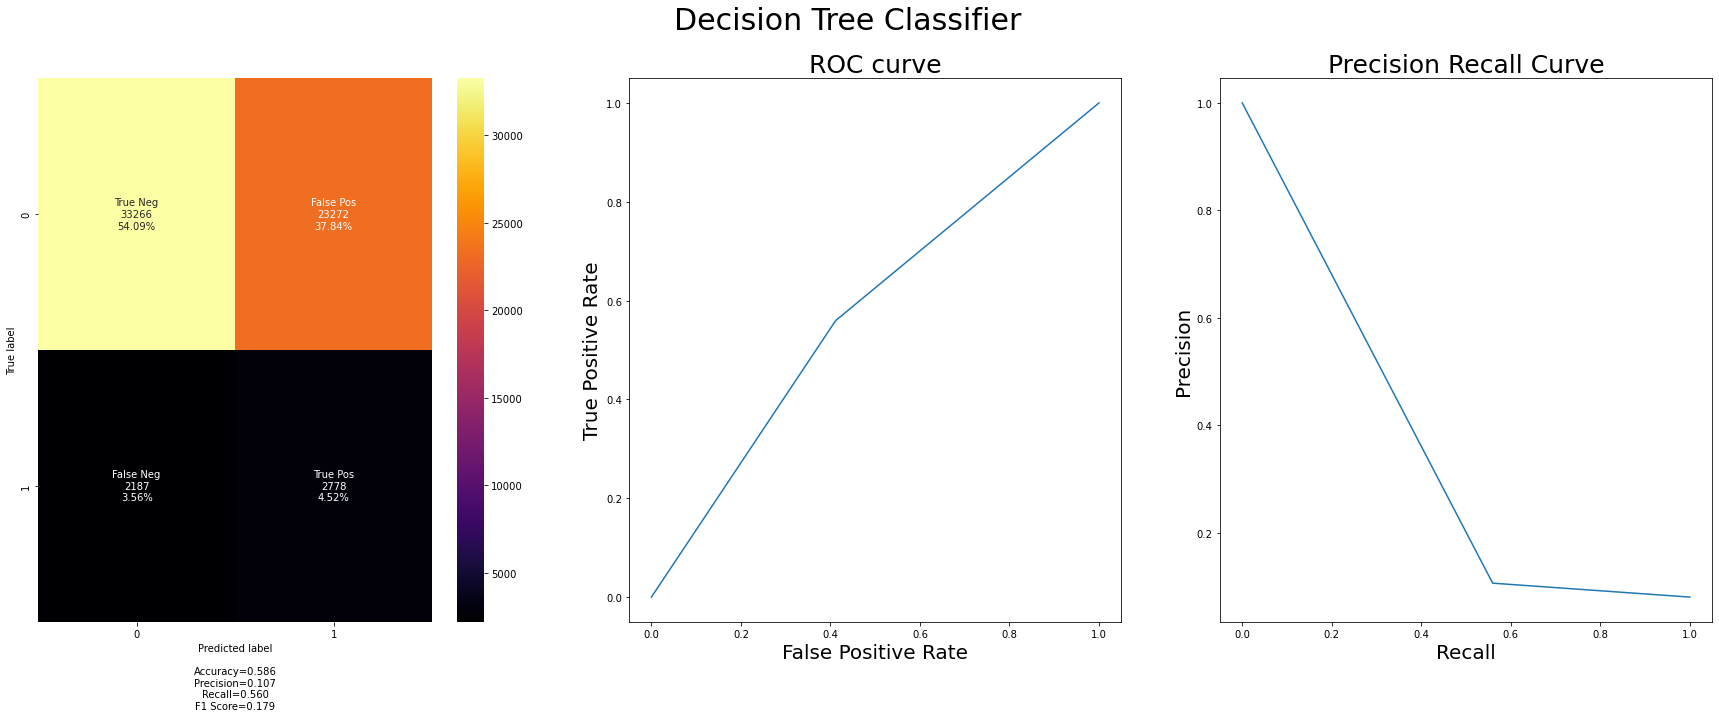

In [66]:
plot_result_stats(models['dctree'], title_fig = 'Decision Tree Classifier') 

/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


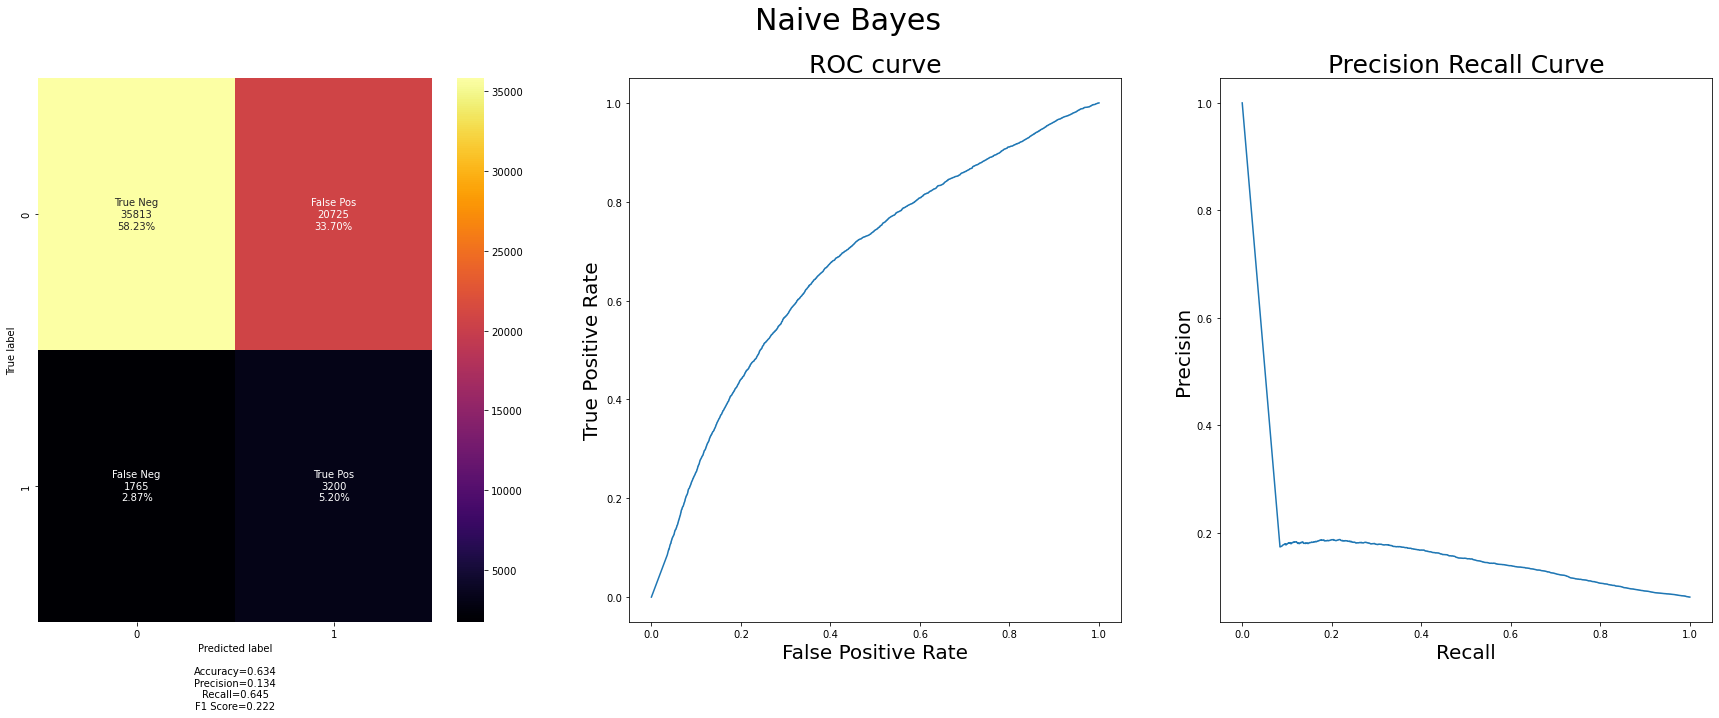

In [67]:
plot_result_stats(models['naivebayes'], title_fig = 'Naive Bayes')

/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


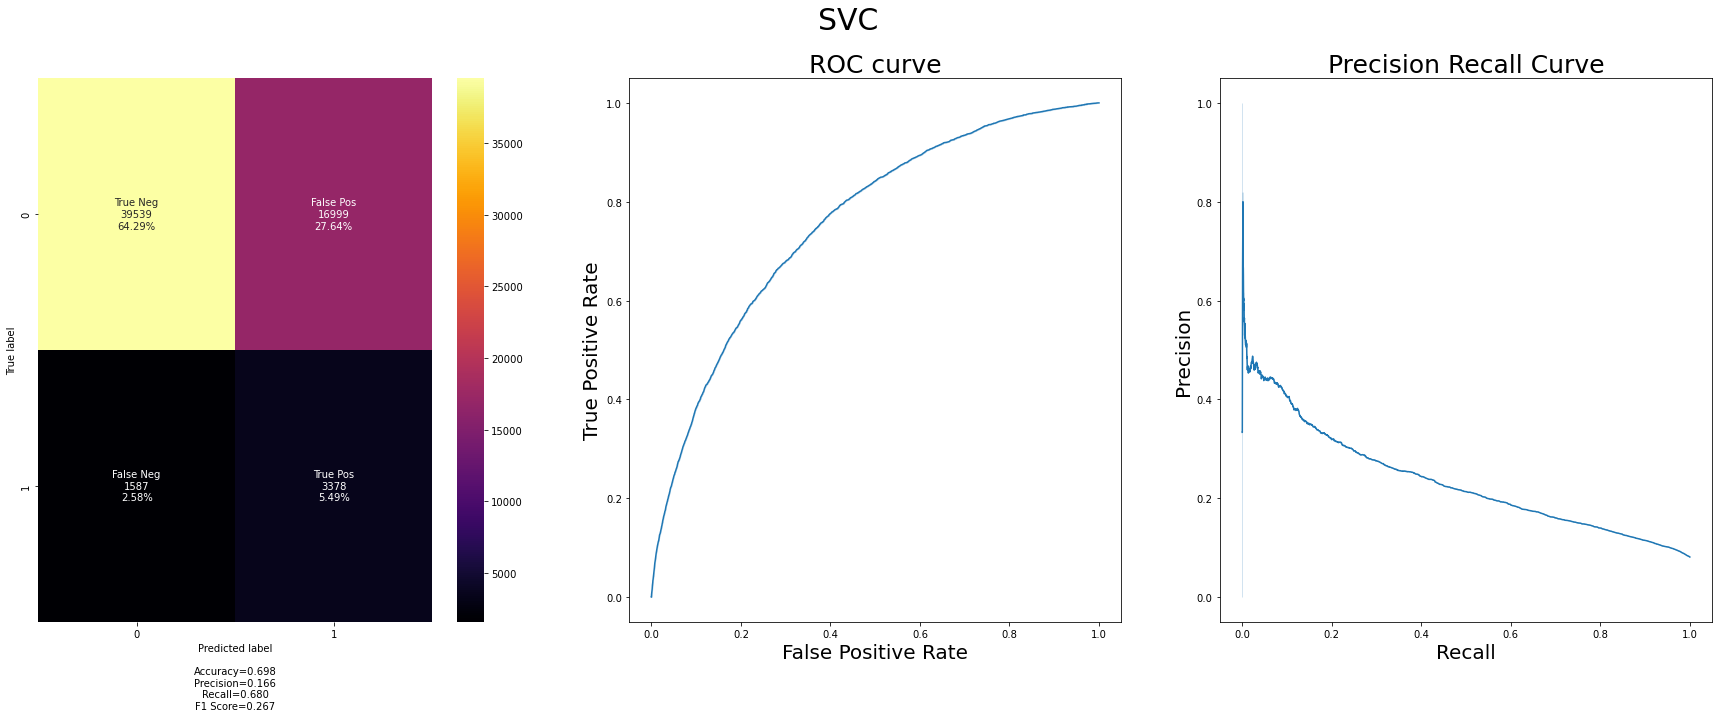

In [68]:
plot_result_stats(models['svc'], title_fig = 'SVC')

/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


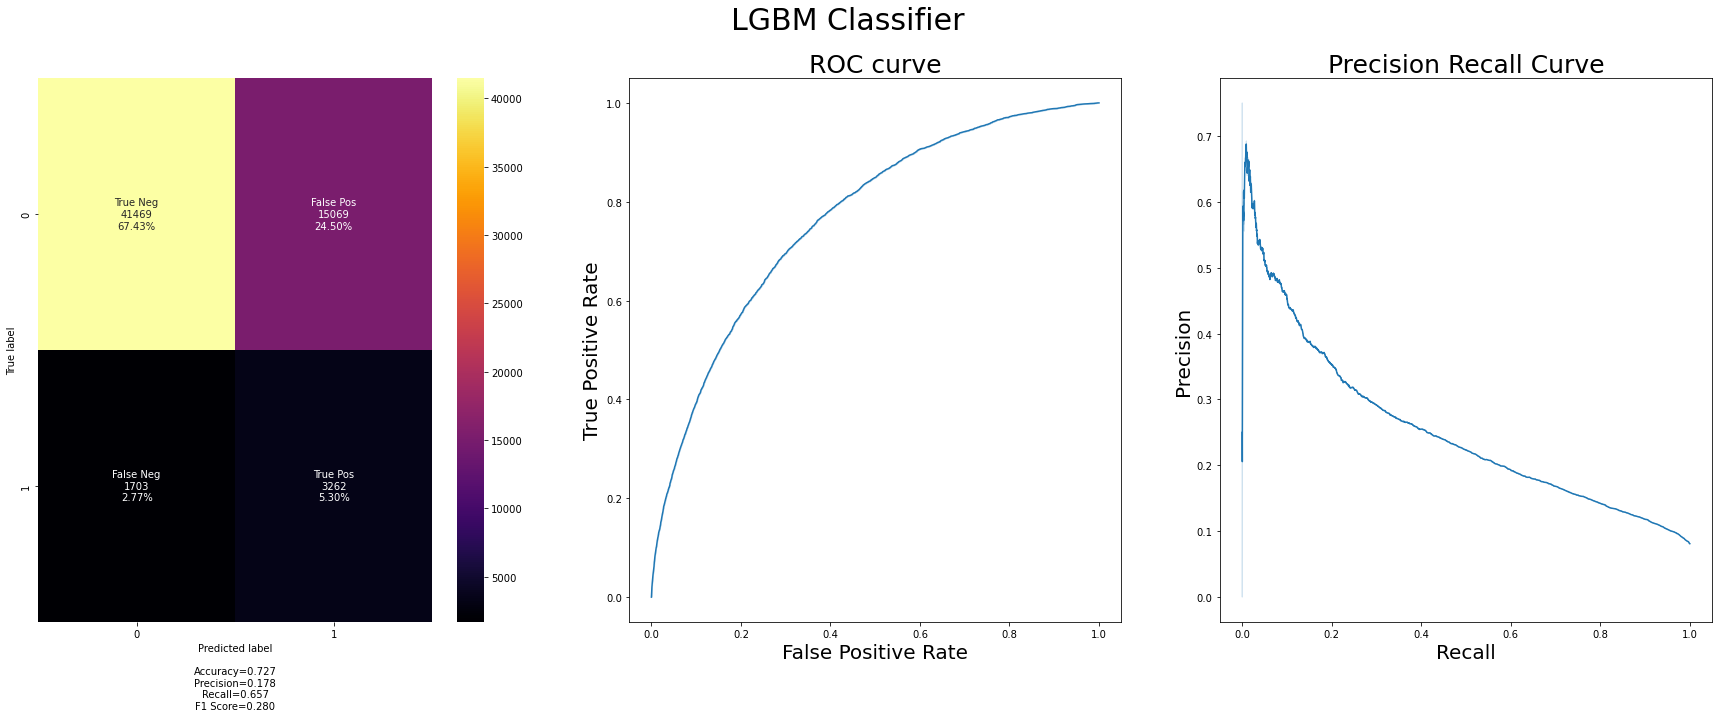

In [69]:
plot_result_stats(models['lgbm'], title_fig = 'LGBM Classifier')

<AxesSubplot:xlabel='index'>

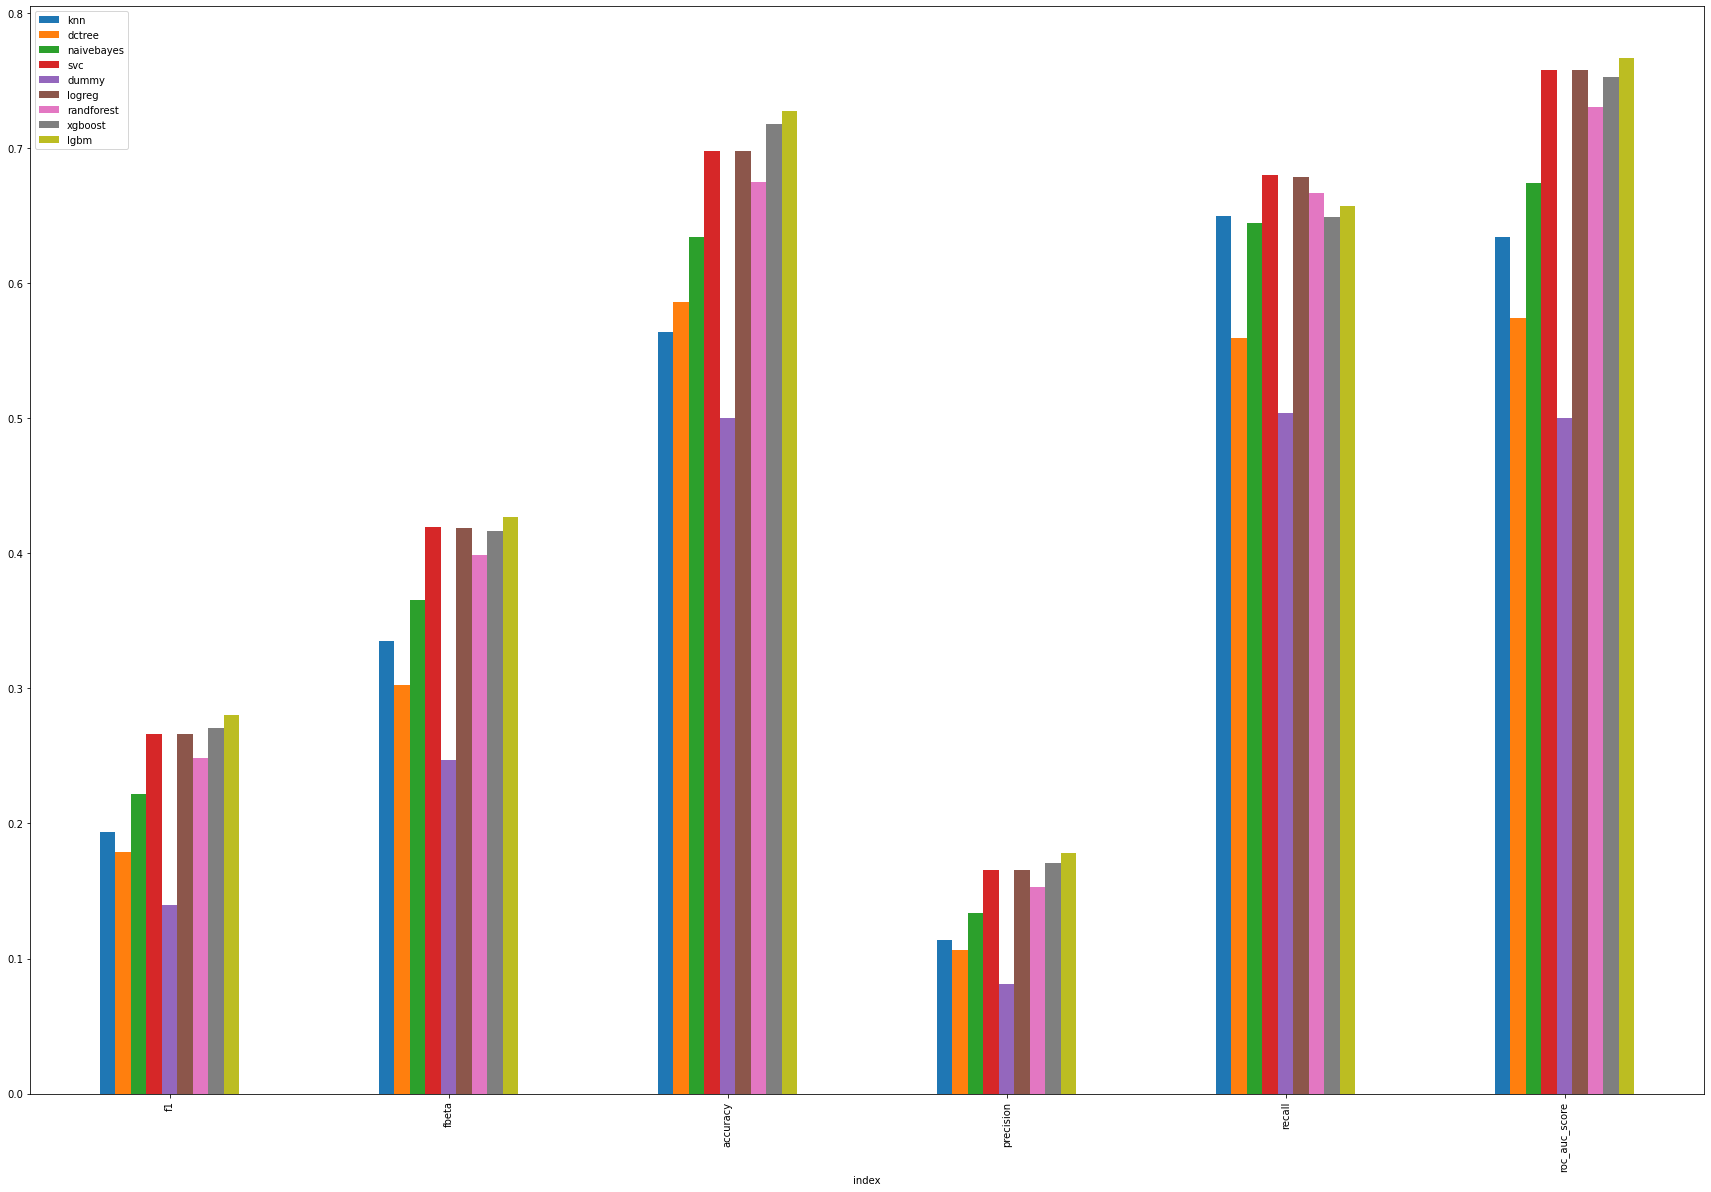

In [23]:
df=pd.DataFrame(results, columns=["f1", "fbeta", "accuracy", "precision", "recall", "roc_auc_score"]).T
df = df.reset_index(level=0)
df.plot(x="index", y=["knn", "dctree", "naivebayes", "svc", "dummy", "logreg", "randforest", "xgboost", "lgbm"], kind="bar",figsize=(30,20))
plt.show()

First I note that the prediction time for KNN was slow and I choose not to show (45.58 s) it in the following figure.

<AxesSubplot:xlabel='index'>

Text(0.5, 0, 'Prediction time')

Text(0, 0.5, 'seconds')

Text(0.5, 1.0, 'Time performance of the trained models')

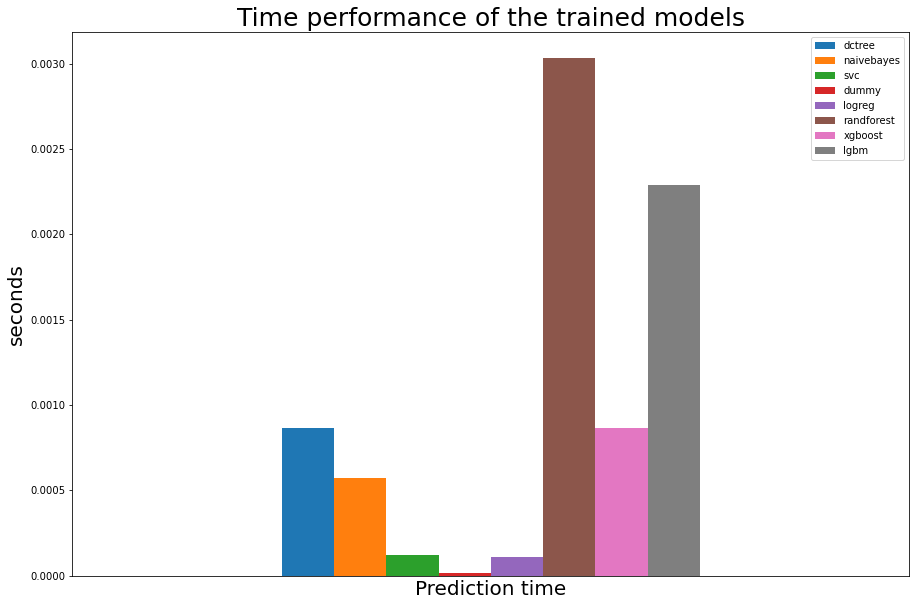

In [62]:
df=pd.DataFrame(results, columns=["predict_time"]).T.div(60)
df = df.reset_index(level=0)

df.plot(x="index", y=["dctree", "naivebayes", "svc", "dummy", "logreg", "randforest", "xgboost", "lgbm"], kind="bar",figsize=(15,10));
plt.tick_params(right = False , 
                labelbottom = False, bottom = False);
plt.xlabel('Prediction time', size=20);
plt.ylabel('seconds', size=20);
plt.title('Time performance of the trained models',size=25)
plt.show()

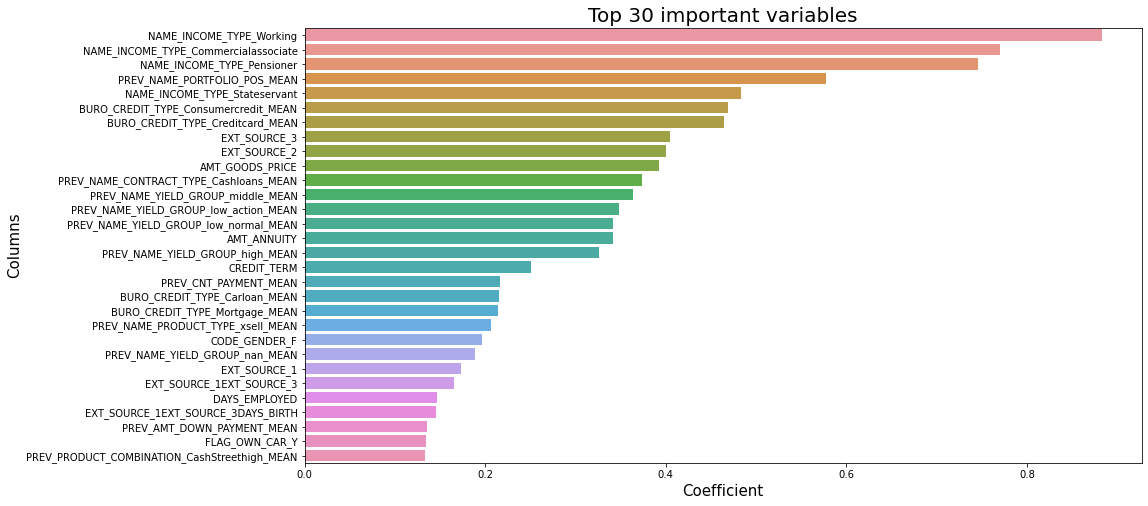

Here we note the most important variables due to the model regularization. We observe some variables generated from the previous application and bureau datasets. We can see that polynomial variables was also rather important for our model. The variables with the biggest absolute coefficient values are mostly used in the model. We can also say the correlations between the variables by comparing the coefficients. The closest the values are more correlated the variables.

# Model Exlpications
 - it is important to understand the performance of the machine learning models
 - ML metrics like accuracy, mean squared error, r2 score, etc does not give detailed insight into the performance of the model
 - eli5, LIME, SHAP, interpret,treeinterpreter, etc are available to debug models to better understand a model and its performance on any sample of the data.
 - help us better understand which feature is contributing to how in prediction.
 - We will use LIME (Local Interpretable Model-Agnostic Explanations Local Interpretable Model-Agnostic Explanations) and SHAP (SHapley Additive exPlanations) to analyze the performance of machine learning models.

In [6]:
sample_idx = 10

## LIME

In [8]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names= list(X_train.columns))

explanation = explainer.explain_instance(X_test.iloc[sample_idx],
                                        rand_forest_results['model'].predict_proba, 
                                         num_features=15)
explanation.show_in_notebook()

/opt/anaconda3/envs/oc4/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


## SHAP

In [87]:
import shap
shap.initjs()

print('True value : {0}'.format(y_test.iloc[sample]))

True value : TARGET    0.0
Name: 10, dtype: float64


### Create LinearExplainer

Below we have created LinearExplainer by giving model and train data as input. This will create an explainer which does not take the relationship between features considering the correlation between features.

In [85]:
lin_reg_explainer1 = shap.LinearExplainer(logistic_results['model'], X_train)

Below we have created another LinearExplainer by giving model and train data as input. We have also set feature_perturbation to correlation_dependent. This will create an explainer which takes into account the relationship between features.

In [108]:
lin_reg_explainer2 = shap.LinearExplainer(logistic_results['model'], X_train, feature_perturbation="correlation_dependent")

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

### Barplot

Generating a bar chart of shap values from our first explainer

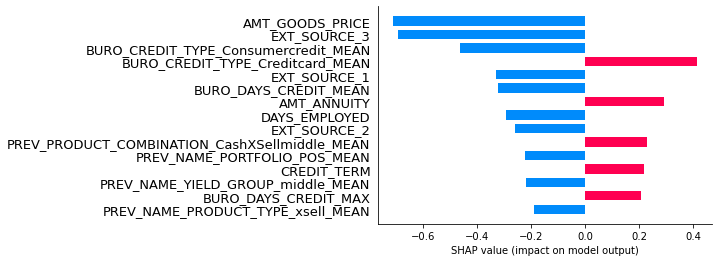

In [110]:
shap.bar_plot(lin_reg_explainer1.shap_values(X_test.iloc[sample_idx]),
              feature_names=X_train.columns,
              max_display=15)

We can see from the above bar chart that for this sample of data features (`AMT_GOODS_PRICE`, `EXT_SOURCE_3`, `BURO_CREDIT_TYPE_Consumecredit_MEAN`,...) contribute negatively and features (`BURO_CREDIT_TYPE_Creditcard_MEA`, `AMT_ANNUIT`, `PREV_PRODUCT_COMBINATION_CashXSmellmiddle_MEA` ...) contributes positively for final prediction.

Below we have generated another bar plot of shap values for our second explainer which was based on the relationship between features.

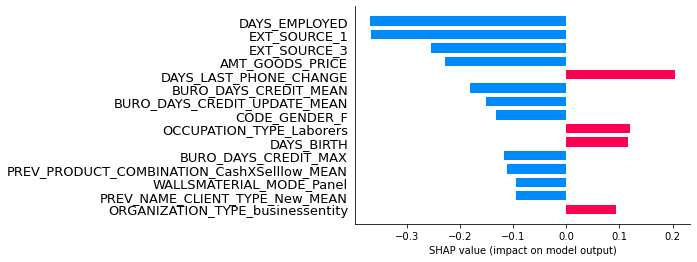

In [114]:
shap.bar_plot(lin_reg_explainer2.shap_values(X_test.iloc[sample_idx].to_numpy().reshape(1,-1))[0],
              feature_names=X_train.columns,
              max_display=15)

### Waterfall Plot

Another chart that we'll explain is a waterfall chart which shows how shap values of individual features are added to the base value in order to generate a final prediction. Below is a list of important parameters of the waterfall_plot() method.

We generate a waterfall plot for the first explainer object which does not consider the interaction between objects.

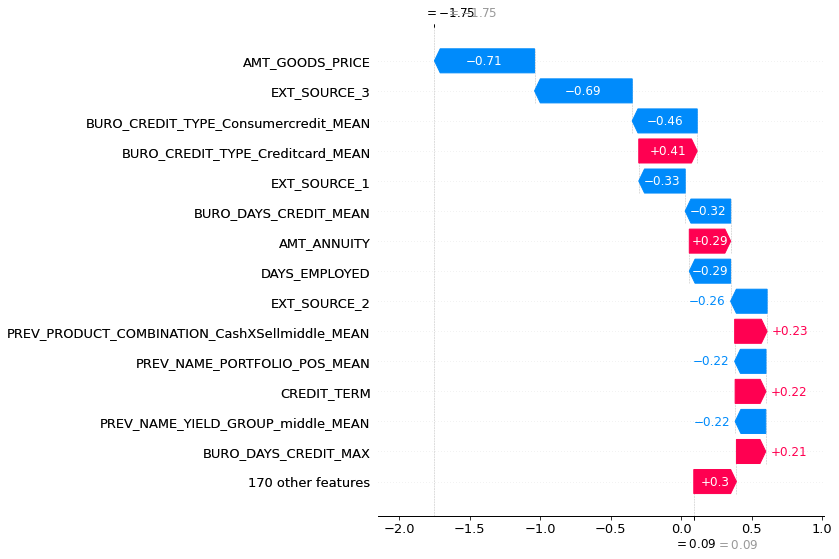

In [127]:
#shap.waterfall_plot(lin_reg_explainer1.expected_value,
#                    lin_reg_explainer1.shap_values(X_test.iloc[sample_idx]),
#                    feature_names=X_train.columns,
#                    max_display=15)
shap.plots._waterfall.waterfall_legacy(lin_reg_explainer1.expected_value,
                    lin_reg_explainer1.shap_values(X_test.iloc[sample_idx]),
                    feature_names=X_train.columns,
                    max_display=15);

Below we have generated a waterfall plot for the second explainer object which does consider the interaction between objects. We can notice in shap values generated by both explainers as one considers relationship and one does not.

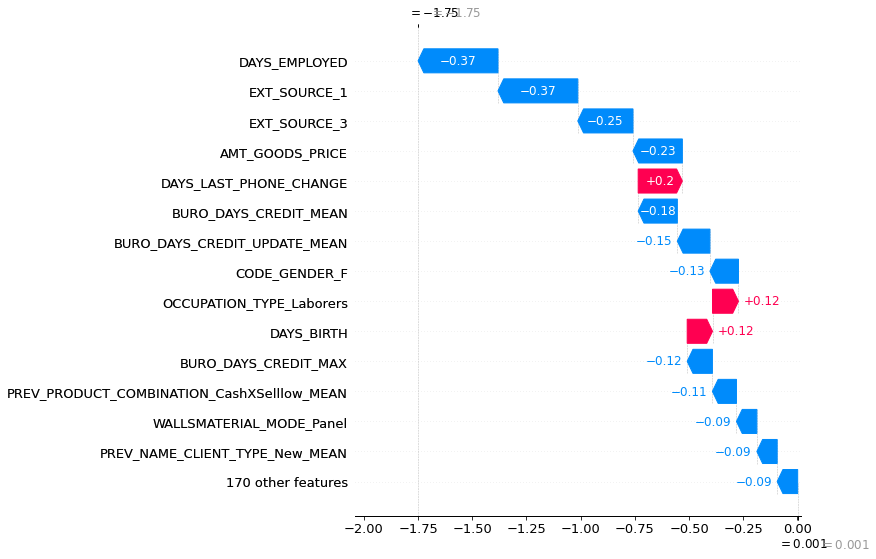

In [129]:
shap.plots._waterfall.waterfall_legacy(lin_reg_explainer2.expected_value,
                    lin_reg_explainer2.shap_values(X_test.iloc[sample_idx].to_numpy().reshape(1,-1))[0],
                    feature_names=X_train.columns,
                    max_display=15);

### Decision Plot
The decision plot shows like the waterfall chart show the decision path followed by applying the shap values of individual features one by one to the expected value in order to generate predicted value as a line chart.

The decision plot can be used to show a decision path followed for more than one sample as well. Below is a list of important parameters of the decision_plot() method.

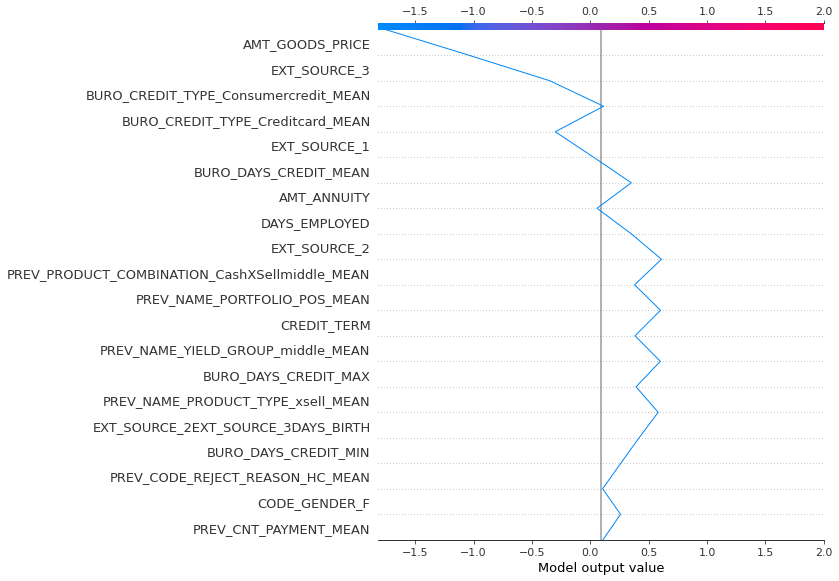

In [134]:
shap.decision_plot(lin_reg_explainer1.expected_value,
                   lin_reg_explainer1.shap_values(X_test.iloc[sample_idx]),
                   feature_names=list(X_train.columns)
                   )

Below we have created another decision plot of 5 samples from the test dataset using the first linear explainer. We have also highlighted 2nd and 3rd samples from a dataset with different line styles.

In [16]:
shap.decision_plot(lin_reg_explainer1.expected_value,
                   lin_reg_explainer1.shap_values(X_test.iloc[sample_idx:sample_idx+5]),
                   feature_names=list(X_train.columns),
                   highlight=[1, 2],
                   )

NameError: name 'shap' is not defined

### Dependence Plot
The dependence plot shows the relation between actual feature value and shap values for a particular feature of the dataset. We can generate a dependence plot using the dependence_plot() method. Below is a list of important parameters of the dependence_plot() method.

Below we have generated a dependence plot for the CRIM feature using our first linear explainer. It's also showing the interaction of feature with feature AGE whose values are shown as a color bar.

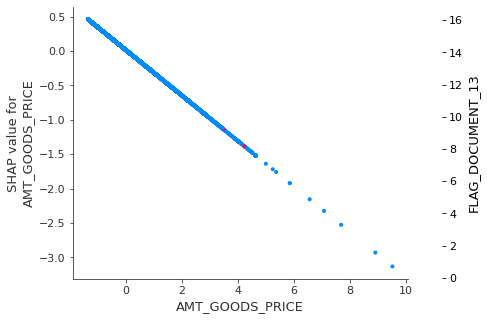

In [146]:
shap.dependence_plot("AMT_GOODS_PRICE",
                     lin_reg_explainer1.shap_values(X_test),
                     features=X_test,
                     feature_names=X_train.columns,
                     )

Below we have generated a dependence plot of feature CRIM using the test dataset and second linear explainer created earlier.

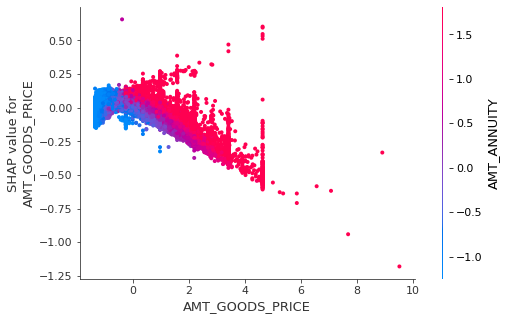

In [147]:
shap.dependence_plot("AMT_GOODS_PRICE",
                     lin_reg_explainer2.shap_values(X_test),
                     features=X_test,
                     feature_names=X_train.columns,
                     )

### Embedding Plot
The embedding plot projects shap values to 2D projection using PCA for visualization. This can help us see the spread of different shap values for a particular feature.

We can generate an embedding plot using the embedding_plot() method. Below is a list of important parameters of the embedding_plot() method.

Below we have generated an embedding plot for the CRIM feature on test data using our first linear explainer.

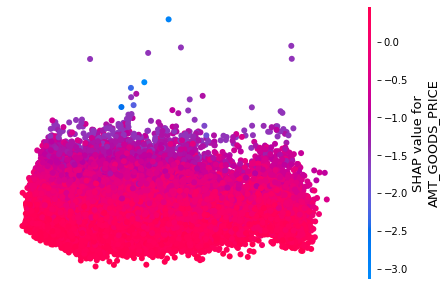

In [148]:
shap.embedding_plot("AMT_GOODS_PRICE",
                    lin_reg_explainer1.shap_values(X_test),
                    feature_names=X_train.columns)

In [ ]:
Below we have generated an embedding plot for the CRIM feature on test data using our second linear explainer.

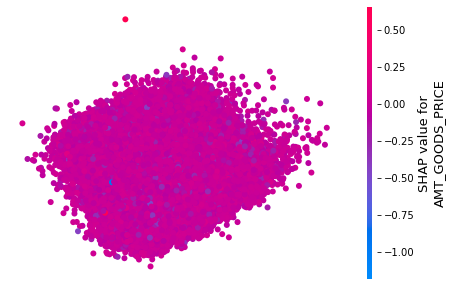

In [149]:
shap.embedding_plot("AMT_GOODS_PRICE",
                    lin_reg_explainer2.shap_values(X_test),
                    feature_names=X_train.columns)

### Force Plot
The force plot shows shap values contributions in generating final prediction using an additive force layout. It shows which features contributed to how much positively or negatively to base value to generate a prediction.

We can generate force plot using force_plot() method. Below are list of important parameters for force_plot() method.

Below we have generated a force plot of the first test sample using the first linear explainer. We can see the magnitude of positivity and negativity of features in the chart.

In [199]:
shap.force_plot(lin_reg_explainer1.expected_value,
                lin_reg_explainer1.shap_values(X_test.iloc[sample_idx])[0:50],
                feature_names=X_train.columns[0:50],
                out_names="Is loan")

In [196]:
shap.force_plot(lin_reg_explainer2.expected_value,
                lin_reg_explainer2.shap_values(X_test.iloc[sample_idx].to_numpy().reshape(1,-1))[0],
                feature_names=X_train.columns,
                out_names="Is loan")

### Summary Plot
The summary plot shows the beeswarm plot showing shap values distribution for all features of data. We can also show the relationship between the shap values and the original values of all features.

We can generate summary plot using summary_plot() method. Below are list of important parameters of summary_plot() method.
Below we have generated a summary plot of shap values generated from the test dataset using the first linear explainer. We can see a distribution of shap values and their relation with actual feature values based on the color bar on the right side.

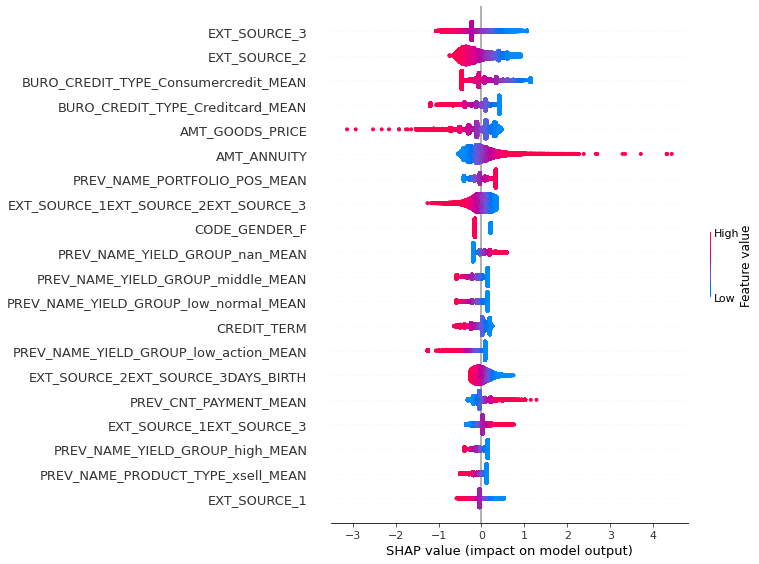

In [200]:
shap.summary_plot(lin_reg_explainer1.shap_values(X_test),
                  features = X_test,
                  feature_names=X_train.columns)

Below we have generated a summary plot with plot type as bar based on shape values generated from test data using the first linear explainer. The bar chart shows the average impact of each feature on the final prediction. This also highlights feature importance based on shap values.

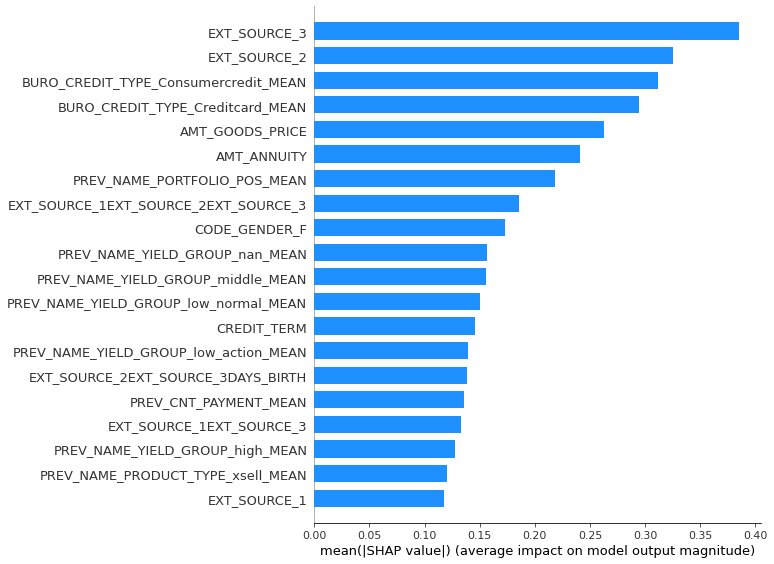

In [201]:
shap.summary_plot(lin_reg_explainer1.shap_values(X_test),
                  feature_names=X_train.columns,
                  plot_type="bar",
                  color="dodgerblue"
                  )